# Telco Customer Churn
* Goal: "Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs."
* Content: Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

###### Information
* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
sns.set()

In [2]:
raw_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(len(raw_data))
raw_data.head()

7043


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
raw_data = raw_data.drop(['customerID'], axis = 1)

In [4]:
raw_data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

### Initial visualisation
We also store the info to check for distribution shifts.

In [23]:
from typing import Tuple, Optional

def make_churn_pct_and_count_df(df: pd.DataFrame, max_levels: int = 4) -> pd.DataFrame:
    """
    Builds a tidy DataFrame of churn percentages AND counts for categorical features
    with up to `max_levels` unique values.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame with categorical features and churn data
    max_levels : int, default=4
        Maximum number of unique values for a feature to be included
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with columns ['feature', 'level', 'churn_pct', 'count', 'churn_count']
    """
    # Ensure ChurnFlag exists
    if 'ChurnFlag' not in df.columns:
        df = df.copy()
        df['ChurnFlag'] = df['Churn'].map({'Yes': 1, 'No': 0})
    
    records = []
    
    # Select columns except churn flags
    for col in df.columns:
        if col in ('Churn', 'ChurnFlag'):
            continue
            
        # Only categorical with ≤ max_levels distinct values
        nlev = df[col].nunique(dropna=True)
        if nlev <= max_levels:
            # Group by the feature
            grouped = df.groupby(col)
            
            # Calculate counts and percentages
            counts = grouped.size()
            churn_counts = grouped['ChurnFlag'].sum()
            churn_pcts = (churn_counts / counts) * 100
            
            for lvl in counts.index:
                records.append({
                    'feature': col,
                    'level': lvl,
                    'churn_pct': churn_pcts[lvl],
                    'count': counts[lvl],
                    'churn_count': churn_counts[lvl]
                })
    
    pct_df = pd.DataFrame.from_records(records)
    
    # Ensure categorical order per feature
    pct_df['feature'] = pct_df['feature'].astype(str)
    return pct_df


def plot_churn_with_counts(
    pct_df: pd.DataFrame, 
    figsize: Tuple[int, int] = (10, 6),
    sort_by: str = 'level',
    sort_ascending: bool = True,
    title_suffix: Optional[str] = None
) -> None:
    """
    Given a tidy churn-pct DataFrame (from make_churn_pct_and_count_df),
    produce dual-axis plots showing both churn percentage and counts.
    
    Parameters:
    -----------
    pct_df : pd.DataFrame
        DataFrame with churn percentages and counts
    figsize : Tuple[int, int], default=(10, 6)
        Figure size for the plots
    sort_by : str, default='level'
        How to sort the categories: 'level', 'churn_pct', or 'count'
    sort_ascending : bool, default=True
        Whether to sort in ascending order
    title_suffix : Optional[str], default=None
        Additional text to add to plot titles
    """
    features = pct_df['feature'].unique()
    
    for feat in features:
        sub = pct_df[pct_df['feature'] == feat].copy()
        
        # Sort as requested
        if sort_by in sub.columns:
            sub = sub.sort_values(sort_by, ascending=sort_ascending)
        
        # Create figure with two y-axes
        fig, ax1 = plt.subplots(figsize=figsize)
        
        # Plot churn percentage bars
        bars = sns.barplot(
            data=sub,
            x='level',
            y='churn_pct',
            palette='deep',
            ax=ax1
        )
        
        # Add count values on the secondary y-axis
        ax2 = ax1.twinx()
        
        # Line plot for counts
        sns.lineplot(
            data=sub, 
            x=np.arange(len(sub)),  # Use indices for x-axis alignment with bars
            y='count', 
            marker='o',
            color='black',
            ax=ax2
        )
        
        # Format the primary y-axis (percentages)
        ax1.set_ylabel('Churn Rate (%)', color='#1f77b4', fontweight='bold')
        ax1.tick_params(axis='y', labelcolor='#1f77b4')
        ax1.set_ylim(0, min(100, sub['churn_pct'].max() * 1.2))  # Max of 100% with some headroom
        
        # Format the secondary y-axis (counts)
        ax2.set_ylabel('Count', color='black', fontweight='bold')
        ax2.tick_params(axis='y', labelcolor='black')
        ax2.grid(False)  # Prevent dual grids
        
        # Add title and labels
        title = f'Churn Rate by {feat}'
        if title_suffix:
            title += f' {title_suffix}'
        ax1.set_title(title, fontsize=12, fontweight='bold')
        ax1.set_xlabel(feat)
        
        # Add percentage annotations to the bars
        for i, p in enumerate(ax1.patches):
            height = p.get_height()
            churn_count = sub.iloc[i]['churn_count']
            total_count = sub.iloc[i]['count']
            
            ax1.annotate(
                f'{height:.1f}%\n({int(churn_count)}/{int(total_count)})', 
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='gray', alpha=0.8)
            )
        
        # Add count values near the points on the line
        for i, (_, row) in enumerate(sub.iterrows()):
            ax2.annotate(
                f'{int(row["count"])}', 
                (i, row['count']),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center', fontsize=9,
                bbox=dict(boxstyle="round,pad=0.2", fc='white', ec='gray', alpha=0.8)
            )
        
        plt.tight_layout()
        plt.show()


def plot_feature_distributions(
    df: pd.DataFrame, 
    features: Optional[list] = None,
    max_levels: int = 4,
    figsize: Tuple[int, int] = (10, 6),
    by_churn: bool = True
) -> None:
    """
    Plot the distribution of categorical features, optionally grouped by churn.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame with categorical features and churn data
    features : Optional[list], default=None
        Specific features to plot. If None, will use all categorical features
        with <= max_levels unique values
    max_levels : int, default=4
        Maximum number of unique values for a feature to be included
    figsize : Tuple[int, int], default=(10, 6)
        Figure size for the plots
    by_churn : bool, default=True
        Whether to split distributions by churn status
    """
    # Ensure ChurnFlag exists
    if 'ChurnFlag' not in df.columns:
        df = df.copy()
        df['ChurnFlag'] = df['Churn'].map({'Yes': 1, 'No': 0})
    
    # Create Churn label column for plots
    df['Churn Status'] = df['ChurnFlag'].map({1: 'Churned', 0: 'Retained'})
    
    # Get features to plot if not specified
    if features is None:
        features = [
            col for col in df.columns 
            if col not in ('Churn', 'ChurnFlag', 'Churn Status') 
            and df[col].nunique(dropna=True) <= max_levels
        ]
    
    # Plot each feature
    for feat in features:
        plt.figure(figsize=figsize)
        
        if by_churn:
            # Plot distribution split by churn status
            ax = sns.countplot(
                data=df,
                x=feat,
                hue='Churn Status',
                palette=['#2ecc71', '#e74c3c']  # Green for retained, red for churned
            )
            plt.title(f'Distribution of {feat} by Churn Status', fontweight='bold')
            plt.legend(title='')
            
            # Add count annotations
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(
                    f'{int(height)}', 
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=9
                )
        else:
            # Plot overall distribution
            ax = sns.countplot(
                data=df,
                x=feat,
                palette='viridis'
            )
            plt.title(f'Distribution of {feat}', fontweight='bold')
            
            # Add count and percentage annotations
            total = len(df)
            for p in ax.patches:
                height = p.get_height()
                percentage = 100 * height / total
                ax.annotate(
                    f'{int(height)}\n({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=9
                )
        
        plt.xticks(rotation=45 if len(str(df[feat].iloc[0])) > 5 else 0)
        plt.tight_layout()
        plt.show()

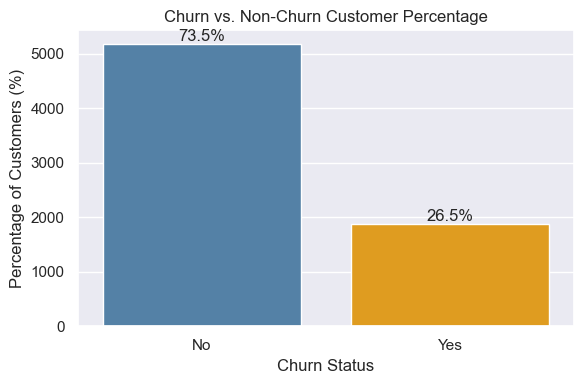

In [24]:
total = len(raw_data)

plt.figure(figsize=(6, 4))
ax = sns.countplot(
    x='Churn',
    data=raw_data,
    palette={'Yes': 'orange', 'No': 'steelblue'}
)

# Convert counts to percentages and annotate
for p in ax.patches:
    pct = p.get_height() / total * 100
    ax.annotate(
        f'{pct:.1f}%', 
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', 
        va='bottom'
    )

ax.set_title('Churn vs. Non-Churn Customer Percentage')
ax.set_xlabel('Churn Status')
ax.set_ylabel('Percentage of Customers (%)')
plt.tight_layout()
plt.show()

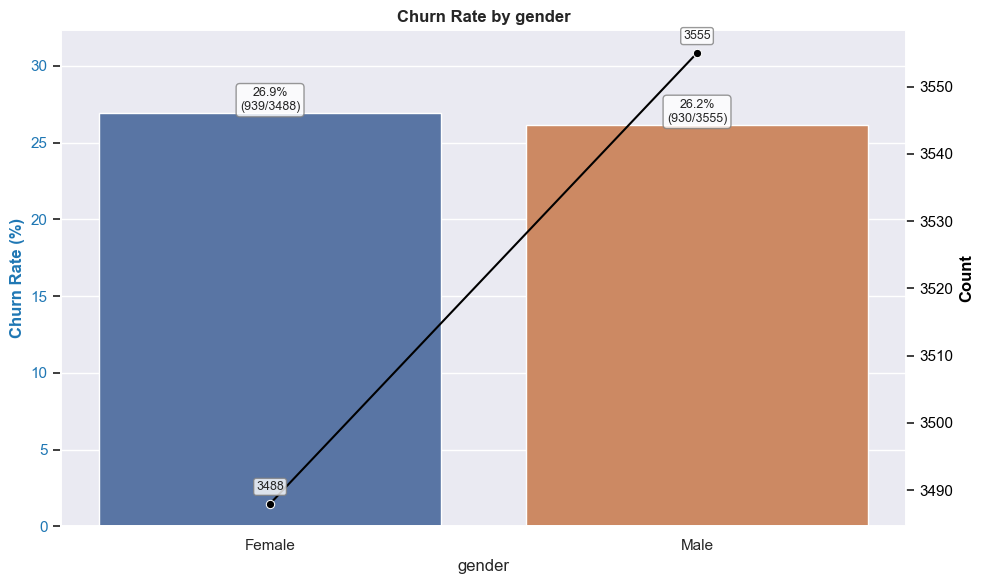

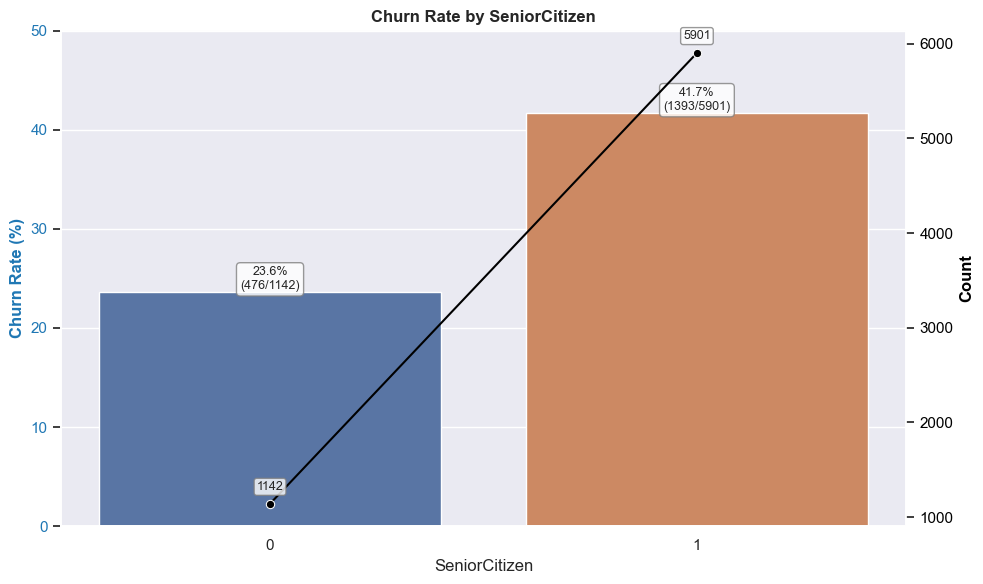

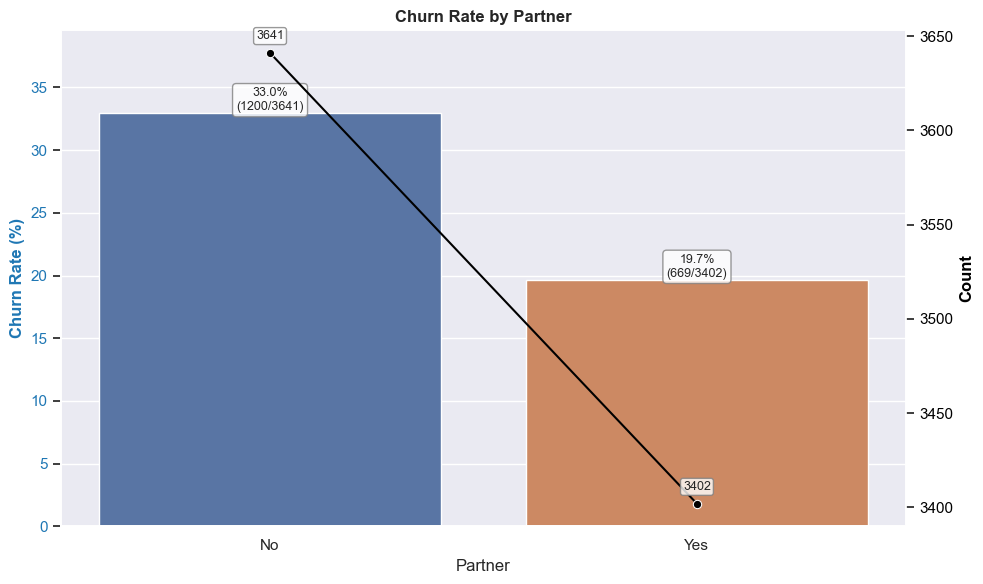

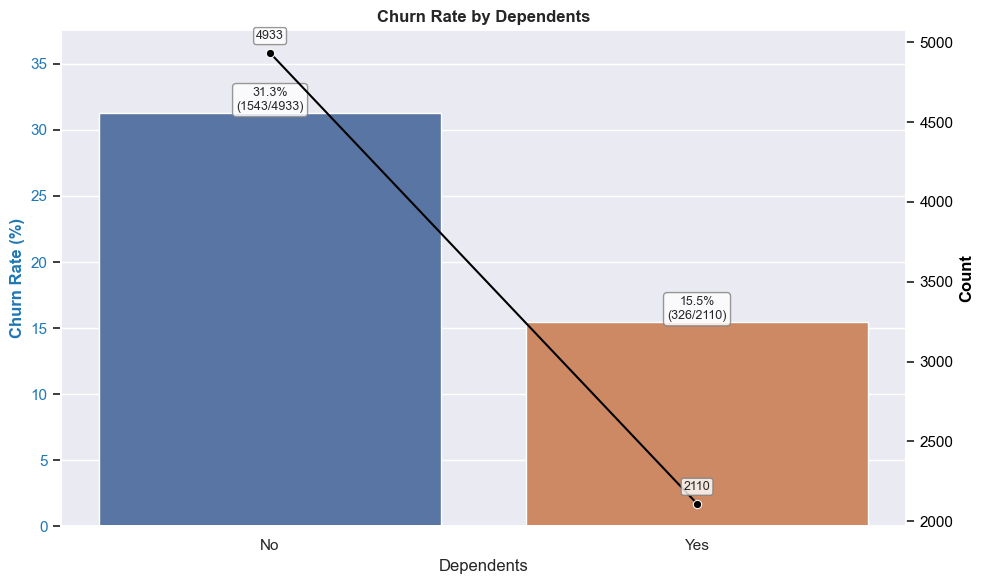

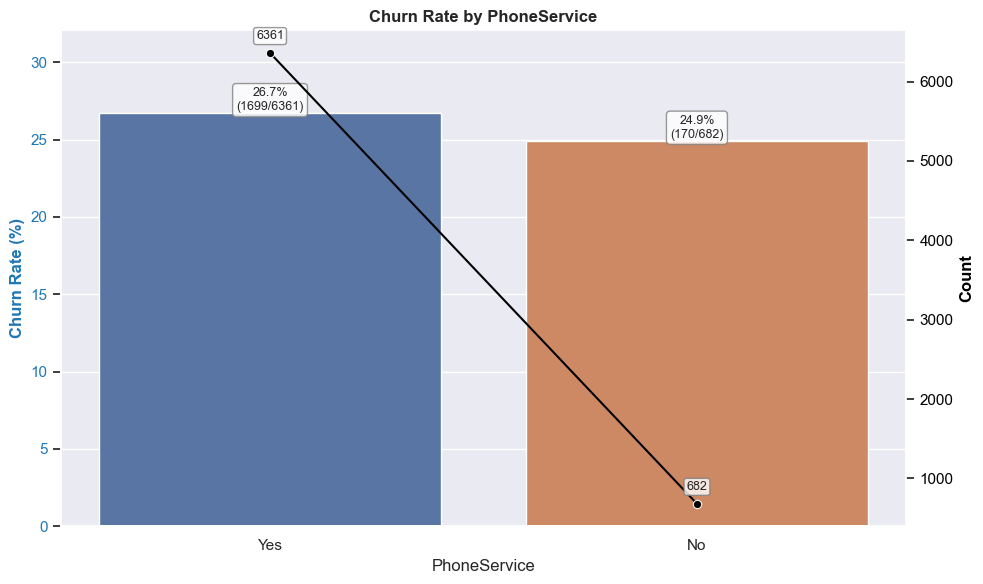

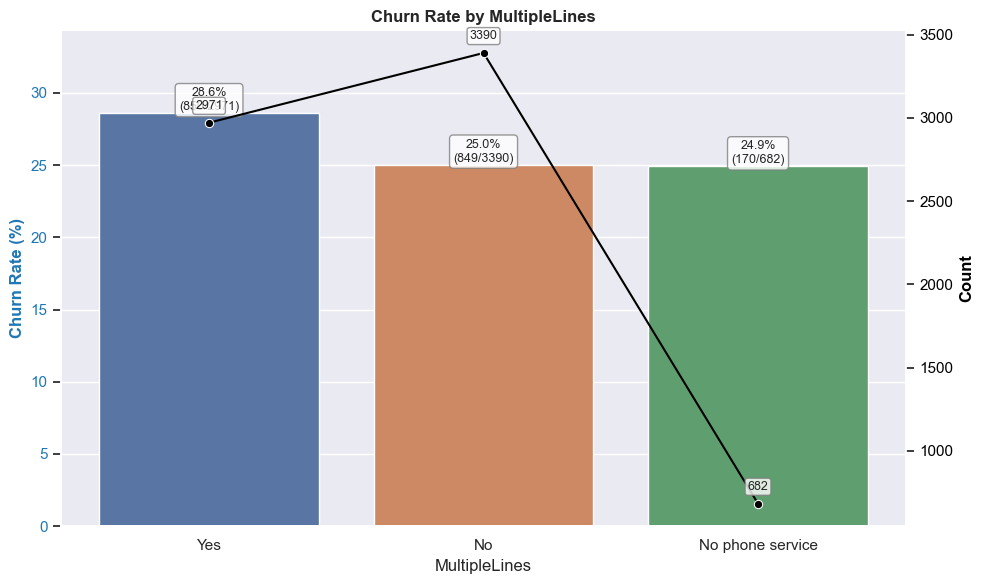

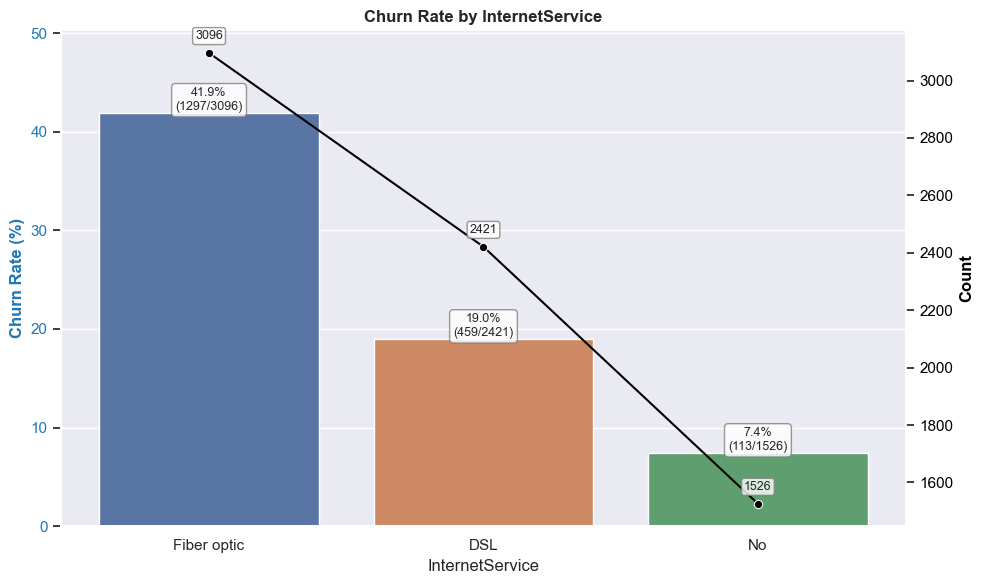

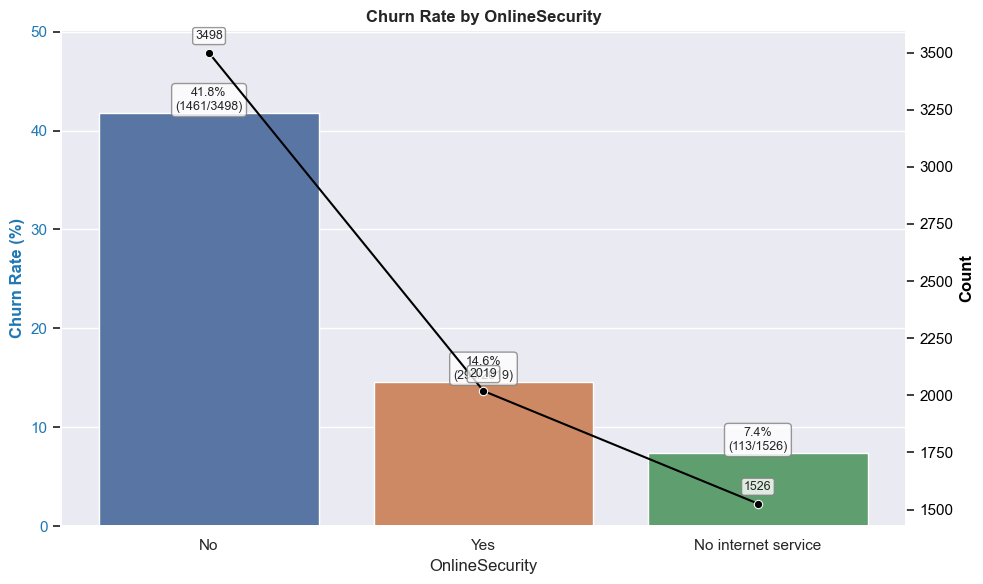

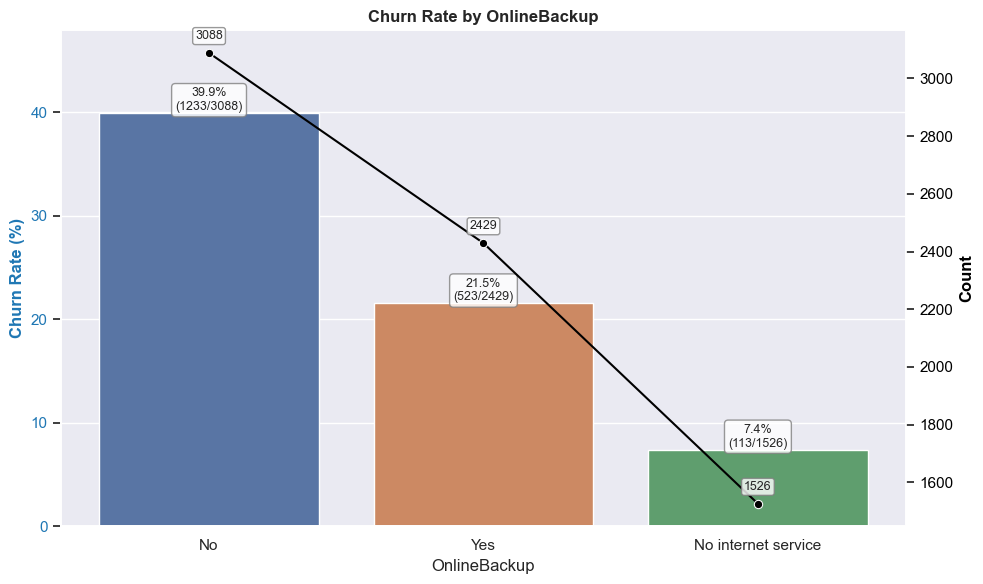

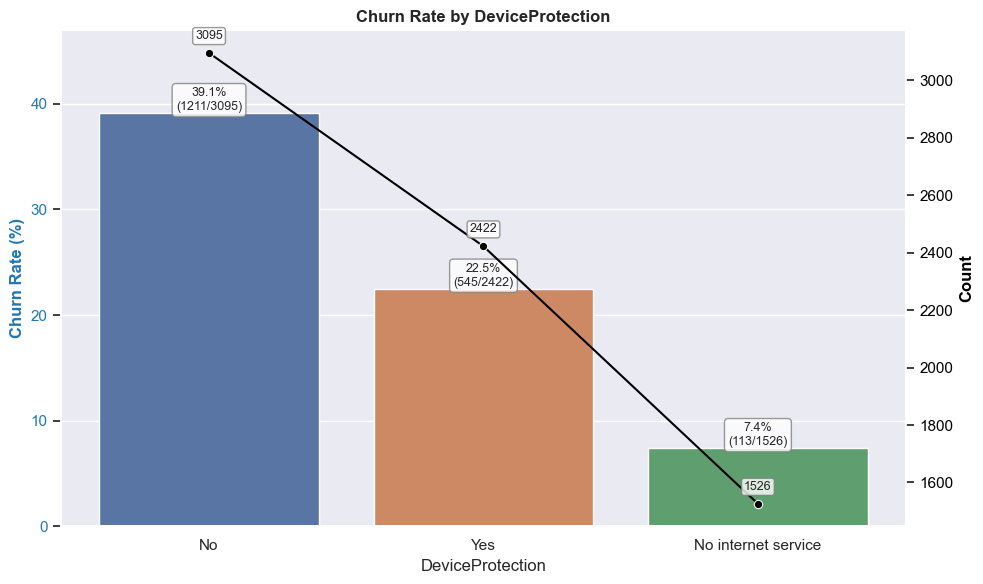

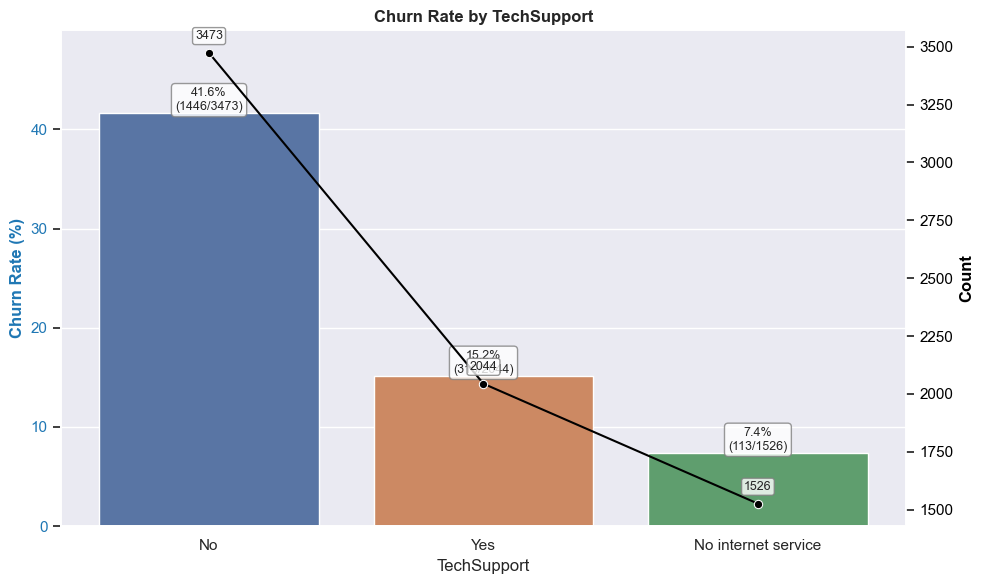

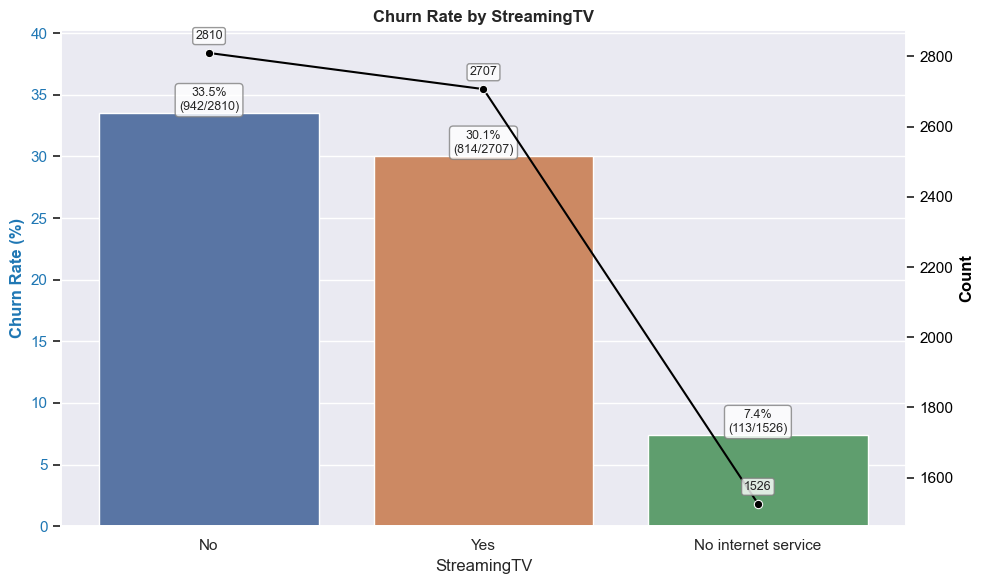

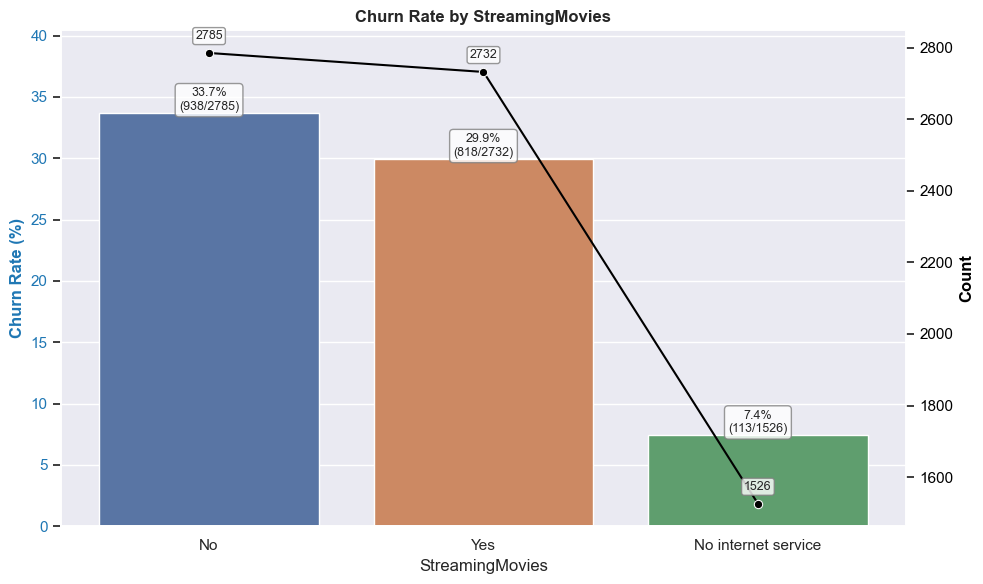

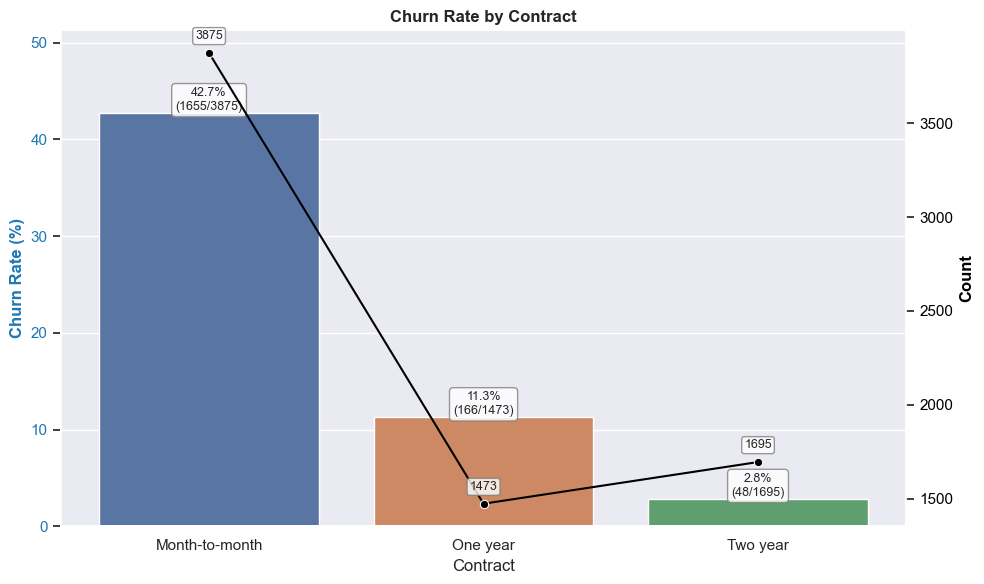

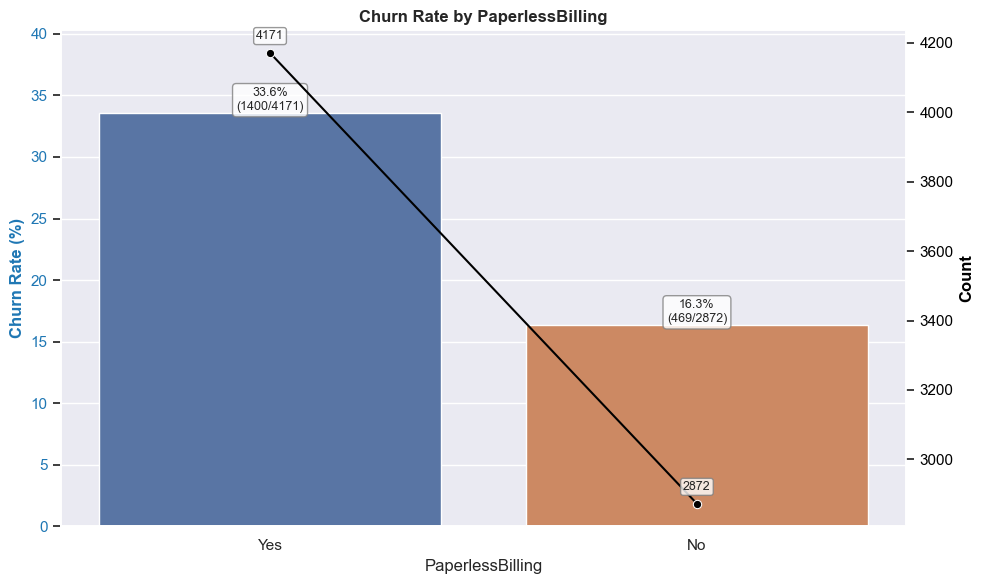

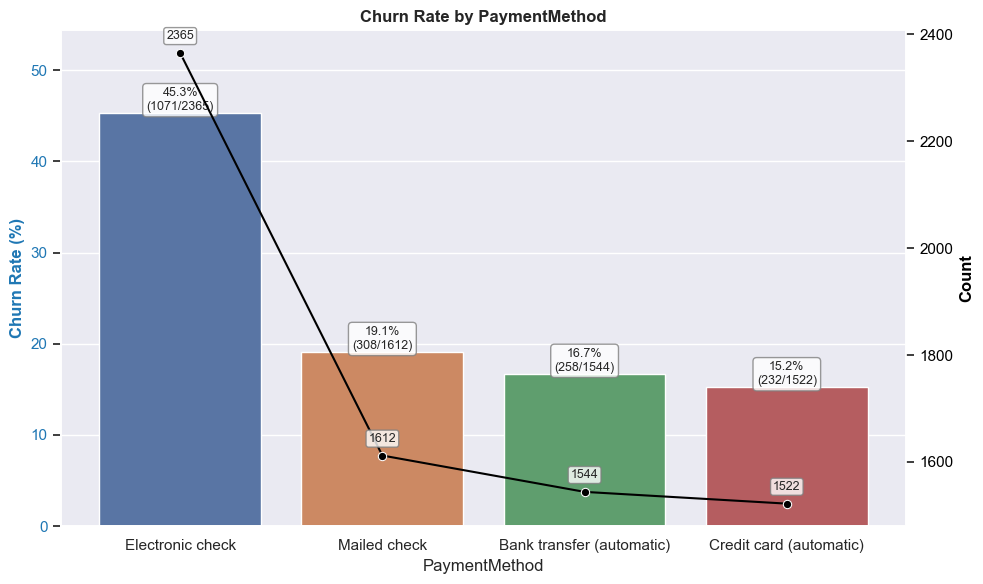

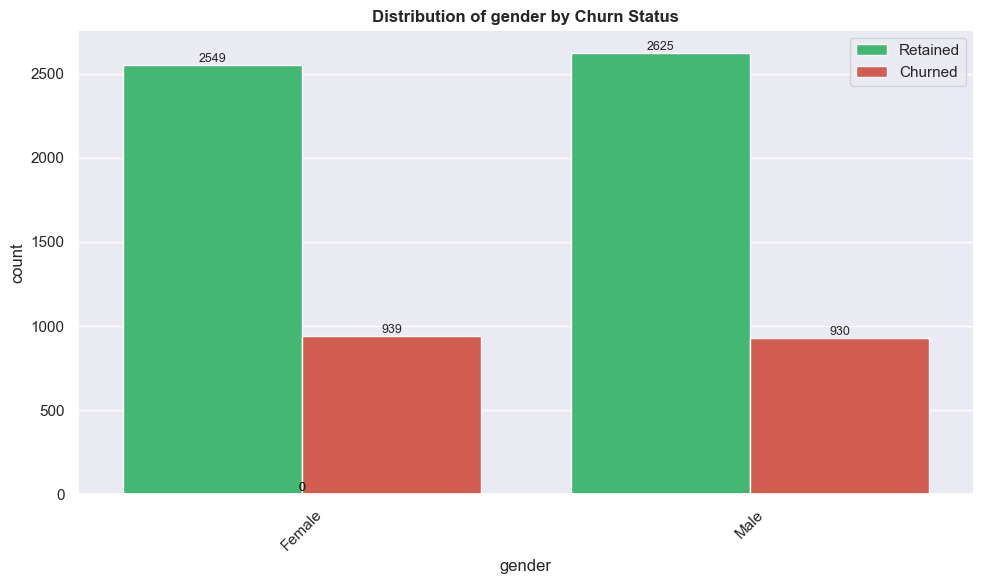

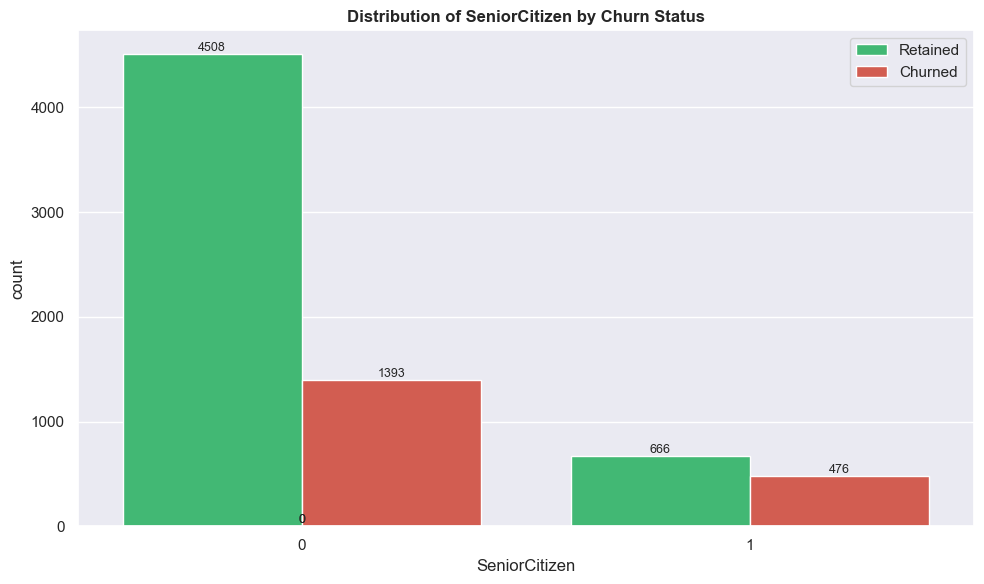

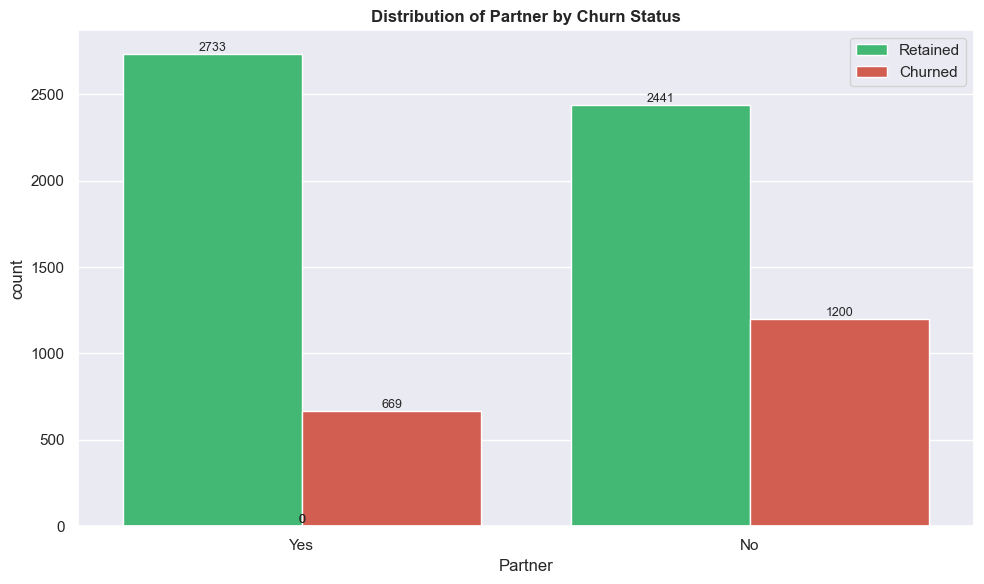

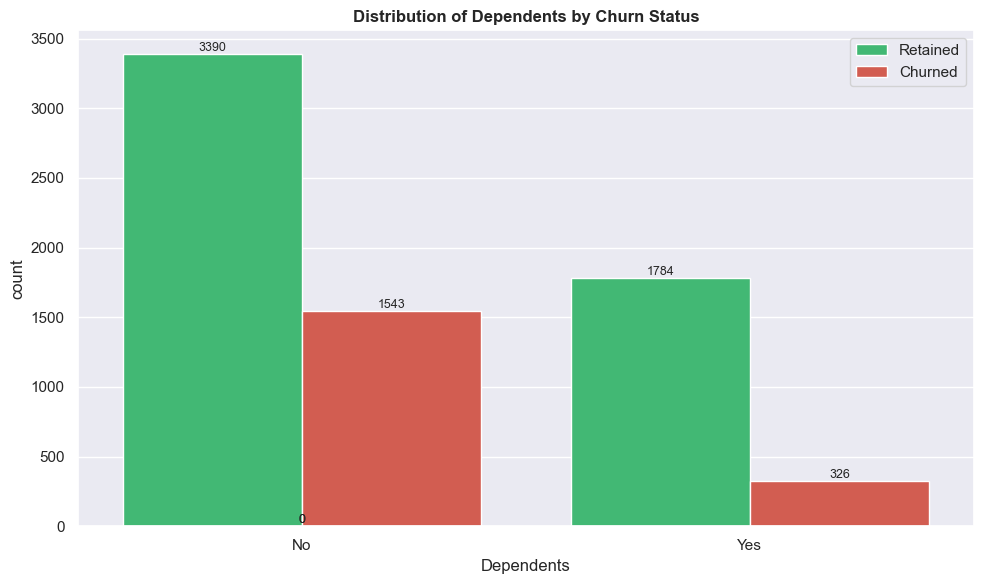

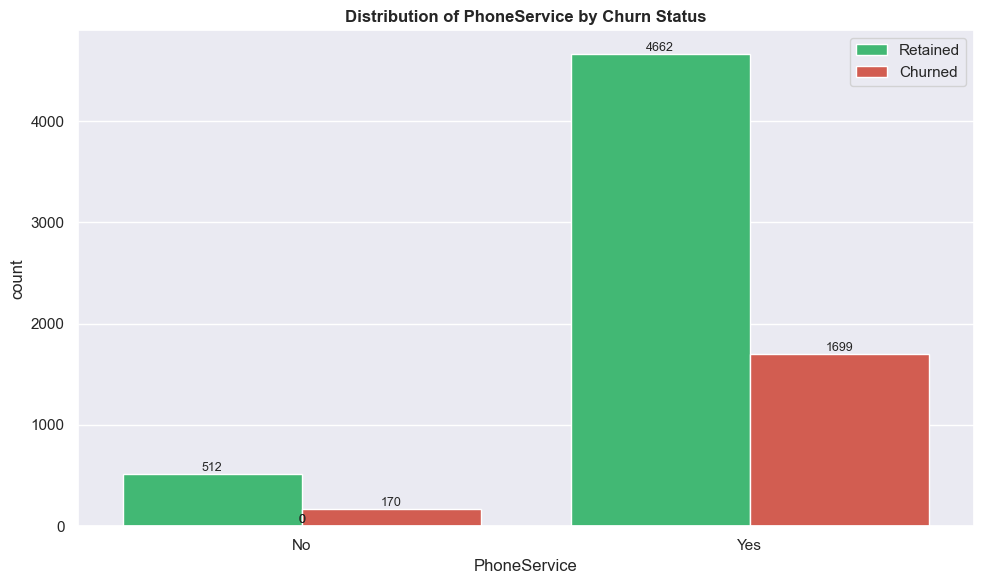

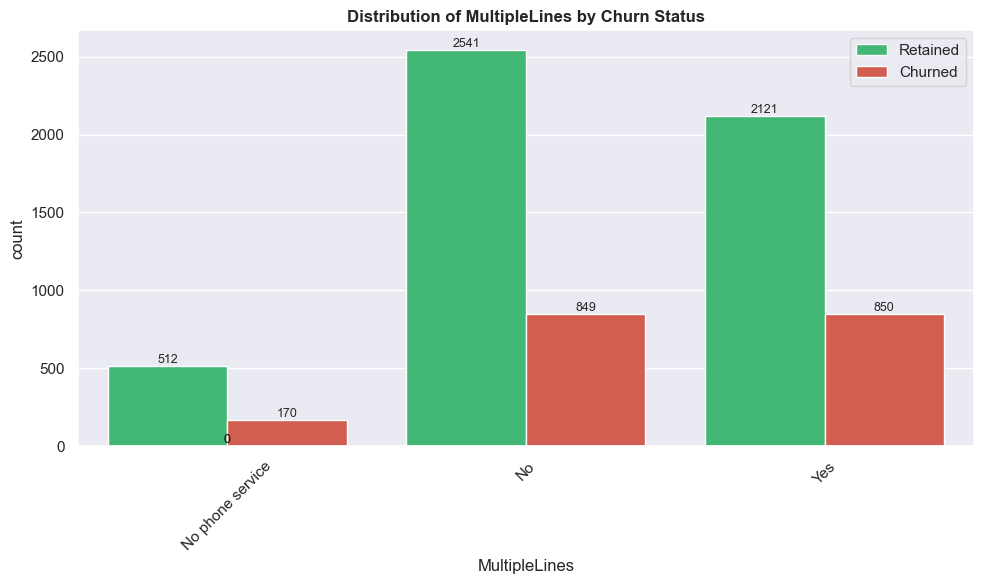

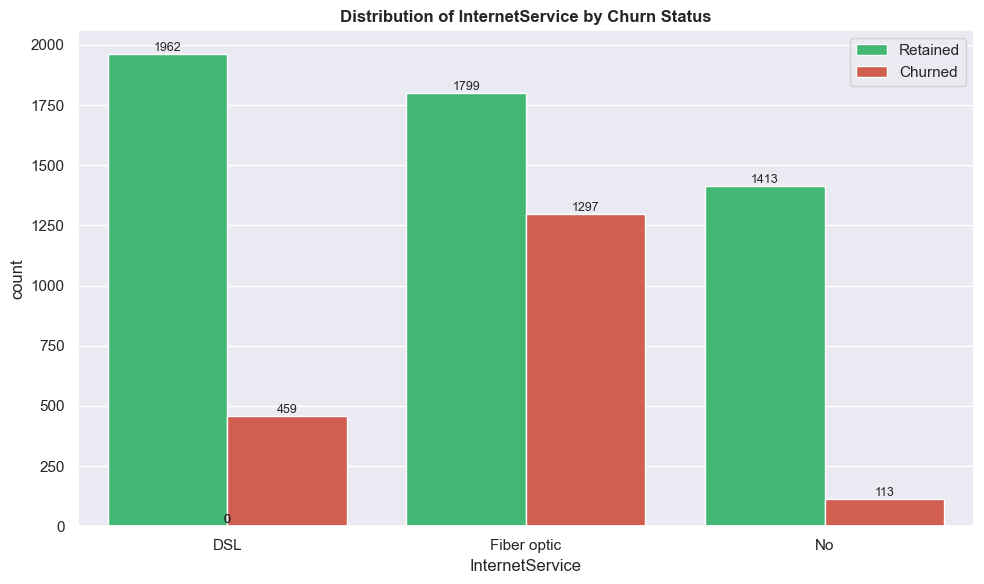

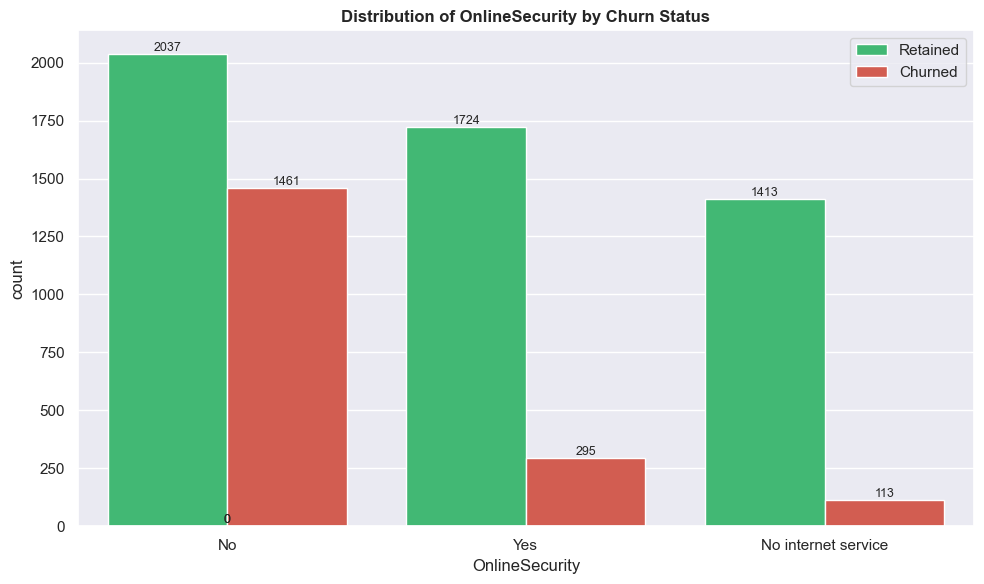

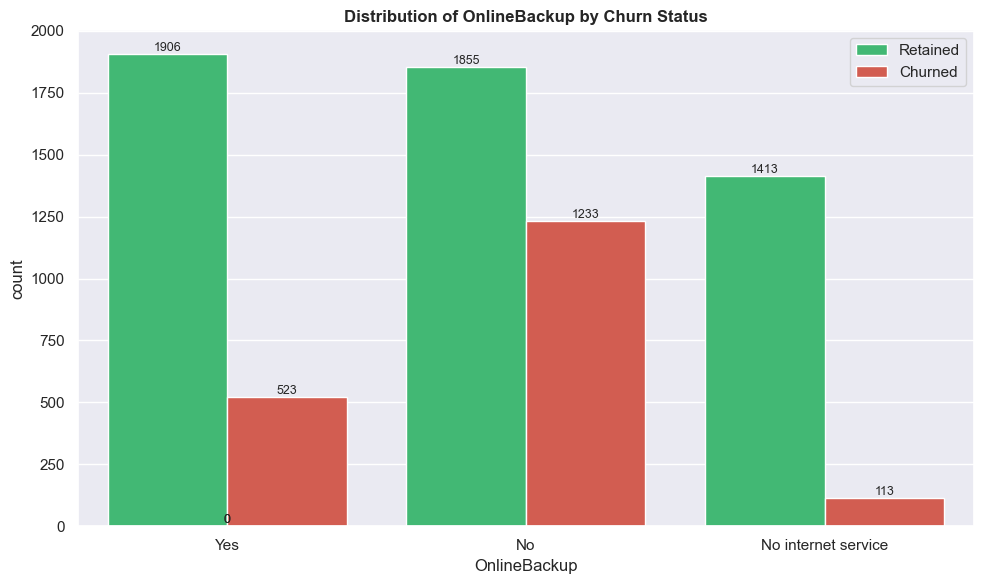

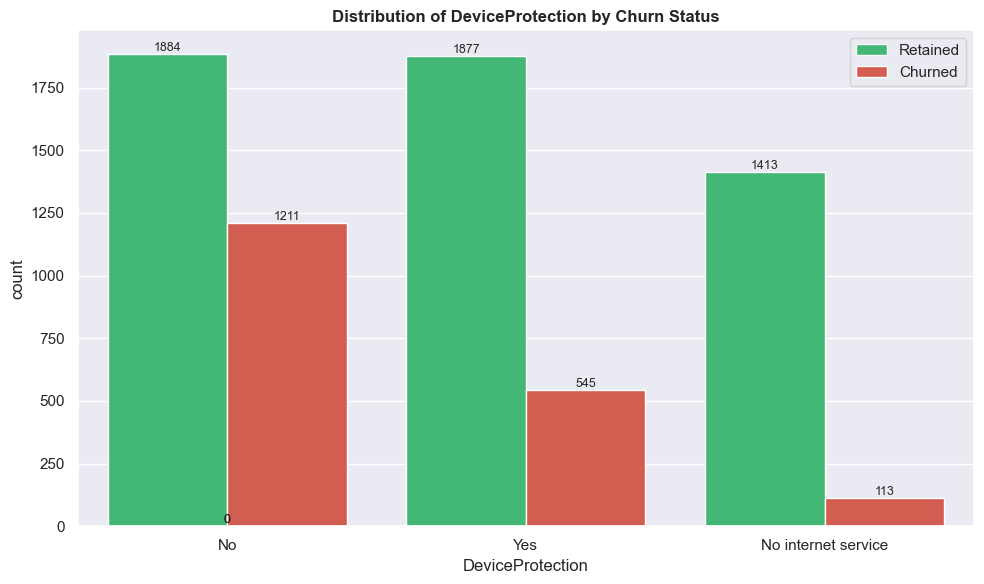

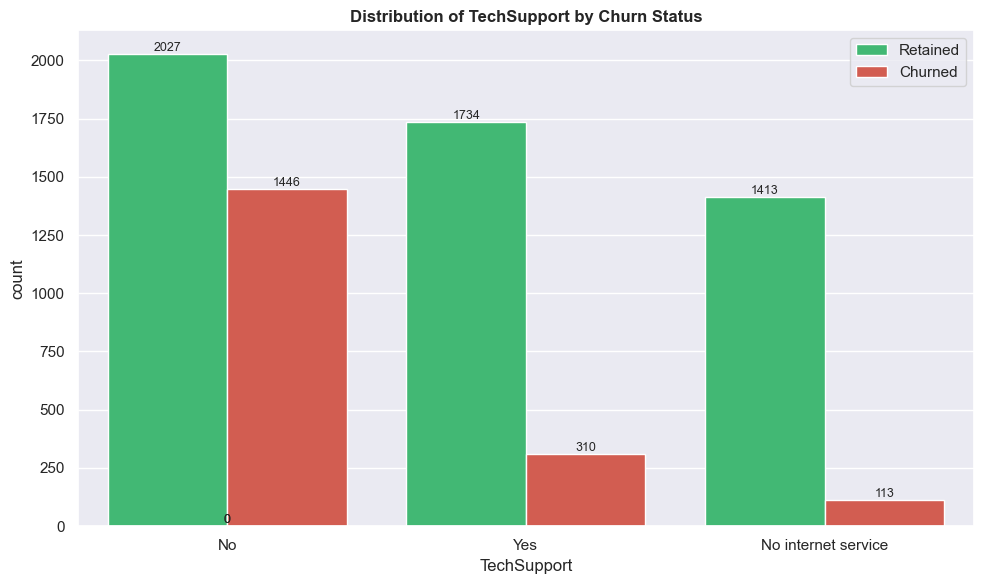

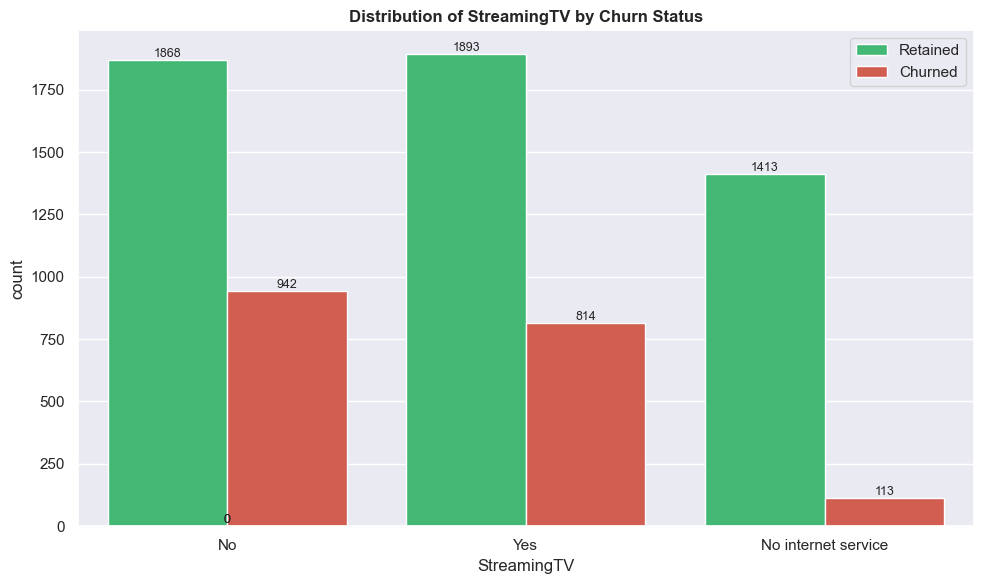

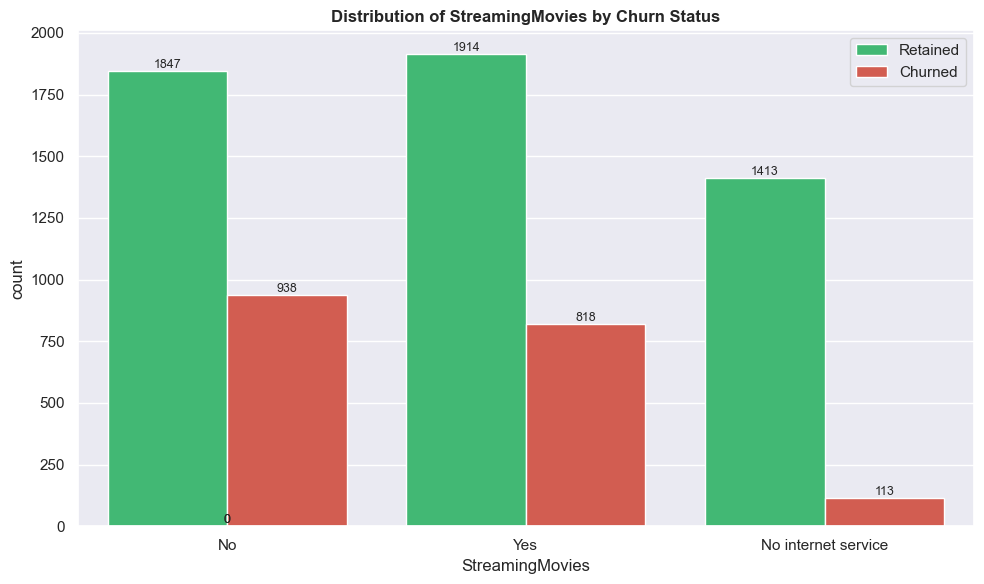

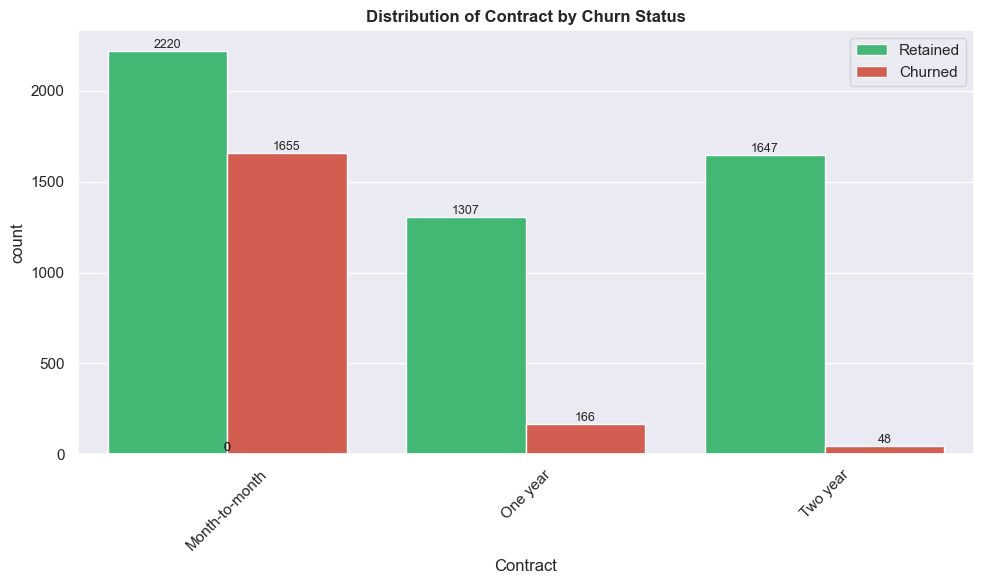

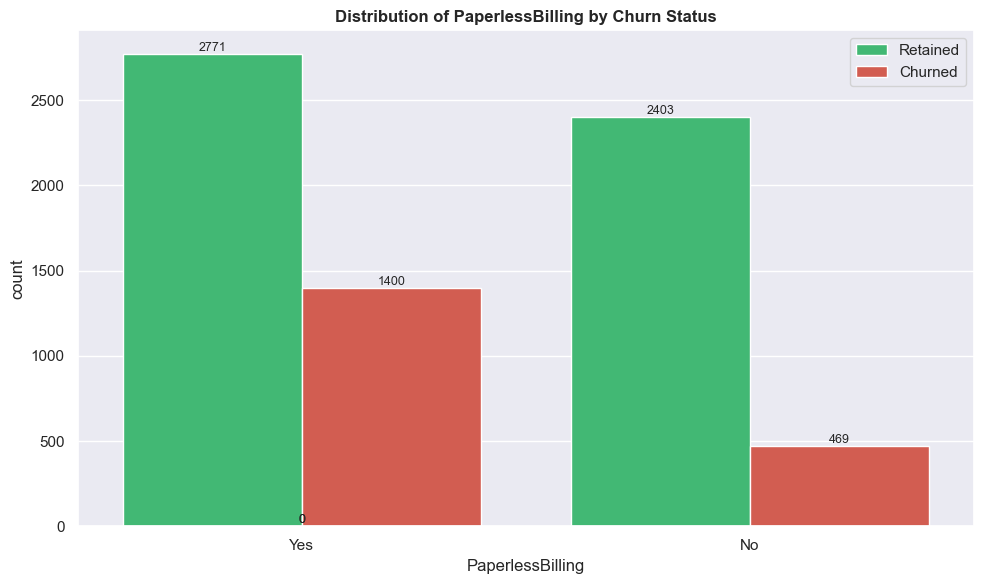

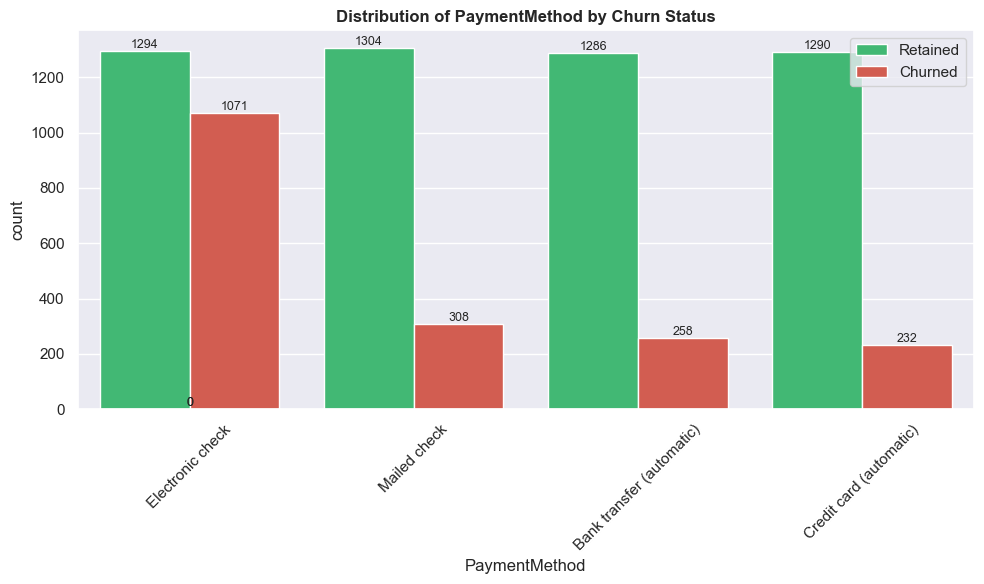

In [25]:
raw_data_viz = raw_data.copy()
# # Build the tidy DataFrame
# pct_raw_data = make_churn_pct_df(raw_data_viz, max_levels=4)

# # Plot with seaborn
# plot_churn_with_seaborn(pct_raw_data)

pct_raw_data = make_churn_pct_and_count_df(raw_data_viz, max_levels=4)

# Plot churn rates with counts
plot_churn_with_counts(pct_raw_data, sort_by='churn_pct', sort_ascending=False)

# Plot feature distributions by churn status
plot_feature_distributions(raw_data_viz, by_churn=True)

#### Balancing the dataframe based on our target variable
Also Check Using stratified undersampling

In [30]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from typing import Union, List, Optional, Dict, Tuple


def balance_churn_df(
    df: pd.DataFrame,
    churn_col: str = 'Churn',
    label: Union[str, int, float] = 'Yes',
    random_state: int = 42,
    stratify: bool = False,
    strat_cols: Optional[List[str]] = None,
    max_cardinality: int = 5,
    balance_by_features: Optional[List[str]] = None,
    target_ratios: Optional[Dict[Tuple, float]] = None
) -> pd.DataFrame:
    """
    Returns a balanced DataFrame with equal churn vs. non-churn counts,
    undersampling the majority class proportionally across specified categorical features.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with churn indicator.
    churn_col : str
        Name of the churn column.
    label : Union[str, int, float]
        The value in churn_col that indicates churn (e.g. 'Yes', 1, etc.).
    random_state : int
        Seed for reproducibility.
    stratify : bool, default=False
        If True, undersample the majority class proportionally
        across strata of categorical features.
    strat_cols : Optional[List[str]], default=None
        Specific columns to use for stratification. If None and stratify=True,
        will use categorical columns with cardinality < max_cardinality.
    max_cardinality : int, default=5
        Maximum number of unique values for a column to be considered
        for automatic stratification.
    balance_by_features : Optional[List[str]], default=None
        If provided, balance the dataset by these specific features instead of
        just balancing the target classes. This creates a balanced dataset where
        each combination of feature values has roughly the same number of samples.
    target_ratios : Optional[Dict[Tuple, float]], default=None
        If provided with balance_by_features, this specifies the target ratio for 
        each feature combination. Keys should be tuples of feature values, and values 
        should be the desired proportion of the total samples.
        
    Returns
    -------
    pd.DataFrame
        Balanced dataframe with equal number of churn and non-churn samples
        or balanced by feature combinations if balance_by_features is used.
    """
    np.random.seed(random_state)
    df = df.copy()
    
    # 1) Map churn to 0/1
    if 'ChurnFlag' not in df.columns:
        df['ChurnFlag'] = df[churn_col].apply(lambda x: 1 if x == label else 0)
    
    # If balancing by features, use a different approach
    if balance_by_features is not None and len(balance_by_features) > 0:
        return _balance_by_features(
            df, 
            features=balance_by_features, 
            target_ratios=target_ratios,
            random_state=random_state
        )
    
    # 2) Split minority and majority classes
    df_min = df[df['ChurnFlag'] == 1]
    df_maj = df[df['ChurnFlag'] == 0]
    
    # Check if we need to balance (already balanced)
    if len(df_min) == len(df_maj):
        return df
    
    # Ensure minority class is actually smaller
    if len(df_min) > len(df_maj):
        df_min, df_maj = df_maj, df_min
        minority_label = 0
    else:
        minority_label = 1
    
    n_min = len(df_min)
    df_maj_under = None
    
    # Handle stratified undersampling
    if stratify:
        # Determine stratification columns
        if strat_cols is None:
            strat_cols = [
                c for c in df.columns
                if c not in {churn_col, 'ChurnFlag'}
                and df[c].nunique(dropna=False) < max_cardinality
                and df[c].dtype != 'float'  # Avoid continuous variables
            ]
        
        if not strat_cols:
            # Fall back to non-stratified if no stratification columns
            stratify = False
        else:
            try:
                # Create a compound stratification key
                # Handle NaNs by converting to string "_NA_"
                df_maj_copy = df_maj.copy()
                
                # Replace NaNs with a string placeholder in stratification columns
                for col in strat_cols:
                    if df_maj_copy[col].isna().any():
                        df_maj_copy[col] = df_maj_copy[col].fillna("_NA_")
                
                # Create the stratification key
                if len(strat_cols) == 1:
                    # If only one stratification column, use it directly
                    df_maj_copy['_stratum'] = df_maj_copy[strat_cols[0]].astype(str)
                else:
                    # Combine multiple columns into a single key
                    df_maj_copy['_stratum'] = df_maj_copy[strat_cols].astype(str).agg('_'.join, axis=1)
                
                # Get stratum counts and proportions
                counts = df_maj_copy['_stratum'].value_counts()
                props = counts / counts.sum()
                
                # Calculate target sample size per stratum (proportional to original)
                targets = (props * n_min).round().astype(int)
                
                # Adjust to ensure the total matches the minority class size
                # This uses a more sophisticated approach to minimize distortion
                diff = targets.sum() - n_min
                
                if diff != 0:
                    # Sort strata by size to make adjustments less disruptive
                    sorted_strata = targets.sort_values(ascending=False)
                    
                    # Distribute the difference across strata to minimize proportional impact
                    if diff > 0:  # Need to reduce
                        for i, (stratum, _) in enumerate(sorted_strata.items()):
                            if i < diff:
                                targets[stratum] -= 1
                    else:  # Need to increase
                        for i, (stratum, _) in enumerate(sorted_strata.items()):
                            if i < abs(diff):
                                targets[stratum] += 1
                
                # Handle empty strata (if any)
                targets = targets[targets > 0]
                
                # Sample from each stratum
                samples = []
                for stratum, target_size in targets.items():
                    stratum_df = df_maj_copy[df_maj_copy['_stratum'] == stratum]
                    
                    # If the stratum is smaller than the target, sample with replacement
                    if len(stratum_df) < target_size:
                        sampled = resample(
                            stratum_df, 
                            replace=True,
                            n_samples=target_size,
                            random_state=random_state + hash(stratum) % 10000
                        )
                    else:
                        sampled = stratum_df.sample(
                            n=target_size, 
                            replace=False,
                            random_state=random_state + hash(stratum) % 10000
                        )
                        
                    samples.append(sampled)
                
                # Combine all stratified samples
                if samples:
                    df_maj_under = pd.concat(samples)
                    # Remove the stratification helper column
                    if '_stratum' in df_maj_under.columns:
                        df_maj_under = df_maj_under.drop(columns=['_stratum'])
            except Exception as e:
                print(f"Stratified sampling failed with error: {e}. Falling back to simple undersampling.")
                stratify = False
                df_maj_under = None
    
    # Fall back to simple undersampling if stratification not used or failed
    if not stratify or df_maj_under is None:
        df_maj_under = resample(
            df_maj,
            replace=False,
            n_samples=n_min,
            random_state=random_state
        )
    
    # Restore the original class mapping if it was swapped
    if minority_label == 0:
        df_maj_final = df_min
        df_min_final = df_maj_under
    else:
        df_min_final = df_min
        df_maj_final = df_maj_under
    
    # Combine and shuffle
    df_bal = pd.concat([df_min_final, df_maj_final])
    df_bal = df_bal.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    return df_bal


def _balance_by_features(
    df: pd.DataFrame, 
    features: List[str],
    target_ratios: Optional[Dict[Tuple, float]] = None,
    random_state: int = 42,
    min_group_size: int = 10,
    target_samples: Optional[int] = None
) -> pd.DataFrame:
    """
    Balance the dataset by specific features, ensuring each combination of feature values
    has approximately the same number of samples or the specified target ratio.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame to balance
    features : List[str]
        List of column names to balance by
    target_ratios : Optional[Dict[Tuple, float]], default=None
        If provided, specifies the target ratio for each feature combination
    random_state : int, default=42
        Seed for reproducibility
    min_group_size : int, default=10
        Minimum number of samples for any group (to avoid very small groups)
    target_samples : Optional[int], default=None
        Total target number of samples for the balanced dataset.
        If None, will determine automatically.
        
    Returns
    -------
    pd.DataFrame
        Balanced DataFrame where feature combinations have desired distribution
    """
    df = df.copy()
    
    # Create a compound key from the feature values
    # Handle NaNs by filling with a placeholder
    df_with_key = df.copy()
    
    # Replace NaNs with a string placeholder in feature columns
    for col in features:
        if df_with_key[col].isna().any():
            df_with_key[col] = df_with_key[col].fillna("_NA_")
    
    # Create a compound key from feature values
    if len(features) == 1:
        df_with_key['_feature_key'] = df_with_key[features[0]].astype(str)
    else:
        df_with_key['_feature_key'] = df_with_key[features].astype(str).agg('_'.join, axis=1)
    
    # Get counts of each combination
    key_counts = df_with_key['_feature_key'].value_counts()
    
    # If target_ratios not provided, aim for equal representation
    if target_ratios is None:
        # Compute target size: use minimum count that will give meaningful groups
        if target_samples is None:
            # Choose a reasonable target size:
            # - Aim for at least min_group_size per group
            # - Don't exceed original dataset size
            target_samples = min(
                len(df),  # Don't exceed original size
                max(
                    len(key_counts) * min_group_size,  # Ensure minimum per group
                    int(len(df) * 0.8)  # Try to keep at least 80% of data by default
                )
            )
        
        # Equal distribution across all groups
        target_per_group = int(target_samples / len(key_counts))
        
        # Ensure minimum size per group
        target_per_group = max(target_per_group, min_group_size)
        
        # Create targets dictionary - equal for all groups
        targets = {key: target_per_group for key in key_counts.index}
    else:
        # Convert the tuple keys from target_ratios to strings that match _feature_key format
        string_target_ratios = {}
        for k, v in target_ratios.items():
            # Convert tuple to matching string format
            if isinstance(k, tuple):
                if len(k) == len(features):
                    # Match the format used in _feature_key
                    key_str = '_'.join(str(x) for x in k)
                    string_target_ratios[key_str] = v
            else:
                # Handle case where key is not a tuple (single feature)
                string_target_ratios[str(k)] = v
        
        # Normalize ratios if they don't sum to 1
        ratio_sum = sum(string_target_ratios.values())
        if abs(ratio_sum - 1.0) > 0.01:  # Allow small tolerance
            for k in string_target_ratios:
                string_target_ratios[k] /= ratio_sum
        
        # Determine target total samples if not provided
        if target_samples is None:
            # Default to maintaining original size
            target_samples = len(df)
        
        # Calculate target per group based on ratios
        targets = {
            k: max(int(string_target_ratios.get(k, 1/len(key_counts)) * target_samples), 
                  min_group_size) 
            for k in key_counts.index
        }
        
        # Adjust totals to match target_samples
        total = sum(targets.values())
        if total != target_samples:
            # Distribute the difference proportionally
            diff = target_samples - total
            for k in sorted(targets, key=targets.get, reverse=(diff > 0)):
                if abs(diff) <= 0:
                    break
                if diff > 0:
                    targets[k] += 1
                    diff -= 1
                else:
                    if targets[k] > min_group_size:
                        targets[k] -= 1
                        diff += 1
    
    # Now sample from each group according to targets
    samples = []
    for key, target_size in targets.items():
        group_df = df_with_key[df_with_key['_feature_key'] == key]
        current_size = len(group_df)
        
        # If the group is smaller than target, sample with replacement
        if current_size < target_size:
            sampled = resample(
                group_df,
                replace=True,
                n_samples=target_size,
                random_state=random_state + hash(key) % 10000
            )
        # If group is larger than target, undersample
        elif current_size > target_size:
            sampled = group_df.sample(
                n=target_size,
                replace=False,
                random_state=random_state + hash(key) % 10000
            )
        # If exactly right size, use as is
        else:
            sampled = group_df
            
        samples.append(sampled)
    
    # Combine and shuffle
    if samples:
        balanced_df = pd.concat(samples)
        # Drop the helper column
        balanced_df = balanced_df.drop(columns=['_feature_key'])
        # Shuffle
        balanced_df = balanced_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
        return balanced_df
    else:
        # Return original if something went wrong
        return df

In [32]:
raw_data_bal = balance_churn_df(raw_data, churn_col='Churn', label='Yes', random_state=42)

print(f"Balanced dataset shape: {raw_data_bal.shape}")
print(raw_data_bal['ChurnFlag'].value_counts())

Balanced dataset shape: (3738, 21)
ChurnFlag
1    1869
0    1869
Name: count, dtype: int64


In [33]:
raw_data_su = balance_churn_df(raw_data, churn_col='Churn', label='Yes', random_state=42, stratify=True)

print(f"Balanced dataset shape: {raw_data_su.shape}")
print(raw_data_su['ChurnFlag'].value_counts())

Balanced dataset shape: (3738, 21)
ChurnFlag
1    1869
0    1869
Name: count, dtype: int64


In [72]:
pct_raw_data_bal = make_churn_pct_df(raw_data_bal, max_levels=4)

pct_raw_data_su = make_churn_pct_df(raw_data_su, max_levels=4)

#### Comparing the two dataframes to check for Distribution Shifts after balancing

In [18]:
def compare_churn_distributions(pct_raw: pd.DataFrame,
                                pct_bal: pd.DataFrame,
                                diff_threshold: float = 0.0) -> pd.DataFrame:
    """
    Compare churn % distributions between raw and balanced datasets.

    Parameters
    ----------
    pct_raw : pd.DataFrame
        Tidy DataFrame from make_churn_pct_df(raw_df), columns = ['feature', 'level', 'churn_pct']
    pct_bal : pd.DataFrame
        Tidy DataFrame from make_churn_pct_df(balanced_df), same structure.
    diff_threshold : float, default=0.0
        If >0, only return rows where absolute difference exceeds this threshold.

    Returns
    -------
    pd.DataFrame
        Merged table with columns:
          feature, level,
          churn_pct_raw, churn_pct_bal,
          pct_diff = churn_pct_bal - churn_pct_raw
        Sorted descending by |pct_diff|.
    """
    # rename columns to distinguish
    raw = pct_raw.rename(columns={'churn_pct': 'churn_pct_raw'})
    bal = pct_bal.rename(columns={'churn_pct': 'churn_pct_bal'})

    # merge on feature & level
    merged = pd.merge(raw, bal, on=['feature', 'level'], how='outer')

    # fill missing (in case some levels dropped) with 0 or NaN
    merged[['churn_pct_raw','churn_pct_bal']] = merged[['churn_pct_raw','churn_pct_bal']].fillna(0)

    # compute difference
    merged['pct_diff'] = merged['churn_pct_bal'] - merged['churn_pct_raw']

    # optionally filter by threshold
    if diff_threshold > 0:
        merged = merged[merged['pct_diff'].abs() > diff_threshold]

    # sort by absolute diff descending
    merged = merged.assign(diff_abs=merged['pct_diff'].abs()) \
                   .sort_values('diff_abs', ascending=False) \
                   .drop(columns='diff_abs') \
                   .reset_index(drop=True)

    return merged

In [40]:
big_shifts_bal = compare_churn_distributions(pct_raw_data, pct_raw_data_bal, diff_threshold=5.0)
print(f"Average difference: {big_shifts_bal['pct_diff'].mean()}")
big_shifts_bal

Average difference: 20.46833677018253


,feature,level,churn_pct_raw,count,churn_count,churn_pct_bal,pct_diff
0,TechSupport,No,41.635474,3473,1446,67.570093,25.934620
1,StreamingTV,No,33.523132,2810,942,59.282568,25.759436
2,DeviceProtection,No,39.127625,3095,1211,64.863417,25.735792
3,Contract,Month-to-month,42.709677,3875,1655,68.360182,25.650504
4,StreamingMovies,No,33.680431,2785,938,59.292035,25.611605
5,OnlineBackup,No,39.928756,3088,1233,65.515409,25.586653
6,PaymentMethod,Electronic check,45.285412,2365,1071,70.833333,25.547921
7,OnlineSecurity,No,41.766724,3498,1461,67.234238,25.467515
8,PaperlessBilling,Yes,33.565092,4171,1400,59.021922,25.456830
9,SeniorCitizen,1,41.681261,1142,476,66.947961,25.266700


In [41]:
big_shifts_su = compare_churn_distributions(pct_raw_data, pct_raw_data_su, diff_threshold=5.0)
print(f"Average difference: {big_shifts_su['pct_diff'].mean()}")
big_shifts_su

Average difference: 21.470615702008313


,feature,level,churn_pct_raw,count,churn_count,churn_pct_bal,pct_diff
0,MultipleLines,No phone service,24.926686,682,170,56.856187,31.929501
1,PhoneService,No,24.926686,682,170,56.856187,31.929501
2,SeniorCitizen,1,41.681261,1142,476,71.364318,29.683057
3,StreamingMovies,No,33.680431,2785,938,62.242867,28.562436
4,StreamingTV,No,33.523132,2810,942,61.770492,28.247360
5,StreamingTV,Yes,30.070188,2707,814,57.894737,27.824548
6,DeviceProtection,No,39.127625,3095,1211,66.648321,27.520696
7,StreamingMovies,Yes,29.941435,2732,818,57.443820,27.502385
8,OnlineBackup,No,39.928756,3088,1233,67.230098,27.301342
9,OnlineSecurity,No,41.766724,3498,1461,68.623767,26.857043


### Auto Data Clean - Transformation
* Data Exploration: Checking for NaN values, number of unique values, data type.
* Data Formating: Cheking if column that should be int or float, is string or object type. 
* Data Transformation: Binary and One Hot encoding if number of unique values is smaller than 4

In [45]:
# Get Info
def collect_column_info(df: pd.DataFrame):
    info = {}
    for col in df.columns:
        series = df[col]
        info[col] = {
            'dtype': series.dtype,
            'n_missing': series.isna().sum(),
            'n_unique': series.nunique(dropna=True),
            'sample_values': series.dropna().unique()[:5].tolist()
        }
    return info

raw_data_info = collect_column_info(raw_data)
print(raw_data_info)

{'gender': {'dtype': dtype('O'), 'n_missing': 0, 'n_unique': 2, 'sample_values': ['Female', 'Male']}, 'SeniorCitizen': {'dtype': dtype('int64'), 'n_missing': 0, 'n_unique': 2, 'sample_values': [0, 1]}, 'Partner': {'dtype': dtype('O'), 'n_missing': 0, 'n_unique': 2, 'sample_values': ['Yes', 'No']}, 'Dependents': {'dtype': dtype('O'), 'n_missing': 0, 'n_unique': 2, 'sample_values': ['No', 'Yes']}, 'tenure': {'dtype': dtype('int64'), 'n_missing': 0, 'n_unique': 73, 'sample_values': [1, 34, 2, 45, 8]}, 'PhoneService': {'dtype': dtype('O'), 'n_missing': 0, 'n_unique': 2, 'sample_values': ['No', 'Yes']}, 'MultipleLines': {'dtype': dtype('O'), 'n_missing': 0, 'n_unique': 3, 'sample_values': ['No phone service', 'No', 'Yes']}, 'InternetService': {'dtype': dtype('O'), 'n_missing': 0, 'n_unique': 3, 'sample_values': ['DSL', 'Fiber optic', 'No']}, 'OnlineSecurity': {'dtype': dtype('O'), 'n_missing': 0, 'n_unique': 3, 'sample_values': ['No', 'Yes', 'No internet service']}, 'OnlineBackup': {'dtype'

In [46]:
# Auto detect / convert numeric values that are string or object type into numeric
from pandas.api.types import is_object_dtype, is_string_dtype
import numpy as np
from typing import Tuple, List

def auto_detect_and_cast_numeric(df: pd.DataFrame,
                                 threshold: float = 0.9,
                                 use_nullable_int: bool = True,
                                 verbose: bool = True) -> pd.DataFrame:
    """
    Scans object/string columns, and if at least `threshold` fraction of 
    non-null values can be parsed as numbers, casts the column to numeric.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame
    threshold : float, default 0.9
        Minimum fraction of parseable values required to convert a column
    use_nullable_int : bool, default True
        If True, use Int64 nullable integer type for integer columns
    verbose : bool, default True
        If True, print information about converted columns
        
    Returns:
    --------
    pd.DataFrame
        A new DataFrame with appropriate columns converted to numeric
    """
    # Create a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Filter only object and string columns to check
    obj_cols = [col for col in df.columns if is_object_dtype(df[col]) or is_string_dtype(df[col])]
    
    if not obj_cols:
        if verbose:
            print("No object or string columns found to convert.")
        return df_copy
    
    # Function to vectorize checking if strings can be converted to numeric
    def is_numeric(s: pd.Series) -> pd.Series:
        """Vectorized function to check if strings can be converted to numeric"""
        # Remove commas and whitespace if present
        s = s.astype(str).str.replace(',', '', regex=False).str.strip()
        # Try to convert to numeric and check if successful
        return pd.to_numeric(s, errors='coerce').notna()
    
    converted = []
    
    # Check each column with vectorized operations for better performance
    for col in obj_cols:
        series = df[col]
        non_null = series.dropna()
        
        if non_null.empty:
            continue
        
        # Check if the column contains numbers (vectorized)
        is_num = is_numeric(non_null)
        success_rate = is_num.mean()
        
        if success_rate >= threshold:
            # Prepare the column for conversion (remove commas and whitespace)
            cleaned_series = series.astype(str).str.replace(',', '', regex=False).str.strip()
            # Convert to numeric
            numeric_series = pd.to_numeric(cleaned_series, errors='coerce')
            
            # Check if all valid values are integers
            non_null_values = numeric_series.dropna()
            if len(non_null_values) > 0:
                is_integer = np.all(non_null_values.eq(non_null_values.astype(int)))
                
                # Choose appropriate type
                if is_integer and use_nullable_int:
                    df_copy[col] = numeric_series.astype('Int64')
                    dtype_name = 'Int64'
                else:
                    df_copy[col] = numeric_series.astype('float64')
                    dtype_name = 'float64'
                
                converted.append((col, success_rate, dtype_name))
    
    # Print results if verbose is True
    if verbose:
        if converted:
            print("Auto-converted columns:")
            for col, rate, dtype in converted:
                print(f" • {col!r}: {rate:.1%} parseable → cast to {dtype}")
        else:
            print("No columns met the convertibility threshold.")
    
    return df_copy

In [74]:
# raw_data_bal, raw_data_su, raw_data_sf
data_bal = auto_detect_and_cast_numeric(raw_data_bal)
data_su = auto_detect_and_cast_numeric(raw_data_su)

Auto-converted columns:
 • 'TotalCharges': 99.9% parseable → cast to float64
Auto-converted columns:
 • 'TotalCharges': 99.8% parseable → cast to float64
Auto-converted columns:
 • 'TotalCharges': 99.9% parseable → cast to float64


In [134]:
data_full = auto_detect_and_cast_numeric(raw_data)

Auto-converted columns:
 • 'TotalCharges': 99.8% parseable → cast to float64


In [49]:
print(data_bal['TotalCharges'].isna().sum())
print(data_su['TotalCharges'].isna().sum())

5
6
9


In [136]:
data_full = data_full.dropna()

In [75]:
data_bal = data_bal.dropna()
data_su = data_su.dropna()

data_bal = data_bal.drop(['ChurnFlag'], axis=1)
data_su = data_su.drop(['ChurnFlag'], axis=1)

In [61]:
# Binary and One Hot encoding based on conditional parameter
def transform_categorical_columns(df: pd.DataFrame, 
                                 binary_threshold: int = 3,
                                 onehot_threshold: int = 5,
                                 verbose: bool = True) -> pd.DataFrame:
    """
    Transforms categorical columns in a DataFrame based on the number of unique values:
    - Binary encoding for columns with fewer than binary_threshold unique values
    - One-hot encoding for columns with fewer than onehot_threshold unique values
    - Leaves other columns unchanged
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame
    binary_threshold : int, default 3
        Maximum number of unique values for binary encoding
    onehot_threshold : int, default 5
        Maximum number of unique values for one-hot encoding
    verbose : bool, default True
        If True, print information about transformed columns
        
    Returns:
    --------
    pd.DataFrame
        A new DataFrame with categorical columns transformed
    """
    import pandas as pd
    import numpy as np
    from pandas.api.types import is_object_dtype, is_string_dtype, is_categorical_dtype
    
    # Create a copy to avoid modifying the original
    df_result = df.copy()
    
    # Track transformations for reporting
    binary_encoded = []
    onehot_encoded = []
    skipped = []
    
    # Find categorical columns (object, string, or categorical dtype)
    cat_cols = [col for col in df.columns if (
        is_object_dtype(df[col]) or 
        is_string_dtype(df[col]) or 
        is_categorical_dtype(df[col])
    )]
    
    if not cat_cols:
        if verbose:
            print("No categorical columns found to transform.")
        return df_result
    
    # Process each categorical column
    for col in cat_cols:
        nunique = df[col].nunique(dropna=True)
        
        # Binary encoding for columns with few unique values
        if nunique < binary_threshold:
            # For truly binary columns (2 values), use specific mapping
            if nunique == 2:
                # Get unique values and create a mapping
                unique_vals = df[col].dropna().unique()
                
                # Check if values are already 'Yes'/'No' or similar
                yes_values = ['Yes', 'yes', 'Y', 'y', 'True', 'true', 'T', 't', '1']
                no_values = ['No', 'no', 'N', 'n', 'False', 'false', 'F', 'f', '0']
                
                # Create mapping for common Yes/No patterns
                if any(val in yes_values for val in unique_vals) and any(val in no_values for val in unique_vals):
                    # Find the 'yes'-like and 'no'-like values
                    yes_val = next(val for val in unique_vals if val in yes_values)
                    no_val = next(val for val in unique_vals if val in no_values)
                    mapping = {no_val: 0, yes_val: 1}
                else:
                    # For other binary values, just use the order they appear
                    mapping = {unique_vals[0]: 0, unique_vals[1]: 1}
                
                # Apply mapping and ensure int type (not boolean)
                df_result[col] = df[col].map(mapping).astype('Int64')
                binary_encoded.append((col, f"{unique_vals[0]}->0, {unique_vals[1]}->1"))
            
            # For columns with just 1 value, convert to constant 0
            elif nunique == 1:
                df_result[col] = 0
                binary_encoded.append((col, f"{df[col].dropna().unique()[0]}->0"))
                
        # One-hot encoding for columns with moderate number of unique values
        elif nunique < onehot_threshold:
            # Create dummies and drop original
            dummies = pd.get_dummies(df[col], prefix=col, drop_first=False)
            
            # Convert any boolean columns to Int64 to ensure 0/1 instead of False/True
            for dummy_col in dummies.columns:
                if dummies[dummy_col].dtype == bool:
                    dummies[dummy_col] = dummies[dummy_col].astype('Int64')
            
            # Drop the original column
            df_result = df_result.drop(col, axis=1)
            # Join the dummies
            df_result = pd.concat([df_result, dummies], axis=1)
            onehot_encoded.append((col, list(df[col].dropna().unique())))
            
        # Skip columns with too many unique values
        else:
            skipped.append((col, nunique))
    
    # Print results if verbose is True
    if verbose:
        if binary_encoded:
            print("Binary encoded columns:")
            for col, mapping in binary_encoded:
                print(f" • {col!r}: {mapping}")
        
        if onehot_encoded:
            print("\nOne-hot encoded columns:")
            for col, values in onehot_encoded:
                print(f" • {col!r}: {values}")
                
        if skipped:
            print("\nSkipped columns (too many unique values):")
            for col, count in skipped:
                print(f" • {col!r}: {count} unique values")
    
    return df_result

In [76]:
df_bal = transform_categorical_columns(data_bal)
df_su = transform_categorical_columns(data_su)

Binary encoded columns:
 • 'gender': Male->0, Female->1
 • 'Partner': No->0, Yes->1
 • 'Dependents': No->0, Yes->1
 • 'PhoneService': No->0, Yes->1
 • 'PaperlessBilling': Yes->0, No->1
 • 'Churn': Yes->0, No->1

One-hot encoded columns:
 • 'MultipleLines': ['No phone service', 'No', 'Yes']
 • 'InternetService': ['DSL', 'Fiber optic', 'No']
 • 'OnlineSecurity': ['Yes', 'No internet service', 'No']
 • 'OnlineBackup': ['Yes', 'No internet service', 'No']
 • 'DeviceProtection': ['No', 'No internet service', 'Yes']
 • 'TechSupport': ['Yes', 'No', 'No internet service']
 • 'StreamingTV': ['Yes', 'No', 'No internet service']
 • 'StreamingMovies': ['No', 'Yes', 'No internet service']
 • 'Contract': ['Month-to-month', 'One year', 'Two year']
 • 'PaymentMethod': ['Credit card (automatic)', 'Mailed check', 'Electronic check', 'Bank transfer (automatic)']
Binary encoded columns:
 • 'gender': Male->0, Female->1
 • 'Partner': No->0, Yes->1
 • 'Dependents': No->0, Yes->1
 • 'PhoneService': No->0, Yes

In [137]:
df_full = transform_categorical_columns(data_full)

Binary encoded columns:
 • 'gender': Female->0, Male->1
 • 'Partner': Yes->0, No->1
 • 'Dependents': No->0, Yes->1
 • 'PhoneService': No->0, Yes->1
 • 'PaperlessBilling': Yes->0, No->1
 • 'Churn': No->0, Yes->1

One-hot encoded columns:
 • 'MultipleLines': ['No phone service', 'No', 'Yes']
 • 'InternetService': ['DSL', 'Fiber optic', 'No']
 • 'OnlineSecurity': ['No', 'Yes', 'No internet service']
 • 'OnlineBackup': ['Yes', 'No', 'No internet service']
 • 'DeviceProtection': ['No', 'Yes', 'No internet service']
 • 'TechSupport': ['No', 'Yes', 'No internet service']
 • 'StreamingTV': ['No', 'Yes', 'No internet service']
 • 'StreamingMovies': ['No', 'Yes', 'No internet service']
 • 'Contract': ['Month-to-month', 'One year', 'Two year']
 • 'PaymentMethod': ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']


### Train, Test, Predict, Evaluate

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from tqdm.notebook import tqdm
import IPython.display as display
import optuna
import joblib
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (recall_score, confusion_matrix, precision_score, 
                            f1_score, accuracy_score, classification_report,
                            roc_auc_score)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


def prepare_data_for_modeling(df, target_col='Churn', test_size=0.25, random_state=42):
    """
    Prepare data for modeling by splitting into training and test sets,
    identifying numeric features, and applying scaling without look-ahead bias.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input dataframe with features and target
    target_col : str
        Name of the target column
    test_size : float
        Proportion of data to use for testing
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    tuple
        (X_train_scaled, X_test_scaled, y_train, y_test, numeric_features, preprocessor)
    """
    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Identify numeric features (with more than 2 unique values)
    numeric_features = []
    for col in X.columns:
        if X[col].dtype in ['int64', 'float64'] and len(X[col].unique()) > 2:
            numeric_features.append(col)
    
    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features)
        ],
        remainder='passthrough'  # Keep other columns unchanged
    )
    
    # Fit the preprocessor on the training data only
    preprocessor.fit(X_train)
    
    # Transform both training and test data using the fitted preprocessor
    X_train_scaled = preprocessor.transform(X_train)
    X_test_scaled = preprocessor.transform(X_test)
    
    # Convert to DataFrames with column names preserved
    # First, get column names in the correct order after transformation
    feature_names = numeric_features + [col for col in X.columns if col not in numeric_features]
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, numeric_features, preprocessor


def create_model_objective(X_train, y_train, model_class, preprocessor, cv=5, metric='f1'):
    """
    Create an Optuna objective function for a given model class.
    
    Parameters:
    -----------
    X_train, y_train : arrays
        Training data
    model_class : class
        The model class to optimize
    preprocessor : ColumnTransformer
        Data preprocessor
    cv : int
        Number of cross-validation folds
    metric : str
        Metric to optimize ('accuracy', 'f1', 'roc_auc', etc.)
        
    Returns:
    --------
    function
        Objective function for Optuna
    """
    def objective(trial):
        # Define hyperparameter search space based on model type
        if model_class == LogisticRegression:
            # Instead of using dynamic parameter suggestions, use a fixed approach
            # by selecting from predefined parameter combinations
            penalty_solver_combo = trial.suggest_categorical('penalty_solver_combo', [
                'none_newton-cg',
                'none_lbfgs',
                'none_sag',
                'none_saga',
                'l1_liblinear',
                'l1_saga',
                'l2_newton-cg',
                'l2_lbfgs',
                'l2_liblinear',
                'l2_sag',
                'l2_saga',
                'elasticnet_saga'
            ])
            
            # Parse the combo
            penalty_part, solver_part = penalty_solver_combo.split('_')
            
            # Convert 'none' string to None
            penalty = None if penalty_part == 'none' else penalty_part
            solver = solver_part
            
            # Common parameters for all combinations
            params = {
                'penalty': penalty,
                'solver': solver,
                'max_iter': trial.suggest_int('max_iter', 100, 2000),
                'random_state': 42
            }
            
            # Add C parameter for penalty other than None
            if penalty is not None:
                params['C'] = trial.suggest_float('C', 1e-5, 100, log=True)
            
            # Add l1_ratio for elasticnet penalty
            if penalty == 'elasticnet':
                params['l1_ratio'] = trial.suggest_float('l1_ratio', 0.0, 1.0)
            
            model = LogisticRegression(**params)
            
        elif model_class == DecisionTreeClassifier:
            params = {
                'max_depth': trial.suggest_int('max_depth', 3, 30),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
                'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
                'random_state': 42
            }
            model = DecisionTreeClassifier(**params)
            
        elif model_class == RandomForestClassifier:
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                'max_depth': trial.suggest_int('max_depth', 3, 30),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
                'random_state': 42
            }
            model = RandomForestClassifier(**params)
            
        elif model_class == ExtraTreesClassifier:
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                'max_depth': trial.suggest_int('max_depth', 3, 30),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
                'random_state': 42
            }
            model = ExtraTreesClassifier(**params)
            
        elif model_class == GradientBoostingClassifier:
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'random_state': 42
            }
            model = GradientBoostingClassifier(**params)
            
        elif model_class == AdaBoostClassifier:
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
                'algorithm': trial.suggest_categorical('algorithm', ['SAMME', 'SAMME.R']),
                'random_state': 42
            }
            model = AdaBoostClassifier(**params)
            
        elif model_class == XGBClassifier:
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'gamma': trial.suggest_float('gamma', 0, 5),
                'random_state': 42,
                'use_label_encoder': False,
                'eval_metric': 'logloss'
            }
            model = XGBClassifier(**params)
            
        elif model_class == CatBoostClassifier:
            params = {
                'iterations': trial.suggest_int('iterations', 50, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'depth': trial.suggest_int('depth', 4, 10),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 100, log=True),
                'random_strength': trial.suggest_float('random_strength', 0.1, 10),
                'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10),
                'random_state': 42,
                'verbose': 0
            }
            model = CatBoostClassifier(**params)
            
        elif model_class == GaussianNB:
            params = {
                'var_smoothing': trial.suggest_float('var_smoothing', 1e-10, 1e-5, log=True)
            }
            model = GaussianNB(**params)
            
        elif model_class == KNeighborsClassifier:
            params = {
                'n_neighbors': trial.suggest_int('n_neighbors', 3, 30),
                'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
                'p': trial.suggest_int('p', 1, 2),  # 1 for manhattan_distance, 2 for euclidean_distance
                'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
            }
            model = KNeighborsClassifier(**params)
            
        elif model_class == SVC:
            params = {
                'C': trial.suggest_float('C', 1e-3, 100, log=True),
                'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
                'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
                'probability': True,
                'random_state': 42
            }
            model = SVC(**params)
            
        elif model_class == MLPClassifier:
            params = {
                'hidden_layer_sizes': (trial.suggest_int('hidden_layer_size', 50, 300),),
                'activation': trial.suggest_categorical('activation', ['tanh', 'relu']),
                'solver': trial.suggest_categorical('solver', ['adam', 'sgd']),
                'alpha': trial.suggest_float('alpha', 1e-5, 1e-2, log=True),
                'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'adaptive']),
                'max_iter': trial.suggest_int('max_iter', 200, 2000),
                'random_state': 42
            }
            model = MLPClassifier(**params)
            
        else:
            raise ValueError(f"Model class {model_class.__name__} not supported")
        
        # Create the pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        # Create cross-validation object
        cv_obj = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        
        # Perform cross-validation with error handling
        try:
            scores = cross_val_score(
                pipeline, X_train, y_train, 
                cv=cv_obj, 
                scoring=metric,
                error_score='raise'  # Raise for debugging purposes
            )
            # Return the mean score (higher is better)
            return scores.mean()
        except Exception as e:
            # Return a bad score to guide Optuna away from this configuration
            print(f"Error during cross-validation: {e}")
            return float('-inf')  # Return negative infinity for errors
    
    return objective


def optimize_model_with_optuna(X_train, y_train, model_class, preprocessor, n_trials=50, timeout=600, cv=5, metric='f1'):
    """
    Optimize a model's hyperparameters using Optuna.
    
    Parameters:
    -----------
    X_train, y_train : arrays
        Training data
    model_class : class
        The model class to optimize
    preprocessor : ColumnTransformer
        Data preprocessor
    n_trials : int
        Number of optimization trials
    timeout : int
        Timeout in seconds
    cv : int
        Number of cross-validation folds
    metric : str
        Metric to optimize ('accuracy', 'f1', 'roc_auc', etc.)
        
    Returns:
    --------
    tuple
        (best_params, best_score, study)
    """
    # Create objective function
    objective = create_model_objective(X_train, y_train, model_class, preprocessor, cv, metric)
    
    # Create a study object and optimize the objective function
    study = optuna.create_study(direction='maximize')
    
    # Display progress bar
    print(f"Optimizing {model_class.__name__} with {n_trials} trials...")
    
    with tqdm(total=n_trials, desc=f"Optimizing {model_class.__name__}") as pbar:
        # Custom callback to update progress bar
        def update_progress_bar(study, trial):
            pbar.update(1)
            if study.best_value is not None:  # Add this check
                pbar.set_postfix({"Best Score": f"{study.best_value:.4f}"})
        
        # Use catch parameter to prevent crashing on errors
        study.optimize(
            objective, 
            n_trials=n_trials, 
            timeout=timeout, 
            callbacks=[update_progress_bar], 
            catch=(ValueError, TypeError)  # Catch common errors
        )
    
    if len(study.trials) == 0 or study.best_params is None:
        print(f"No successful trials for {model_class.__name__}")
        # Return a default set of parameters
        if model_class == LogisticRegression:
            best_params = {'penalty_solver_combo': 'l2_lbfgs', 'max_iter': 1000, 'C': 1.0}
        else:
            # Default empty parameters for other models
            best_params = {}
        return best_params, float('-inf'), study
    
    best_params = study.best_params
    best_score = study.best_value
    
    print(f"Best {metric} score: {best_score:.4f}")
    print(f"Best parameters: {best_params}")
    
    return best_params, best_score, study


def train_and_evaluate_optimized_models(X_train, X_test, y_train, y_test, preprocessor, n_trials=50, timeout=600, cv=5, metric='f1'):
    """
    Train and evaluate models after optimizing their hyperparameters with Optuna.
    
    Parameters:
    -----------
    X_train, X_test, y_train, y_test : arrays
        Training and testing data
    preprocessor : ColumnTransformer
        Data preprocessor
    n_trials : int
        Number of optimization trials
    timeout : int
        Timeout in seconds for each model optimization
    cv : int
        Number of cross-validation folds
    metric : str
        Metric to optimize ('accuracy', 'f1', 'roc_auc', etc.)
        
    Returns:
    --------
    tuple
        (results, model_performance, optimization_studies)
    """
    # Define models
    models = {
        'Logistic Regression': LogisticRegression,
        'Decision Tree': DecisionTreeClassifier,
        'Random Forest': RandomForestClassifier,
        'Extra Trees': ExtraTreesClassifier,
        'Gradient Boosting': GradientBoostingClassifier,
        'AdaBoost': AdaBoostClassifier,
        'XGBoost': XGBClassifier,
        'CatBoost': CatBoostClassifier,
        'Gaussian NB': GaussianNB,
        'K-Nearest Neighbors': KNeighborsClassifier,
        'SVM': SVC,
        'Neural Network': MLPClassifier
    }
    
    # Preprocess data for evaluation after optimization
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # Store results
    results = {}
    model_performance = pd.DataFrame(columns=[
        'Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 
        'Training Time (s)', 'Optimization Time (s)'
    ])
    
    # Store optimization studies
    optimization_studies = {}
    
    # Create a progress bar for all models
    total_models = len(models)
    print(f"\nOptimizing and training {total_models} models:")
    
    model_pbar = tqdm(total=total_models, desc="Processing models", unit="model", position=0, leave=True)
    
    for i, (name, model_class) in enumerate(models.items()):
        model_pbar.set_description(f"Processing {name}")
        
        # Optimize hyperparameters
        opt_start_time = time()
        best_params, best_score, study = optimize_model_with_optuna(
            X_train, y_train, model_class, preprocessor, 
            n_trials=n_trials, timeout=timeout, cv=cv, metric=metric
        )
        opt_time = time() - opt_start_time
        
        # Store optimization study
        optimization_studies[name] = study
        
        # Create and train model with best parameters
        training_start_time = time()
        
        try:
            if model_class == LogisticRegression:
                # Parse the penalty and solver from the combo
                if 'penalty_solver_combo' in best_params:
                    combo = best_params.pop('penalty_solver_combo')
                    penalty_part, solver_part = combo.split('_')
                    penalty = None if penalty_part == 'none' else penalty_part
                    solver = solver_part
                    
                    # Create params dict
                    params = {'penalty': penalty, 'solver': solver, 'random_state': 42}
                    
                    # Add remaining parameters
                    for key, value in best_params.items():
                        # Skip params that don't apply to this combo
                        if key == 'l1_ratio' and penalty != 'elasticnet':
                            continue
                        params[key] = value
                    
                    model = model_class(**params)
                else:
                    # Use default parameters if optimization failed
                    model = model_class(random_state=42)
            elif model_class == XGBClassifier:
                model = model_class(random_state=42, use_label_encoder=False, eval_metric='logloss', **best_params)
            elif model_class == CatBoostClassifier:
                model = model_class(random_state=42, verbose=0, **best_params)
            elif model_class in [GaussianNB, KNeighborsClassifier]:
                model = model_class(**best_params)
            else:
                model = model_class(random_state=42, **best_params)
            
            model.fit(X_train_processed, y_train)
            training_time = time() - training_start_time
            
            # Make predictions
            y_pred = model.predict(X_test_processed)
            
            # Get probabilities if available
            if hasattr(model, "predict_proba"):
                try:
                    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
                    roc_auc = roc_auc_score(y_test, y_pred_proba)
                except:
                    y_pred_proba = None
                    roc_auc = None
            else:
                y_pred_proba = None
                roc_auc = None
            
            # Calculate metrics
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred)
            rec = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            # Store results
            results[name] = {
                'model': model,
                'best_params': best_params,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba,
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1': f1,
                'roc_auc': roc_auc,
                'training_time': training_time,
                'optimization_time': opt_time,
                'confusion_matrix': confusion_matrix(y_test, y_pred)
            }
            
            # Add to performance dataframe
            model_performance.loc[i] = [
                name, acc, prec, rec, f1, roc_auc, training_time, opt_time
            ]
            
            # Update progress bar with metrics
            model_pbar.set_postfix({
                'F1': f"{f1:.4f}",
                'Acc': f"{acc:.4f}",
                'Opt. Time': f"{opt_time:.2f}s"
            })
            
        except Exception as e:
            print(f"Error training {name} with optimized parameters: {e}")
            # Add a placeholder row with NaN values
            model_performance.loc[i] = [
                name, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, opt_time
            ]
        
        model_pbar.update(1)
        
        # Display current metrics table
        if i % 2 == 1 or i == total_models - 1:  # Show after every 2 models and at the end
            temp_df = model_performance.iloc[:i+1].copy()
            temp_df = temp_df.sort_values('F1 Score', ascending=False, na_position='last')
            display.clear_output(wait=True)
            display.display(model_pbar)
            print("\nCurrent Model Rankings (by F1 Score):")
            display.display(temp_df)
    
    model_pbar.close()
    
    # Filter out failed models (those with NaN F1 scores)
    model_performance = model_performance.dropna(subset=['F1 Score'])
    
    # Sort performance by F1 score
    model_performance = model_performance.sort_values('F1 Score', ascending=False).reset_index(drop=True)
    
    print("\nAll models optimized and trained successfully!")
    if len(model_performance) > 0:
        print(f"Best model: {model_performance.iloc[0]['Model']} (F1={model_performance.iloc[0]['F1 Score']:.4f})")
    
    return results, model_performance, optimization_studies


def plot_confusion_matrices_grid(results, max_cols=3):
    """
    Plot confusion matrices for all models in a grid layout.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing model results
    max_cols : int
        Maximum number of columns in the grid
    """
    # Sort models by F1 score
    sorted_models = sorted(results.items(), key=lambda x: x[1]['f1'], reverse=True)
    
    # Calculate grid dimensions
    n_models = len(sorted_models)
    n_cols = min(max_cols, n_models)
    n_rows = (n_models + n_cols - 1) // n_cols  # Ceiling division
    
    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    
    # Make axes 2D if it's 1D
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Plot each confusion matrix
    for i, (name, result) in enumerate(sorted_models):
        row, col = i // n_cols, i % n_cols
        ax = axes[row, col]
        
        cm = result['confusion_matrix']
        
        # Plot
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
        ax.set_title(f'{name}\nF1: {result["f1"]:.4f}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    
    # Hide unused axes
    for i in range(n_models, n_rows * n_cols):
        row, col = i // n_cols, i % n_cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()


# Example usage:
if __name__ == "__main__":
    # Example of running the complete pipeline
    # results, model_performance, best_model_name, best_model, optimization_studies = run_churn_prediction_pipeline(
    #     df_sf,                   # Your dataframe with churn data
    #     target_col='Churn',      # Target column name
    #     n_trials=20,             # Number of hyperparameter trials per model (20-50 recommended)
    #     timeout=300,             # Maximum seconds per model optimization (5-10 minutes recommended)
    #     cv=5,                    # Number of cross-validation folds
    #     metric='f1'              # Metric to optimize
    # )
    
    # Example with quick settings for testing
    # results, model_performance, best_model_name, best_model, optimization_studies = run_churn_prediction_pipeline(
    #     df_sf, n_trials=5, timeout=60, cv=3  # Quick test settings
    # )
    
    # Example of loading previously saved optimization studies
    # saved_studies = load_optimization_studies()
    # if saved_studies:
    #     print(f"Loaded {len(saved_studies)} previous optimization studies")
    #     # Show visualizations for a specific model
    #     model_name = 'Random Forest'
    #     if model_name in saved_studies:
    #         plot_optuna_visualizations(saved_studies[model_name], model_name)
    
    pass  # Remove this line when using the examples above


def plot_optuna_visualizations(study, model_name):
    """
    Plot Optuna visualizations for a given study.
    
    Parameters:
    -----------
    study : optuna.study.Study
        Optuna study object
    model_name : str
        Name of the model for display
    """
    # Only plot if there are enough trials
    if len(study.trials) < 2:
        print(f"Not enough trials to plot visualizations for {model_name}")
        return
    
    # Try to import visualization module
    try:
        from optuna.visualization import plot_optimization_history, plot_param_importances
        from optuna.visualization import plot_contour, plot_slice
        
        # Create a figure for history
        plt.figure(figsize=(10, 6))
        history_plot = plot_optimization_history(study)
        plt.title(f"Optimization History for {model_name}")
        plt.tight_layout()
        plt.show()
        
        # Create a figure for parameter importance
        plt.figure(figsize=(12, 6))
        param_importance_plot = plot_param_importances(study)
        plt.title(f"Parameter Importance for {model_name}")
        plt.tight_layout()
        plt.show()
        
        # Create a slice plot for the most important parameter
        param_importances = optuna.importance.get_param_importances(study)
        if param_importances:
            most_important_param = list(param_importances.keys())[0]
            plt.figure(figsize=(10, 6))
            slice_plot = plot_slice(study, params=[most_important_param])
            plt.title(f"Slice Plot for {most_important_param} in {model_name}")
            plt.tight_layout()
            plt.show()
        
    except (ImportError, RuntimeError, ValueError) as e:
        print(f"Could not create Optuna visualizations: {e}")


def plot_roc_curves(results, y_test, models_to_show=5):
    """
    Plot ROC curves for the top performing models.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing model results
    y_test : array
        True labels for the test set
    models_to_show : int
        Number of top models to show ROC curves for
    """
    # Sort models by F1 score
    sorted_models = sorted(results.items(), key=lambda x: x[1]['f1'], reverse=True)
    
    # Only show the top N models with ROC AUC
    models_to_plot = []
    for name, result in sorted_models:
        if result['y_pred_proba'] is not None:
            models_to_plot.append((name, result))
            if len(models_to_plot) == models_to_show:
                break
    
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # Plot each ROC curve
    for name, result in models_to_plot:
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {result["roc_auc"]:.3f})')
    
    # Add reference line
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    
    # Add labels and legend
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves for Top Models', fontsize=15)
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_training_and_optimization_times(model_performance):
    """
    Plot training and optimization times for all models.
    
    Parameters:
    -----------
    model_performance : pandas DataFrame
        DataFrame containing model performance metrics
    """
    # Create a copy of the data sorted by total time
    plot_df = model_performance.copy()
    plot_df['Total Time'] = plot_df['Training Time (s)'] + plot_df['Optimization Time (s)']
    plot_df = plot_df.sort_values('Total Time')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create bars
    models = plot_df['Model']
    opt_times = plot_df['Optimization Time (s)']
    train_times = plot_df['Training Time (s)']
    
    # Plot stacked bars
    ax.barh(models, opt_times, color='skyblue', label='Optimization Time')
    ax.barh(models, train_times, left=opt_times, color='navy', label='Training Time')
    
    # Add labels
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_title('Model Optimization and Training Times', fontsize=15)
    ax.grid(axis='x', alpha=0.3)
    ax.legend()
    
    # Add time values on the bars
    for i, model in enumerate(models):
        # Optimization time
        opt_time = opt_times.iloc[i]
        train_time = train_times.iloc[i]
        total_time = opt_time + train_time
        
        # Add text for optimization time
        ax.text(opt_time/2, i, f"{opt_time:.1f}s", 
                va='center', ha='center', color='black', fontweight='bold')
        
        # Add text for training time
        ax.text(opt_time + train_time/2, i, f"{train_time:.1f}s", 
                va='center', ha='center', color='white', fontweight='bold')
        
        # Add total time at the end
        ax.text(total_time + 0.5, i, f"Total: {total_time:.1f}s", 
                va='center', ha='left', color='black')
    
    plt.tight_layout()
    plt.show()


def plot_hyperparameter_tuning_results(optimization_studies, metric='f1'):
    """
    Plot the best hyperparameter tuning results for all models.
    
    Parameters:
    -----------
    optimization_studies : dict
        Dictionary containing Optuna study objects for each model
    metric : str
        The metric that was optimized
    """
    # Extract the best values and trial counts
    models = []
    best_scores = []
    trial_counts = []
    
    for model_name, study in optimization_studies.items():
        models.append(model_name)
        best_scores.append(study.best_value)
        trial_counts.append(len(study.trials))
    
    # Sort by best score
    sorted_indices = np.argsort(best_scores)[::-1]
    
    models = [models[i] for i in sorted_indices]
    best_scores = [best_scores[i] for i in sorted_indices]
    trial_counts = [trial_counts[i] for i in sorted_indices]
    
    # Create figure
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Plot best scores
    bars = ax1.barh(models, best_scores, color='skyblue')
    ax1.set_xlabel(f'Best {metric.upper()} Score', fontsize=12)
    ax1.set_title(f'Hyperparameter Tuning Results (Best {metric.upper()} Score)', fontsize=15)
    ax1.grid(axis='x', alpha=0.3)
    
    # Add secondary axis for trial count
    ax2 = ax1.twiny()
    ax2.plot(trial_counts, models, 'o-', color='red', alpha=0.7)
    ax2.set_xlabel('Number of Trials', fontsize=12, color='red')
    ax2.tick_params(axis='x', colors='red')
    
    # Add best score values on the bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax1.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                f"{width:.4f}", va='center', color='black')
    
    # Add trial counts near the points
    for i, (count, model) in enumerate(zip(trial_counts, models)):
        ax2.text(count + 0.5, i, f"{count} trials", va='center', color='red')
    
    plt.tight_layout()
    plt.show()


def save_optimization_results(results, model_performance, optimization_studies, filename='optuna_churn_results'):
    """
    Save optimization results to disk.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing model results
    model_performance : pandas DataFrame
        DataFrame containing model performance metrics
    optimization_studies : dict
        Dictionary containing Optuna study objects for each model
    filename : str
        Base filename to save results
    """
    # Create a dictionary with all best parameters
    best_params_dict = {}
    for model_name, result in results.items():
        best_params_dict[model_name] = result['best_params']
    
    # Save best parameters as JSON
    params_df = pd.DataFrame.from_dict(best_params_dict, orient='index')
    params_df.to_csv(f"{filename}_best_params.csv")
    print(f"Best parameters saved to {filename}_best_params.csv")
    
    # Save model performance
    model_performance.to_csv(f"{filename}_performance.csv", index=False)
    print(f"Model performance saved to {filename}_performance.csv")
    
    # Save studies using joblib
    for model_name, study in optimization_studies.items():
        joblib.dump(study, f"{filename}_{model_name.replace(' ', '_').lower()}_study.pkl")
    
    print(f"Optuna studies saved to {filename}_[model_name]_study.pkl files")


def plot_feature_importance(results, X, y_train, top_n=15):
    """
    Plot feature importance for tree-based models.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing model results
    X : pandas DataFrame
        Features DataFrame
    top_n : int
        Number of top features to show
    """
    # Choose model types that support feature importance
    tree_based_models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'Decision Tree', 'Extra Trees']
    
    # Find the best tree-based model 
    best_tree_model = None
    best_f1 = -1
    
    for model_name in tree_based_models:
        if model_name in results and results[model_name]['f1'] > best_f1:
            best_tree_model = model_name
            best_f1 = results[model_name]['f1']
    
    if best_tree_model is None:
        print("No tree-based models found.")
        return
    
    # Get feature importance
    model = results[best_tree_model]['model']
    
    # Different models have different attribute names for feature importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        print(f"Model {best_tree_model} doesn't have feature importances available.")
        return
    
    # Create DataFrame for visualization
    feature_names = X.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort and get top N features
    importance_df = importance_df.sort_values('Importance', ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(12, 8))
    bars = plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    
    # Add labels
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top {top_n} Feature Importances ({best_tree_model})', fontsize=15)
    plt.grid(axis='x', alpha=0.3)
    
    # Add importance values on the bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{width:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()


def load_optimization_studies(filename_pattern='optuna_churn_results_*_study.pkl'):
    """
    Load previously saved Optuna studies.
    
    Parameters:
    -----------
    filename_pattern : str
        Pattern to match saved studies
        
    Returns:
    --------
    dict
        Dictionary containing loaded studies
    """
    import glob
    
    # Find all files matching the pattern
    files = glob.glob(filename_pattern)
    
    if not files:
        print(f"No files found matching {filename_pattern}")
        return {}
    
    # Load each study
    studies = {}
    for file in files:
        try:
            study = joblib.load(file)
            # Extract model name from filename
            model_name = file.split('_')[-2].replace('_', ' ').title()
            studies[model_name] = study
            print(f"Loaded study for {model_name}")
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    return studies


# Function to run the entire pipeline with visual progress tracking and Optuna optimization
def run_churn_prediction_pipeline(df, target_col='Churn', n_trials=50, timeout=600, cv=5, metric='f1'):
    """
    Run the complete churn prediction pipeline with Optuna hyperparameter optimization.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input dataframe with features and target
    target_col : str
        Name of the target column
    n_trials : int
        Number of optimization trials per model
    timeout : int
        Timeout in seconds per model optimization
    cv : int
        Number of cross-validation folds
    metric : str
        Metric to optimize ('accuracy', 'f1', 'roc_auc', etc.)
        
    Returns:
    --------
    tuple
        (results, model_performance, best_model_name, best_model, optimization_studies)
    """
    print("\n=== CHURN PREDICTION PIPELINE WITH OPTUNA STARTED ===\n")
    
    # Show initial dataset info
    print(f"Dataset shape: {df.shape}")
    print(f"Target variable: '{target_col}' (Distribution: {df[target_col].value_counts().to_dict()})")
    
    # Stage 1: Prepare data
    print("\n=== STAGE 1: DATA PREPARATION ===")
    prep_start = time()
    X_train, X_test, y_train, y_test, numeric_features, preprocessor = prepare_data_for_modeling(df, target_col)
    prep_time = time() - prep_start
    
    print(f"Data preparation completed in {prep_time:.2f} seconds")
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    if numeric_features:
        print(f"Numeric features to scale ({len(numeric_features)}): {', '.join(numeric_features)}")
    
    # Stage 2: Train and evaluate models with Optuna optimization
    print("\n=== STAGE 2: MODEL OPTIMIZATION & TRAINING ===")
    results, model_performance, optimization_studies = train_and_evaluate_optimized_models(
        X_train, X_test, y_train, y_test, preprocessor, 
        n_trials=n_trials, timeout=timeout, cv=cv, metric=metric
    )
    
    # Stage 3: Visualize results
    print("\n=== STAGE 3: VISUALIZATION ===")
    print("Generating model comparison charts...")
    
    # Create a progress bar for visualization tasks
    viz_tasks = [
        'Model Performance', 'Confusion Matrices', 'ROC Curves', 
        'Training Times', 'Feature Importance', 'Hyperparameter Tuning Results'
    ]
    viz_pbar = tqdm(total=len(viz_tasks), desc="Generating visualizations", unit="chart")
    
    # Performance comparison
    plot_model_performance(model_performance)
    viz_pbar.update(1)
    
    # Confusion matrices
    plot_confusion_matrices_grid(results)
    viz_pbar.update(1)
    
    # ROC curves
    plot_roc_curves(results, y_test)
    viz_pbar.update(1)
    
    # Training and optimization times
    plot_training_and_optimization_times(model_performance)
    viz_pbar.update(1)
    
    # Feature importance
    plot_feature_importance(results, df.drop(columns=[target_col]), y_train)
    viz_pbar.update(1)
    
    # Hyperparameter tuning results
    plot_hyperparameter_tuning_results(optimization_studies, metric)
    viz_pbar.update(1)
    
    # Show Optuna visualizations for the best model
    best_model_name = model_performance.iloc[0]['Model']
    print(f"\nShowing Optuna visualizations for best model: {best_model_name}")
    plot_optuna_visualizations(optimization_studies[best_model_name], best_model_name)
    
    viz_pbar.close()
    
    # Save results
    save_optimization_results(results, model_performance, optimization_studies)
    
    # Get best model
    best_model = results[best_model_name]
    
    print("\n=== PIPELINE COMPLETED SUCCESSFULLY ===")
    print(f"\nBest Model: {best_model_name}")
    print(f"F1 Score: {best_model['f1']:.4f}")
    print(f"Accuracy: {best_model['accuracy']:.4f}")
    print(f"Precision: {best_model['precision']:.4f}")
    print(f"Recall: {best_model['recall']:.4f}")
    if best_model['roc_auc']:
        print(f"ROC AUC: {best_model['roc_auc']:.4f}")
    
    print("\nBest Hyperparameters:")
    for param, value in best_model['best_params'].items():
        print(f"  {param}: {value}")
    
    return results, model_performance, best_model_name, best_model, optimization_studies


def plot_model_performance(model_performance):
    """
    Visualize model performance across multiple metrics.
    
    Parameters:
    -----------
    model_performance : pandas DataFrame
        DataFrame containing model performance metrics
    """
    # Set up the figure
    plt.figure(figsize=(14, 10))
    
    # Get metrics to plot
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
    
    # Create a new DataFrame for plotting
    plot_df = model_performance.copy()
    
    # Handle potential NaN values in ROC AUC
    plot_df['ROC AUC'] = plot_df['ROC AUC'].fillna(0)
    
    # Set up the plot
    plot_df = plot_df.set_index('Model')
    ax = plot_df[metrics_to_plot].plot(kind='bar', figsize=(14, 8))
    
    # Add labels
    plt.title('Model Performance Comparison', fontsize=15)
    plt.ylabel('Score', fontsize=12)
    plt.xlabel('Model', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', alpha=0.3)
    
    # Add horizontal line at 0.5 for reference
    plt.axhline(y=0.5, color='r', linestyle='-', alpha=0.3)
    
    # Add value labels on the bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', fontsize=9)
    
    plt.tight_layout()
    plt.show()


Current Model Rankings (by F1 Score):


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,Training Time (s),Optimization Time (s)
1,Decision Tree,0.760171,0.728464,0.831197,0.776447,0.834665,0.013001,1.626009
5,AdaBoost,0.760171,0.735521,0.814103,0.772819,0.849976,4.741001,171.185488
7,CatBoost,0.761242,0.740668,0.805556,0.771750,0.849753,1.010001,92.635499
4,Gradient Boosting,0.761242,0.745491,0.794872,0.769390,0.846152,1.529512,114.765497
2,Random Forest,0.759101,0.742515,0.794872,0.767802,0.847266,1.195986,44.136540
6,XGBoost,0.759101,0.744467,0.790598,0.766839,0.849432,0.237499,10.219001
0,Logistic Regression,0.750535,0.734531,0.786325,0.759546,0.843029,0.019996,10.774516
10,SVM,0.750535,0.736419,0.782051,0.758549,NaN,0.249501,52.698509
8,Gaussian NB,0.729122,0.685665,0.848291,0.758357,0.810065,0.007504,1.190998
3,Extra Trees,0.748394,0.735354,0.777778,0.755971,0.835628,0.383014,30.508483



All models optimized and trained successfully!
Best model: Decision Tree (F1=0.7764)

=== STAGE 3: VISUALIZATION ===
Generating model comparison charts...


Generating visualizations:   0%|          | 0/6 [00:00<?, ?chart/s]

<Figure size 1400x1000 with 0 Axes>

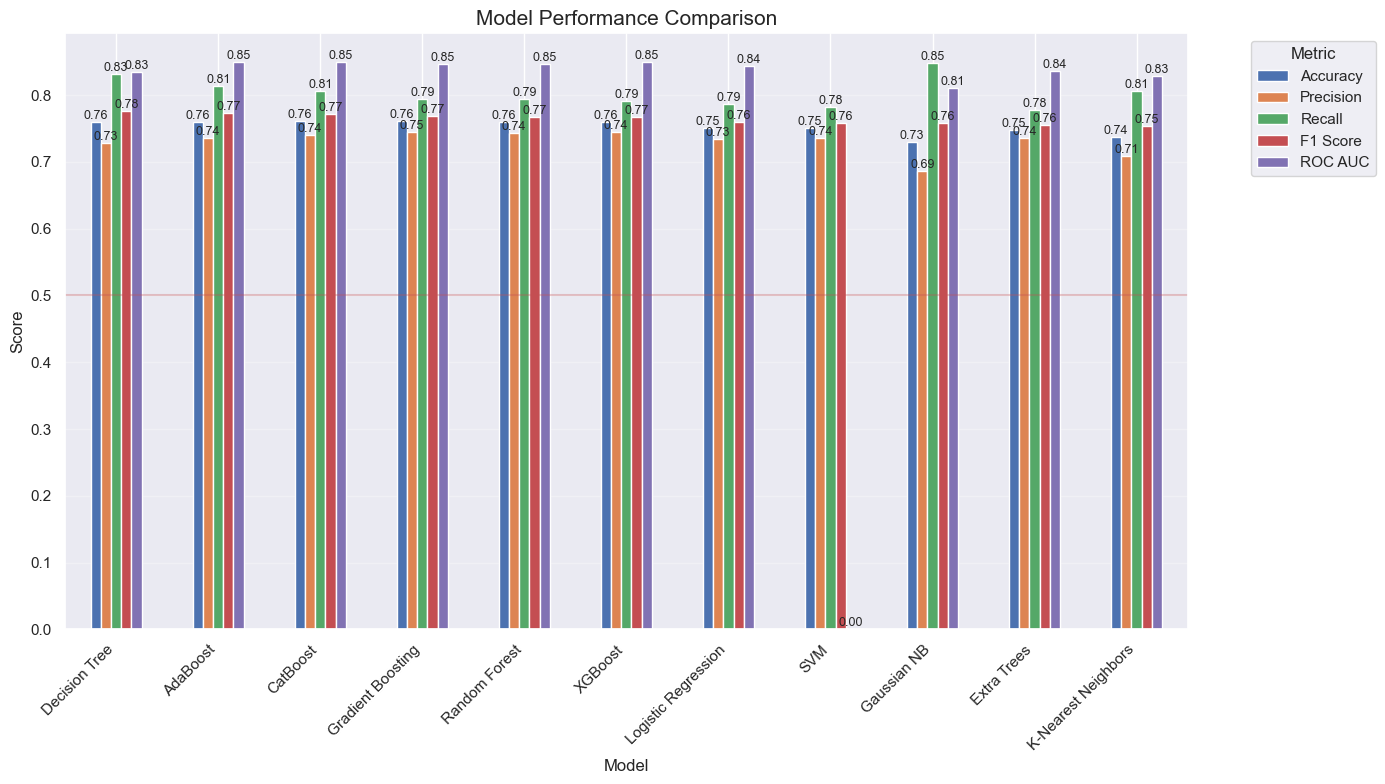

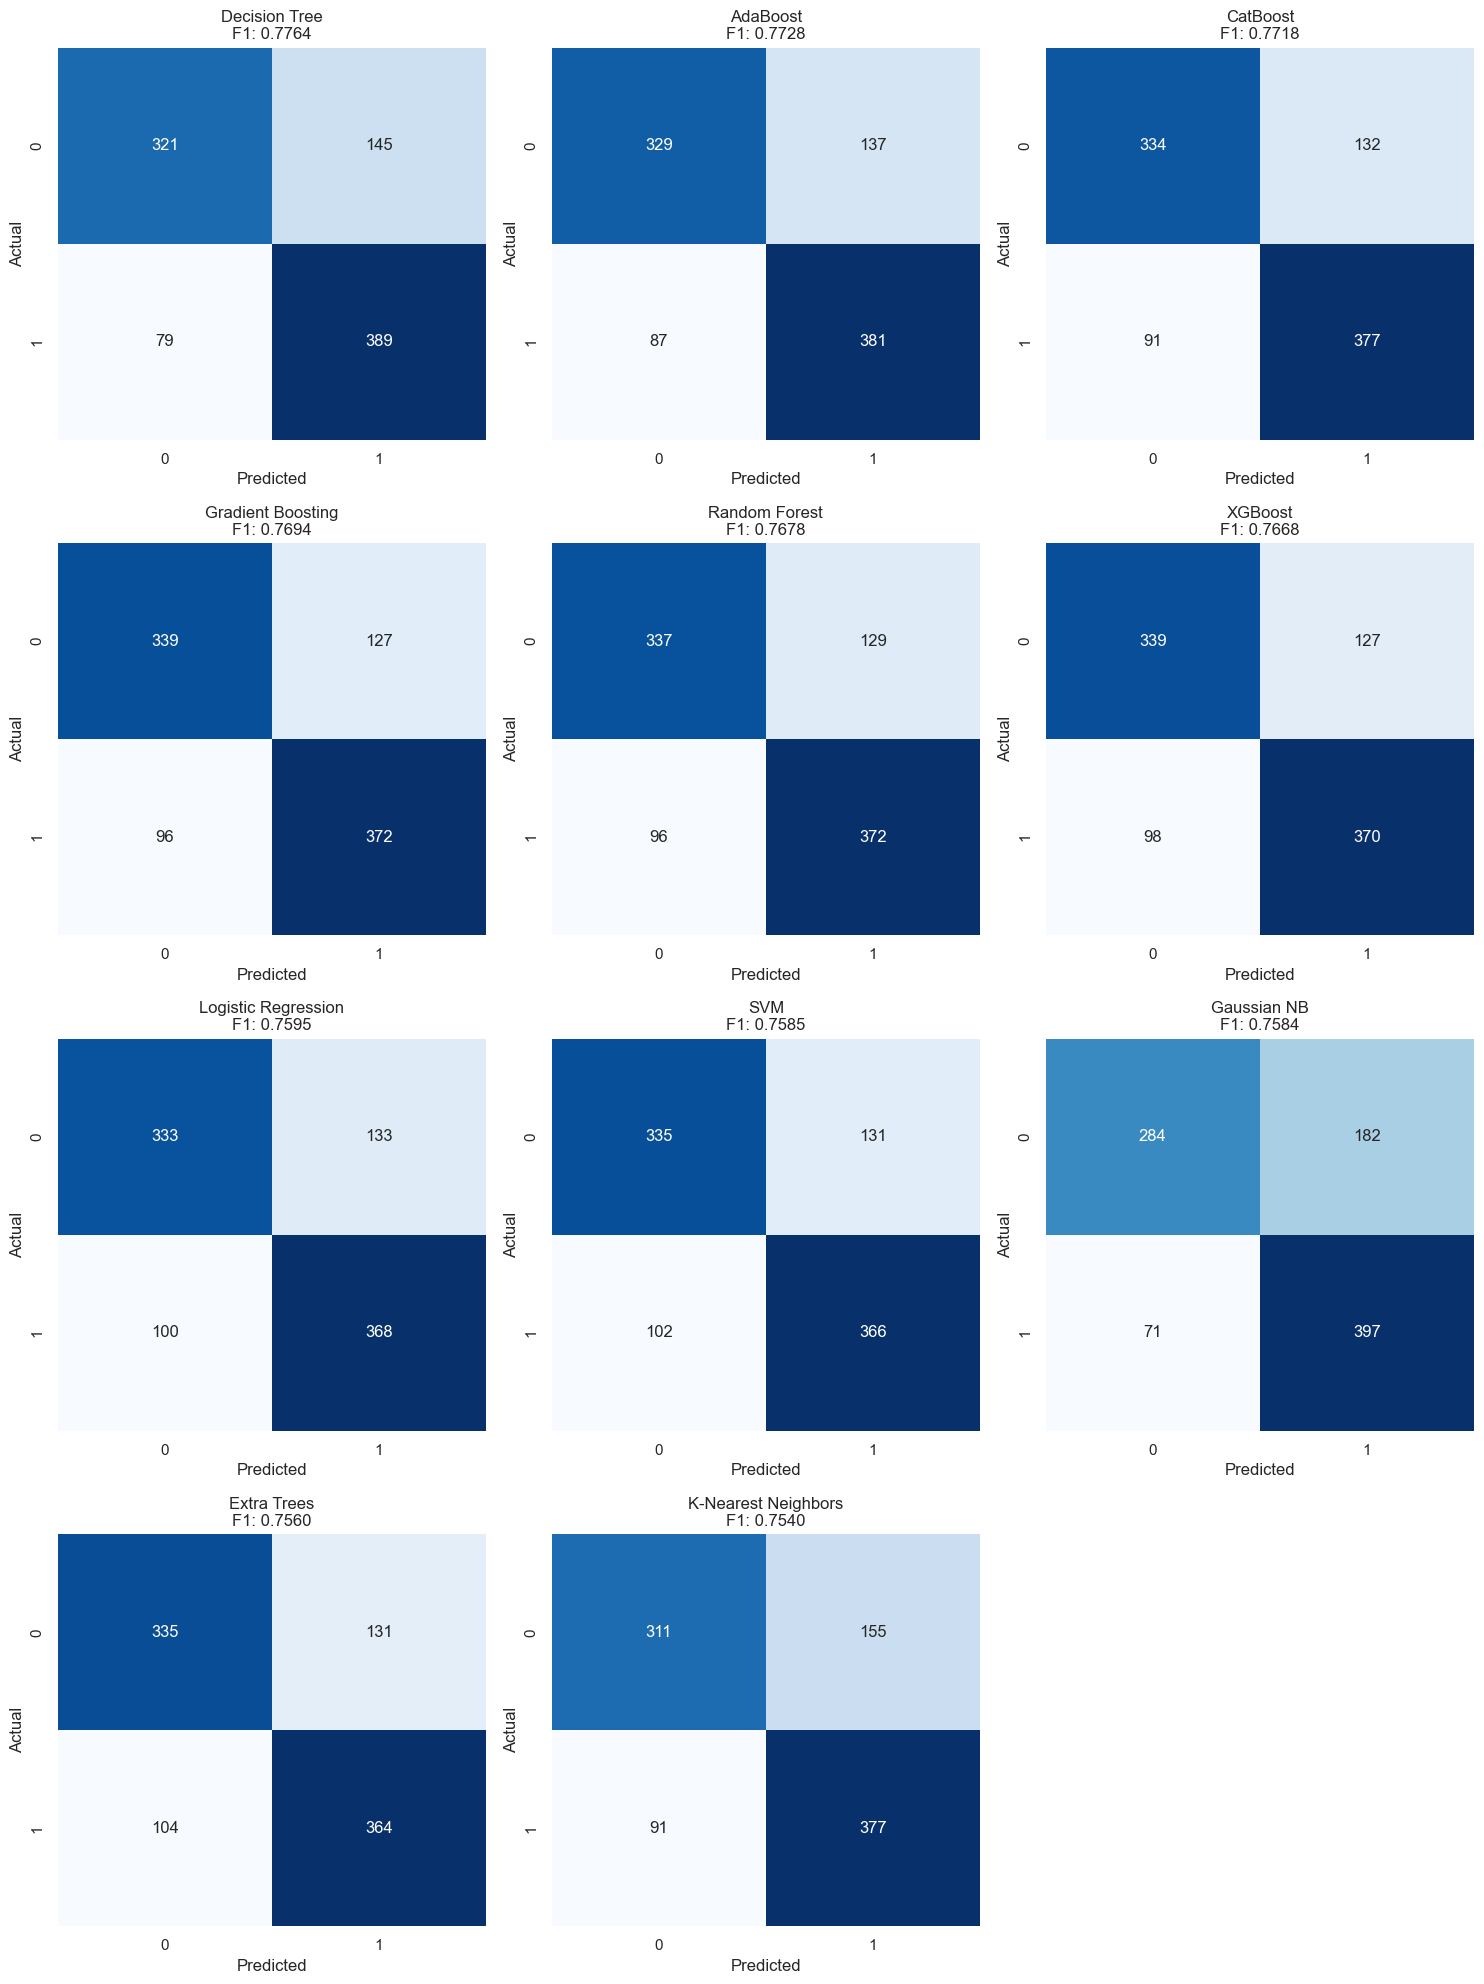

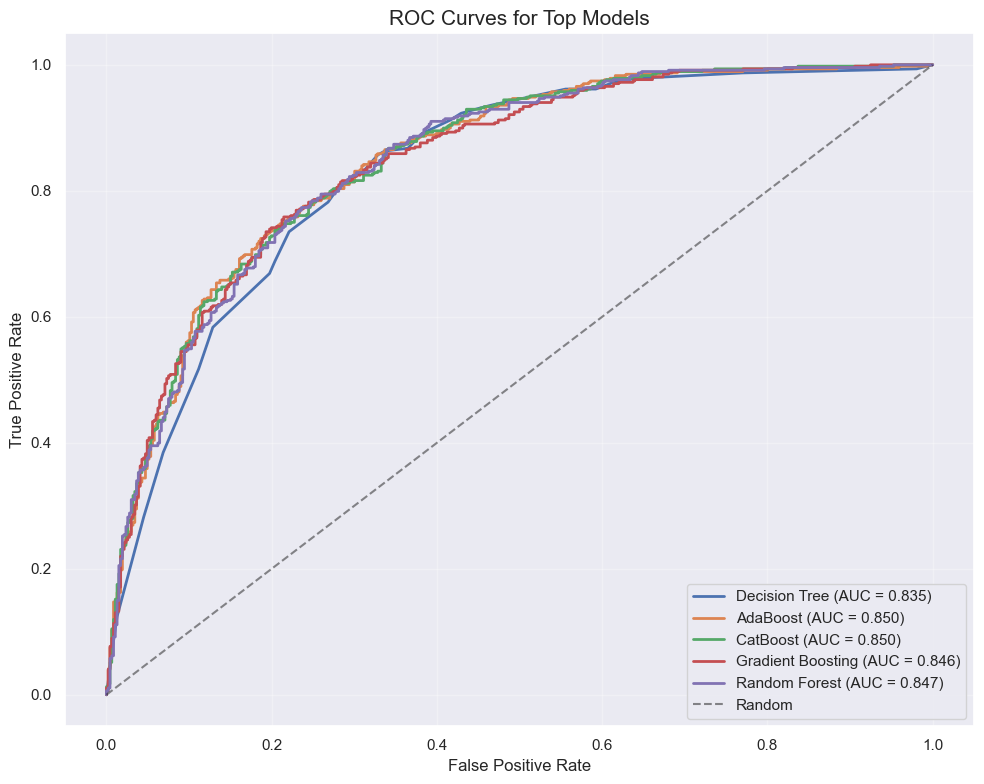

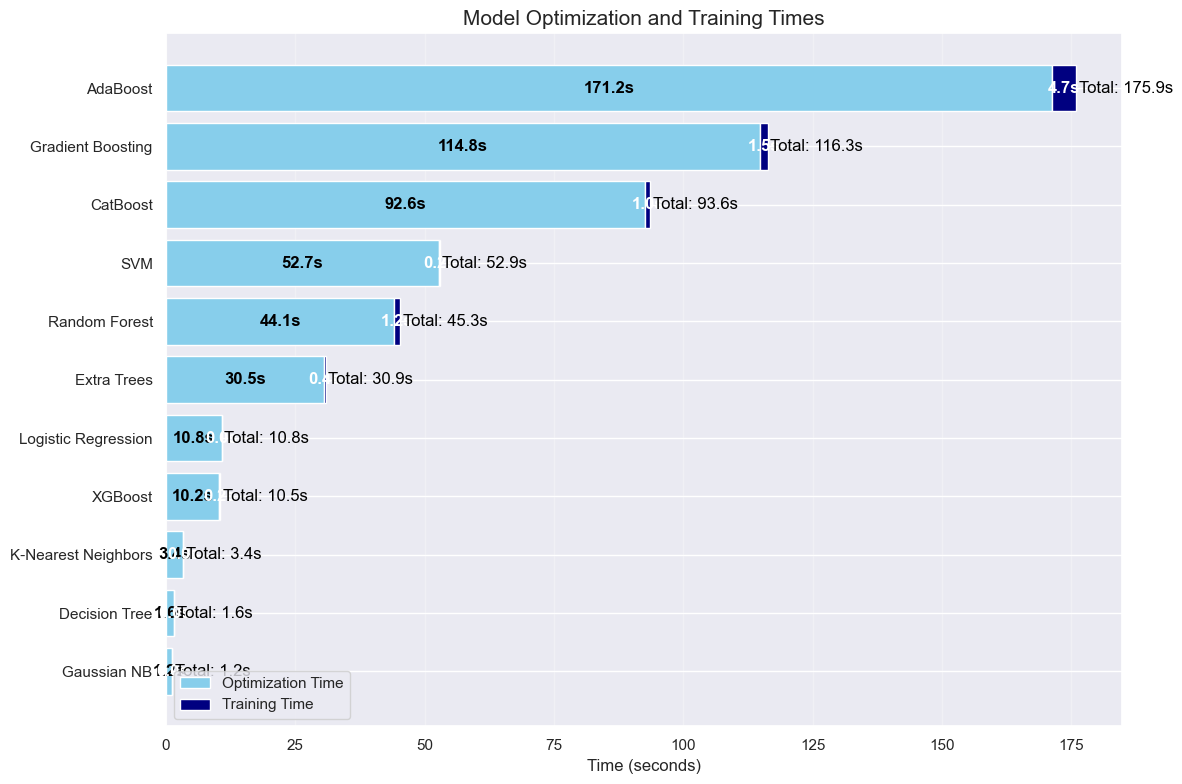

TypeError: plot_feature_importance() missing 1 required positional argument: 'y_train'

In [122]:
results, model_performance, best_model_name, best_model, optimization_studies = run_churn_prediction_pipeline(
    df_bal,                  # Your dataframe with churn data
    target_col='Churn',      # Target column name
    n_trials=10,             # Number of hyperparameter trials per model
    timeout=600,             # Maximum seconds per model optimization
    cv=5,                    # Number of cross-validation folds
    metric='f1'              # Metric to optimize
)


Current Model Rankings (by F1 Score):


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,Training Time (s),Optimization Time (s)
6,XGBoost,0.768489,0.737240,0.835118,0.783133,0.845314,0.204997,11.504002
2,Random Forest,0.765273,0.729630,0.843683,0.782522,0.839773,0.918512,39.957997
1,Decision Tree,0.758842,0.714539,0.862955,0.781765,0.813946,0.010991,1.598008
4,Gradient Boosting,0.767417,0.737643,0.830835,0.781470,0.840781,0.757510,140.753000
10,SVM,0.755627,0.720074,0.837259,0.774257,NaN,0.264993,66.265015
7,CatBoost,0.753483,0.715064,0.843683,0.774067,0.836009,0.835501,184.621500
8,Gaussian NB,0.744909,0.699130,0.860814,0.771593,0.798871,0.008990,1.334010
5,AdaBoost,0.748124,0.707885,0.845824,0.770732,0.807956,1.267999,157.287488
3,Extra Trees,0.758842,0.736328,0.807281,0.770174,0.839081,0.464514,26.650999
9,K-Nearest Neighbors,0.752412,0.720149,0.826552,0.769691,0.823883,0.012000,3.942000



All models optimized and trained successfully!
Best model: XGBoost (F1=0.7831)

=== STAGE 3: VISUALIZATION ===
Generating model comparison charts...


Generating visualizations:   0%|          | 0/6 [00:00<?, ?chart/s]

<Figure size 1400x1000 with 0 Axes>

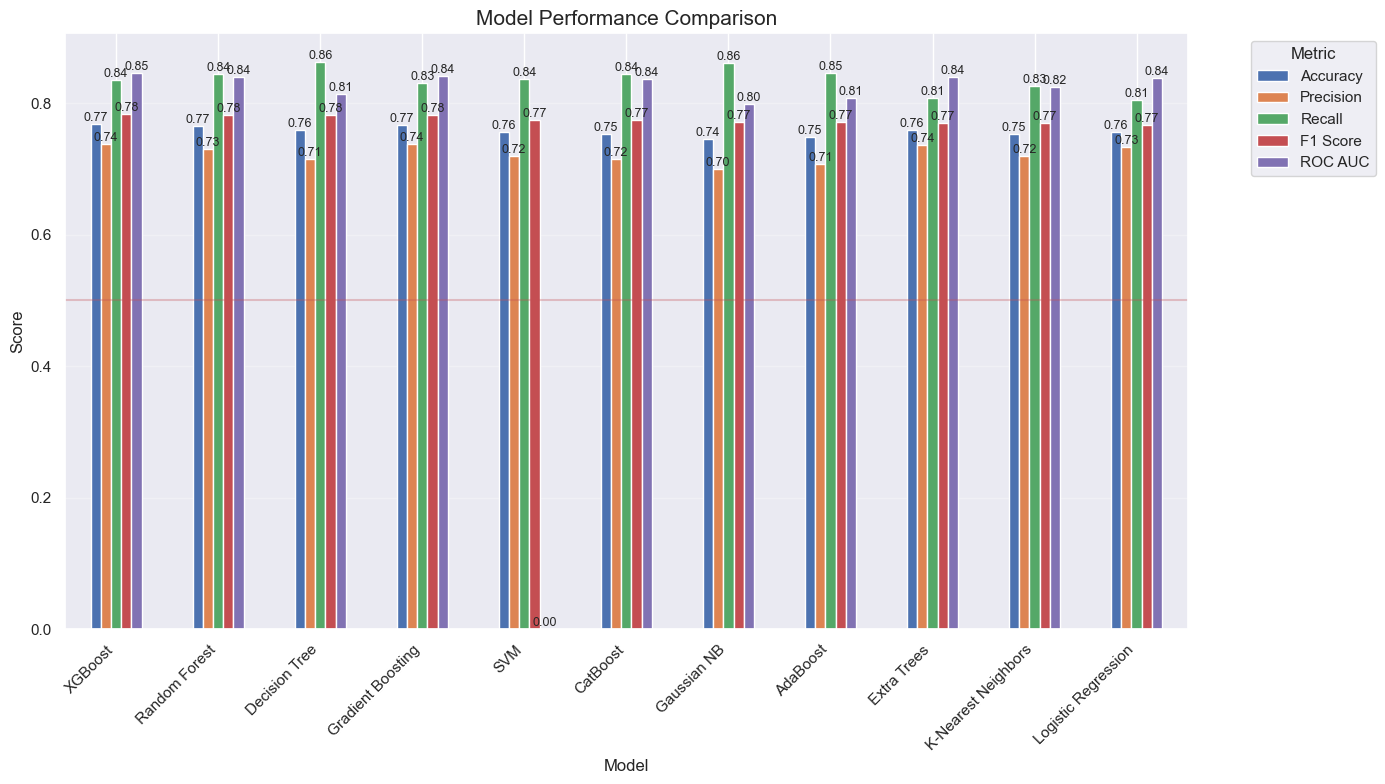

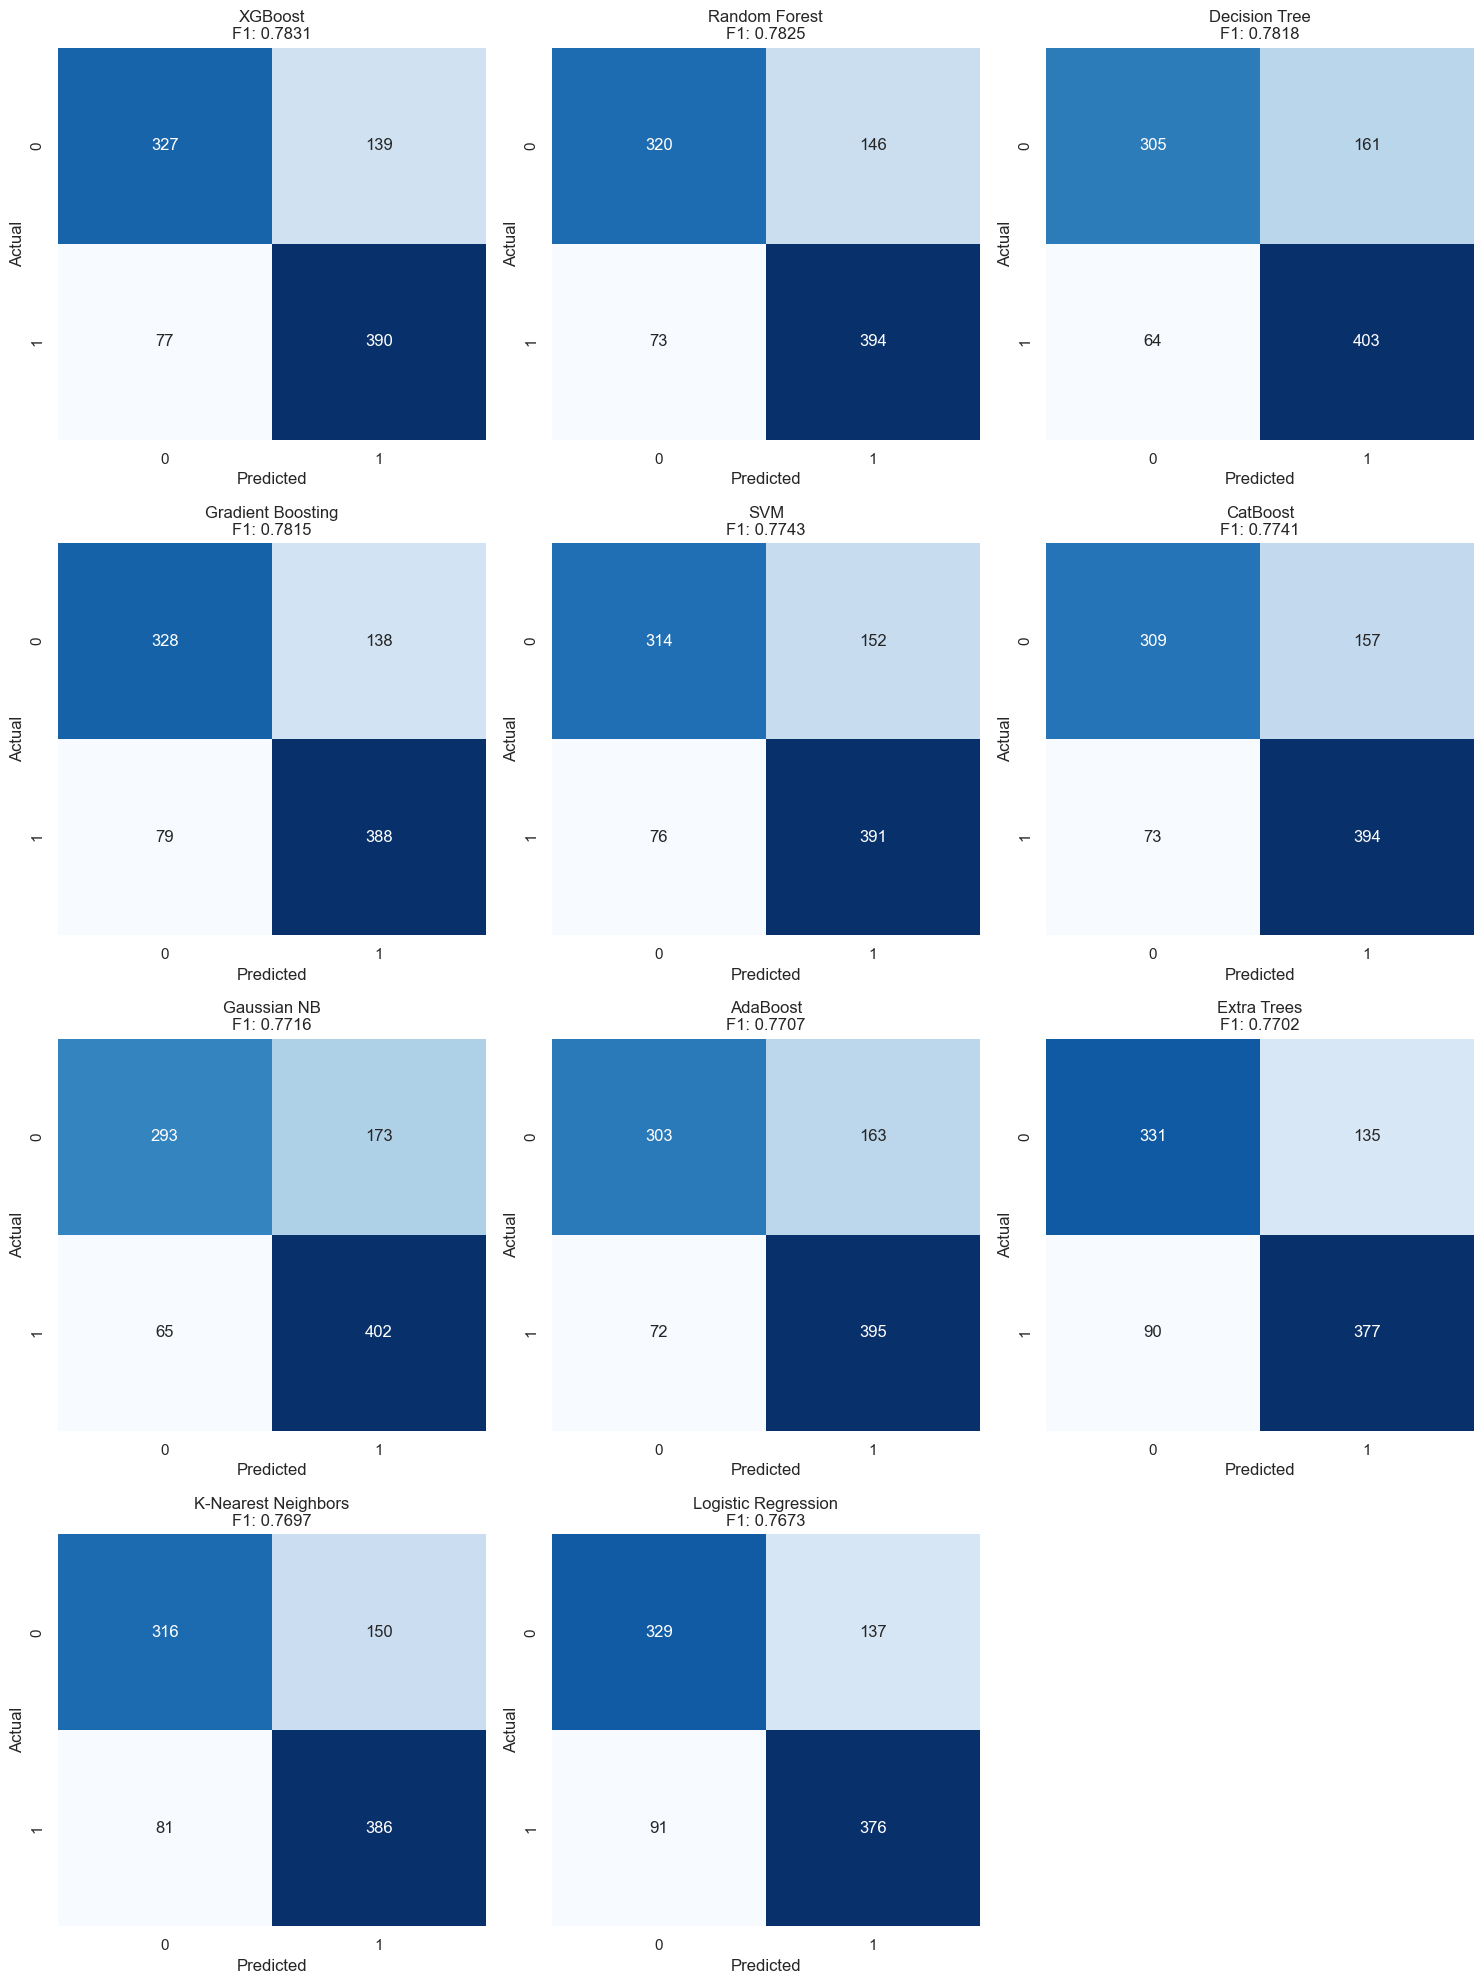

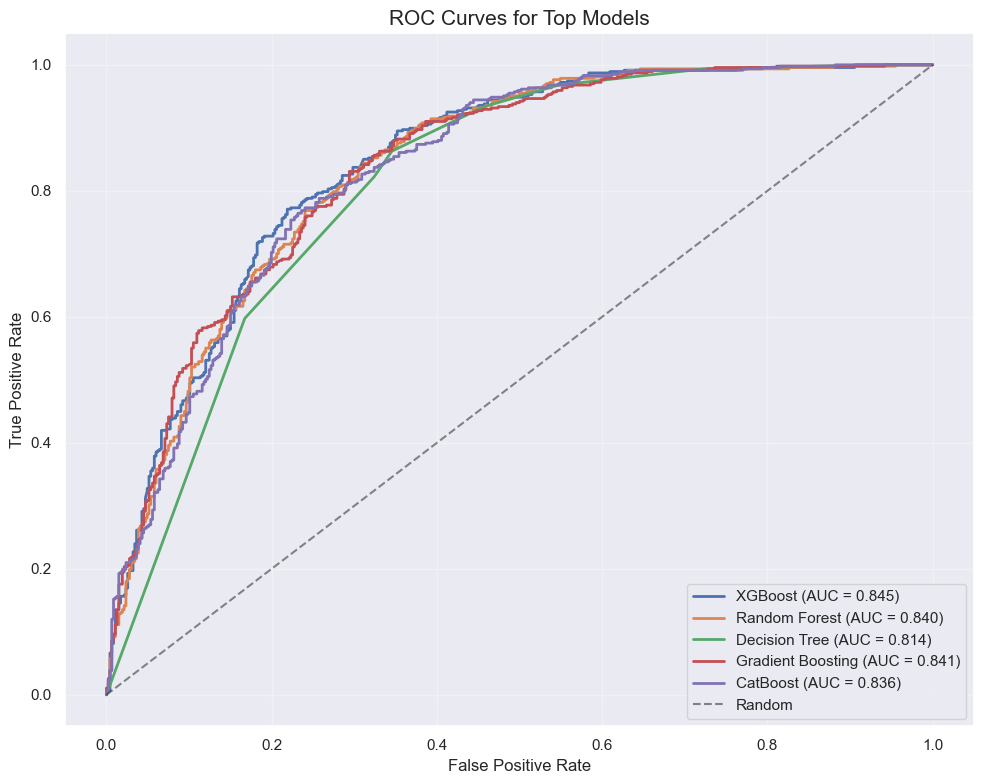

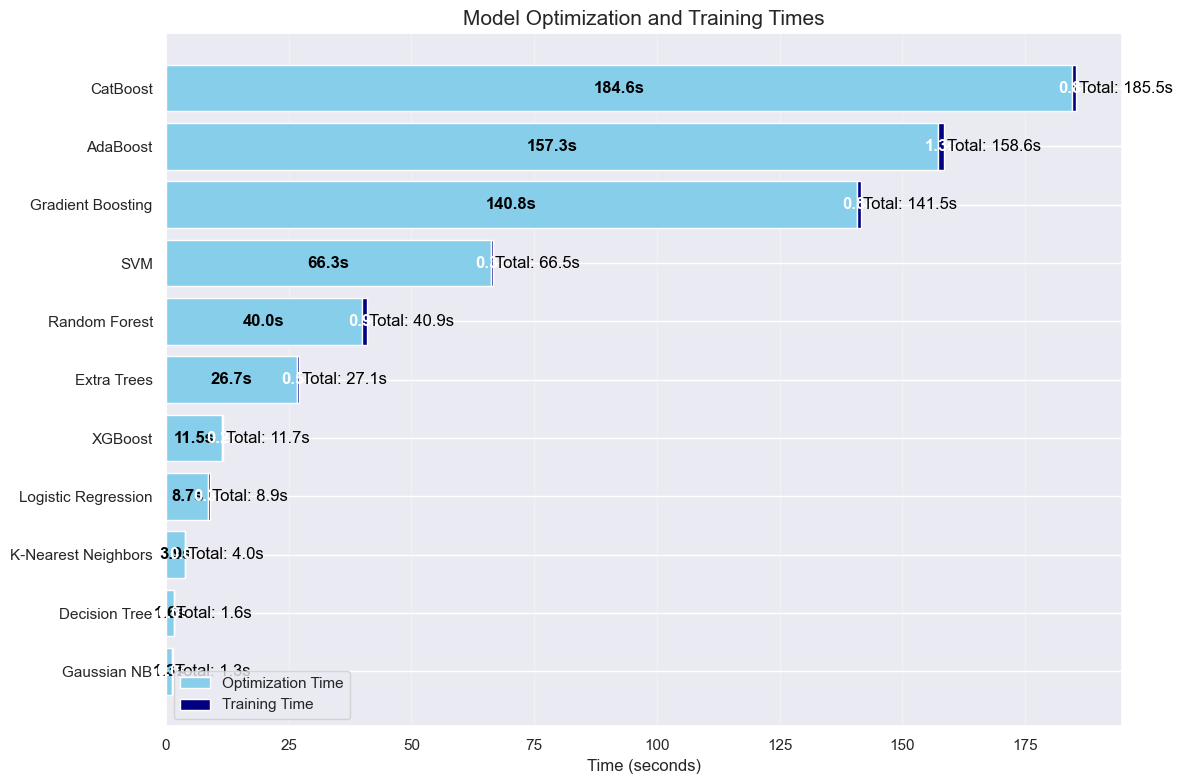

TypeError: plot_feature_importance() missing 1 required positional argument: 'y_train'

In [123]:
results_2, model_performance_2, best_model_name_2, best_model_2, optimization_studies_2 = run_churn_prediction_pipeline(
    df_su,                  # Your dataframe with churn data
    target_col='Churn',      # Target column name
    n_trials=10,             # Number of hyperparameter trials per model
    timeout=600,             # Maximum seconds per model optimization
    cv=5,                    # Number of cross-validation folds
    metric='f1'              # Metric to optimize
)


Current Model Rankings (by F1 Score):


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,Training Time (s),Optimization Time (s)
0,Logistic Regression,0.802048,0.644068,0.569593,0.604545,0.839579,0.405996,9.013274
6,XGBoost,0.803185,0.649383,0.563169,0.603211,0.845077,0.191501,13.235998
10,SVM,0.800910,0.645885,0.554604,0.596774,NaN,0.570000,140.931908
7,CatBoost,0.804892,0.670330,0.522484,0.587244,0.843687,1.202503,116.889998
8,Gaussian NB,0.681456,0.447339,0.845824,0.585185,0.810731,0.014510,1.756500
9,K-Nearest Neighbors,0.783845,0.596882,0.573876,0.585153,0.824397,0.011997,6.330503
4,Gradient Boosting,0.795222,0.636132,0.535332,0.581395,0.836307,1.372002,153.645499
1,Decision Tree,0.796359,0.643799,0.522484,0.576832,0.821549,0.034504,2.466988
5,AdaBoost,0.795222,0.639687,0.524625,0.576471,0.838045,5.899007,270.258499
3,Extra Trees,0.795222,0.644205,0.511777,0.570406,0.834026,0.357511,38.558499



All models optimized and trained successfully!
Best model: Logistic Regression (F1=0.6045)

=== STAGE 3: VISUALIZATION ===
Generating model comparison charts...


Generating visualizations:   0%|          | 0/6 [00:00<?, ?chart/s]

<Figure size 1400x1000 with 0 Axes>

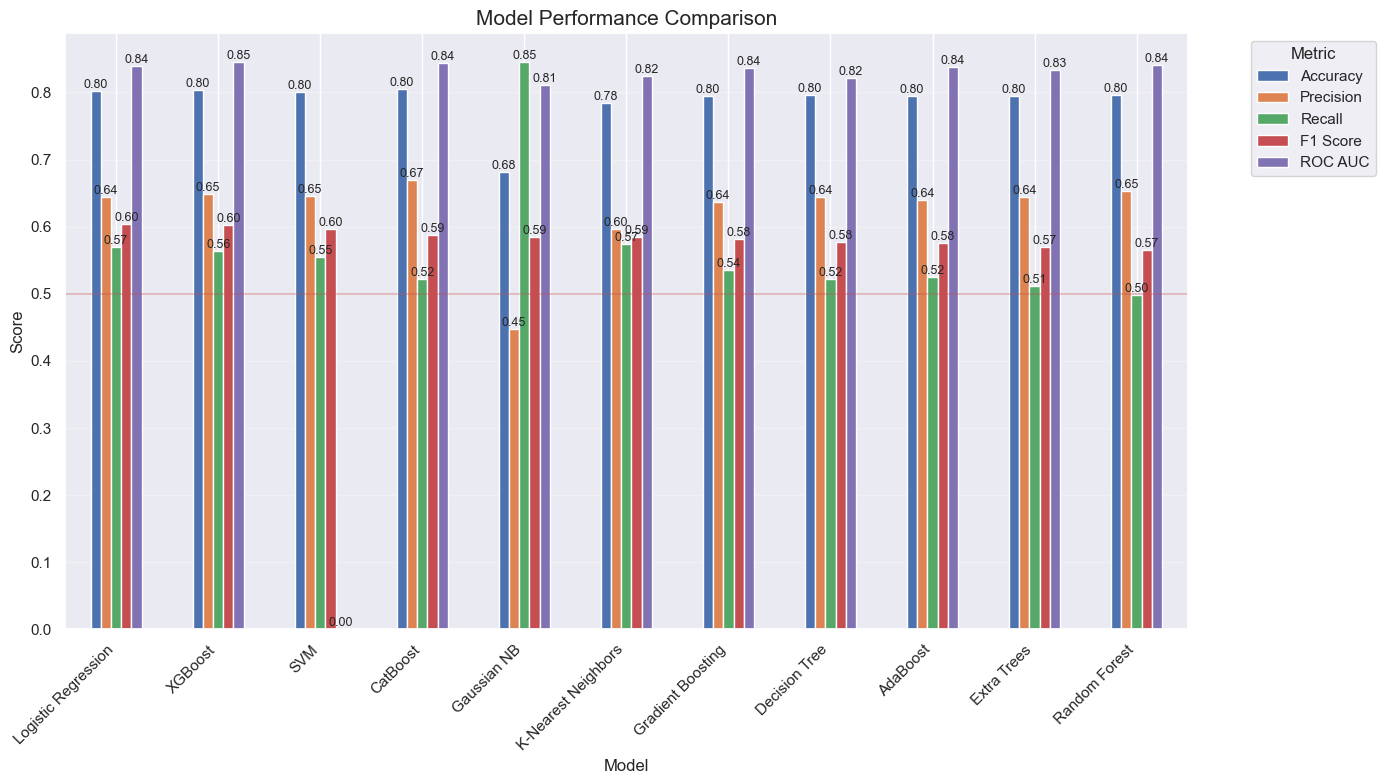

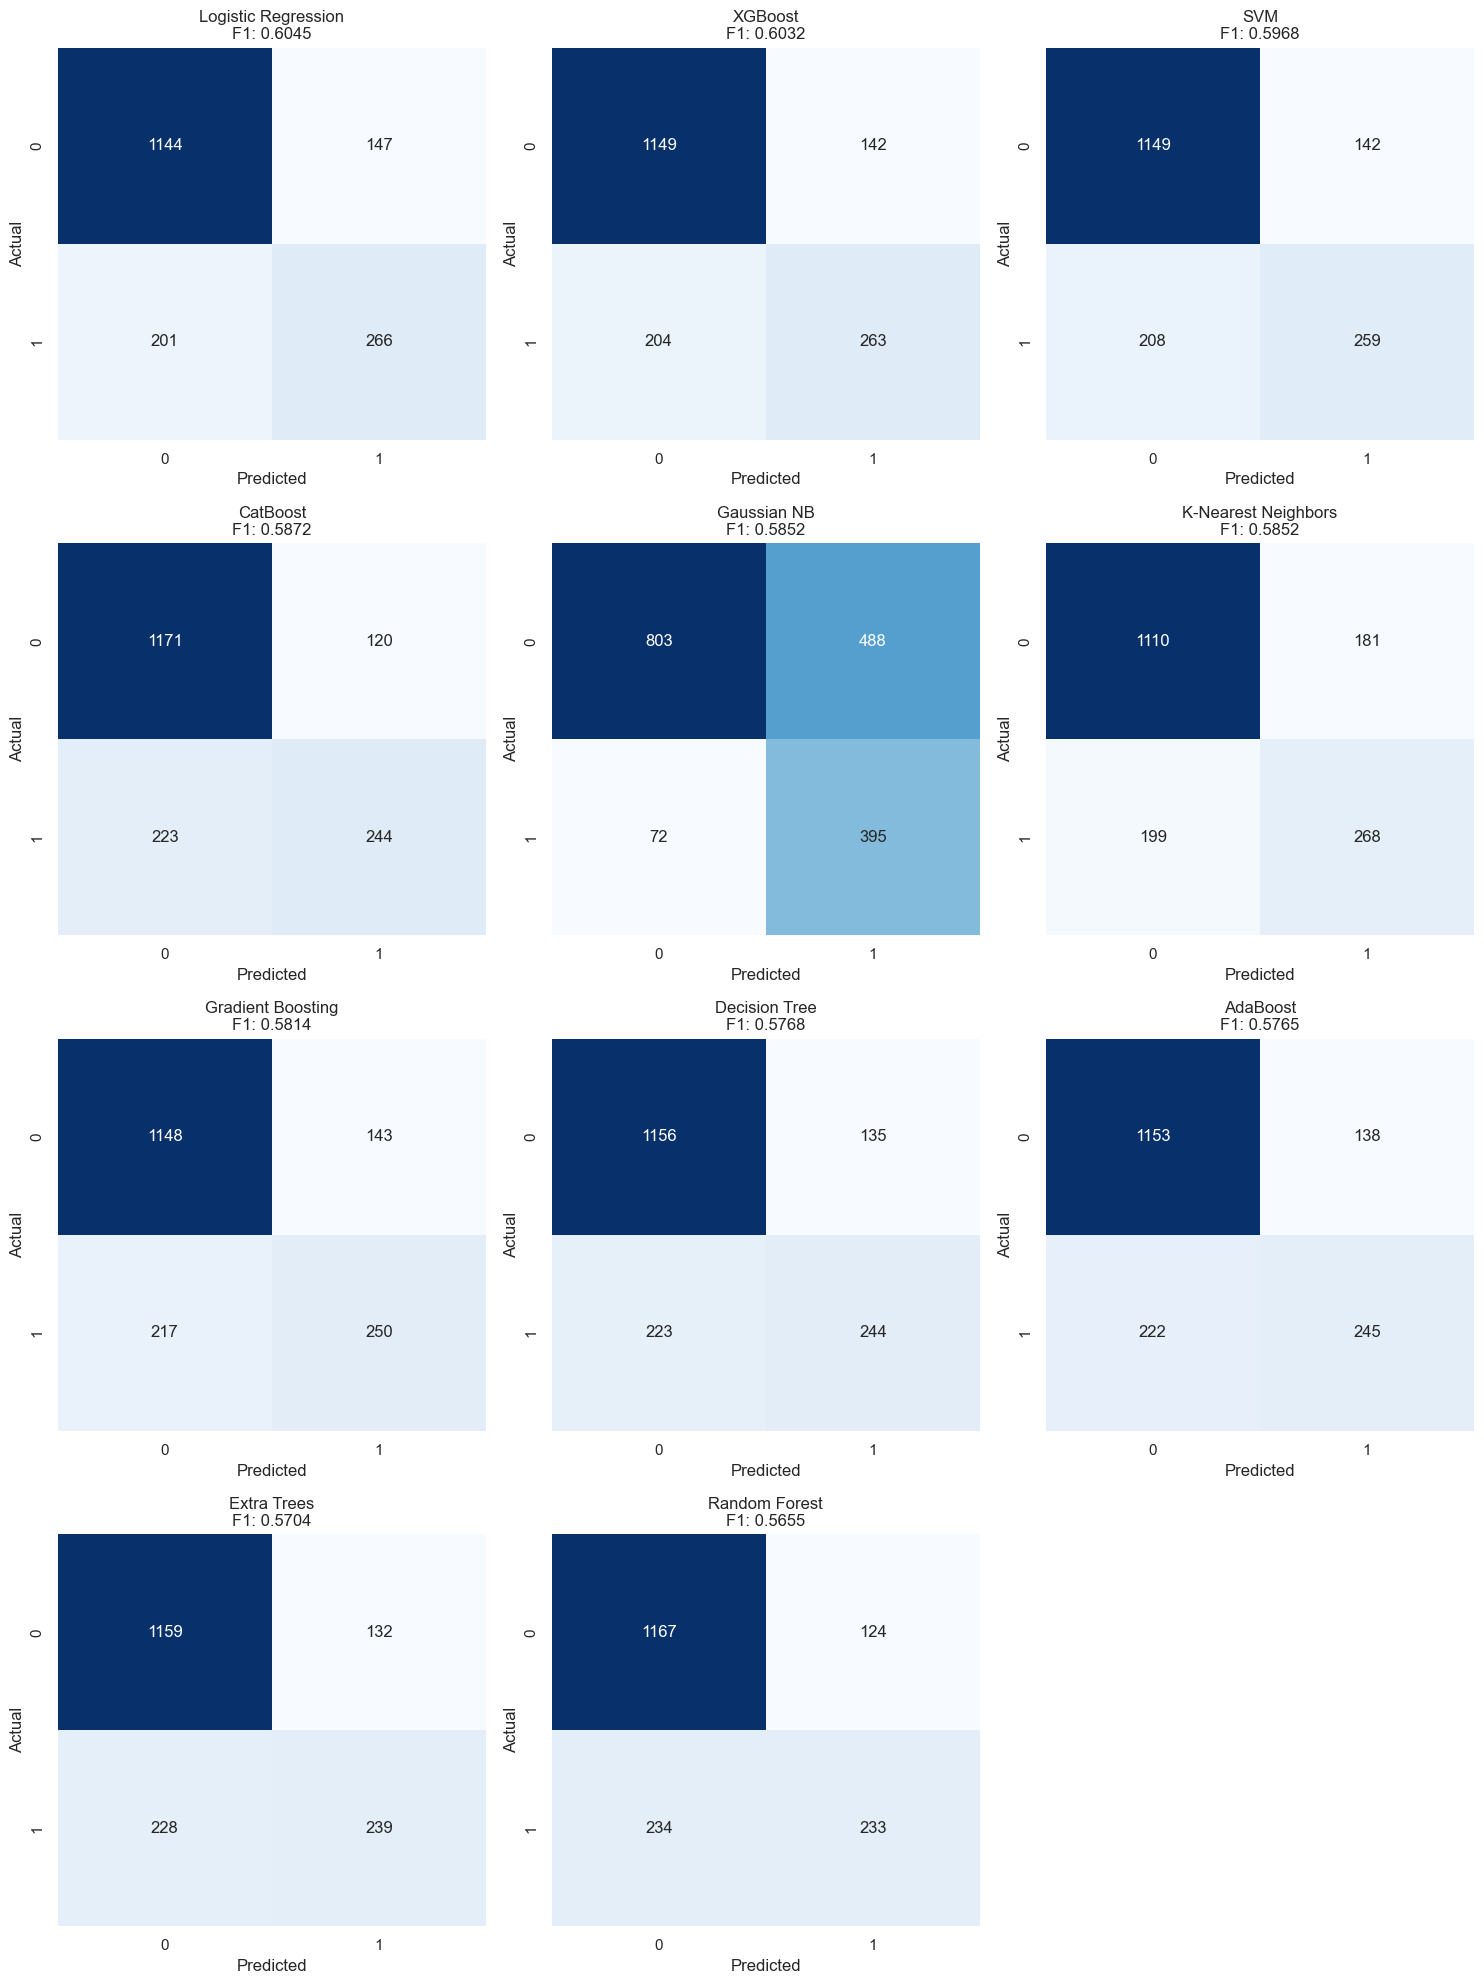

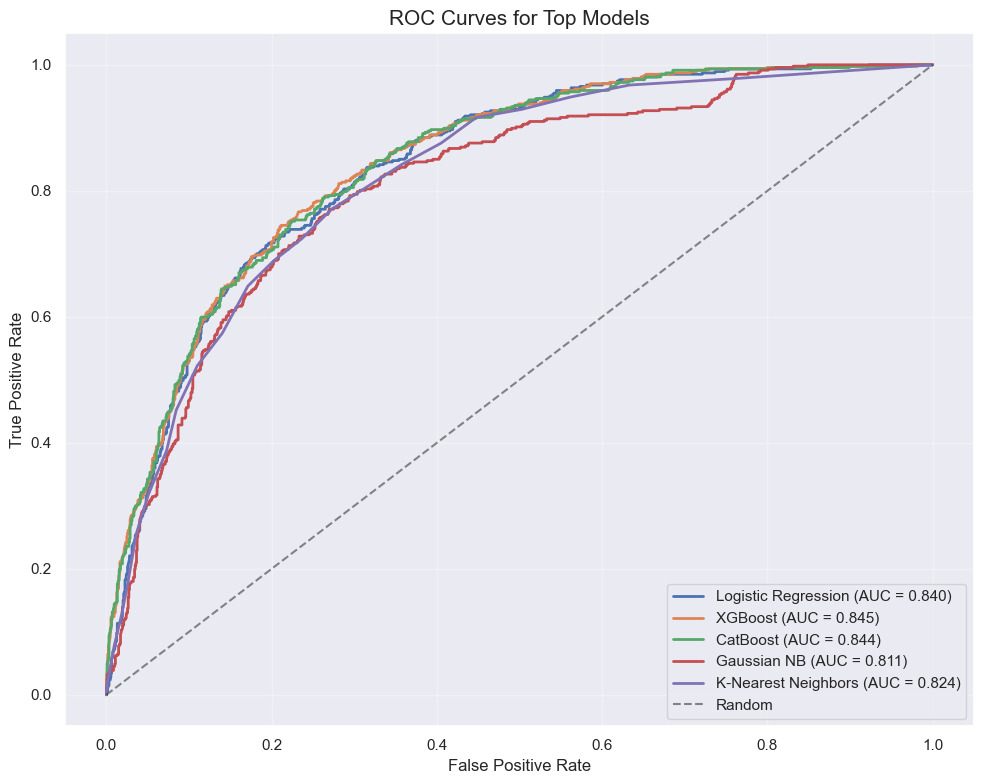

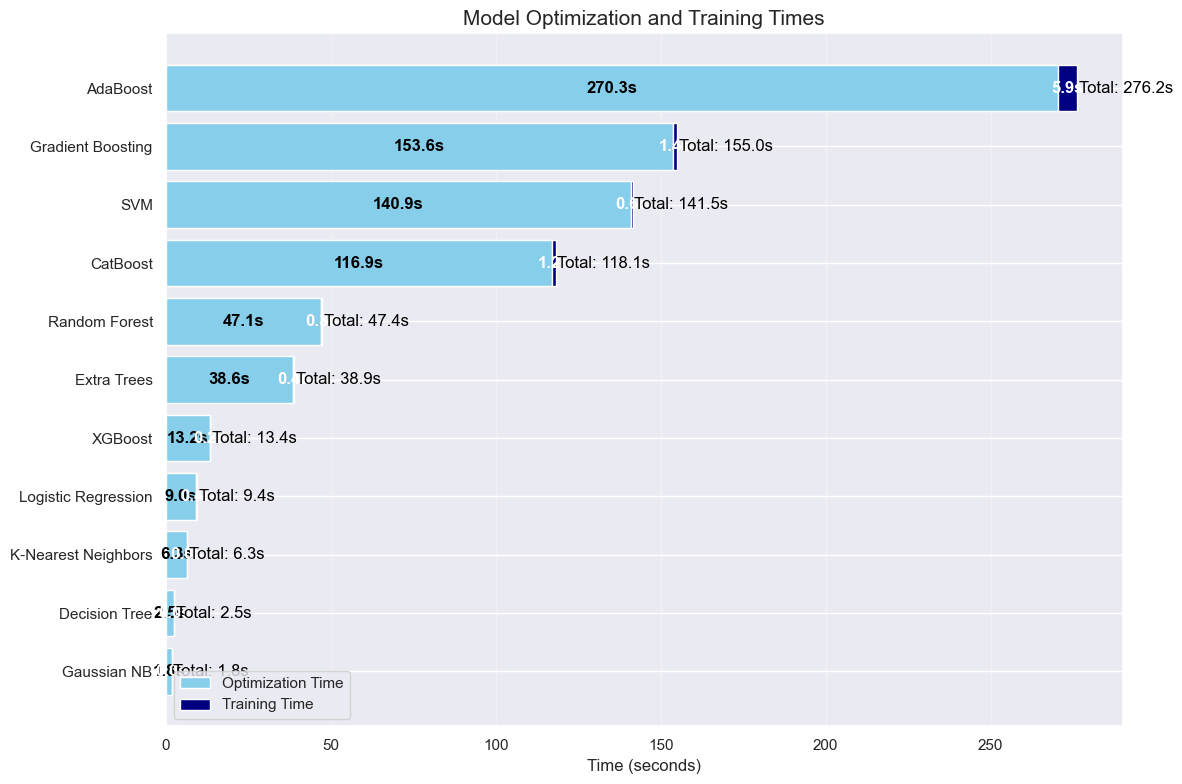

TypeError: plot_feature_importance() missing 1 required positional argument: 'y_train'

In [138]:
results_3, model_performance_3, best_model_name_3, best_model_3, optimization_studies_3 = run_churn_prediction_pipeline(
    df_full,                  # Your dataframe with churn data
    target_col='Churn',      # Target column name
    n_trials=10,             # Number of hyperparameter trials per model
    timeout=600,             # Maximum seconds per model optimization
    cv=5,                    # Number of cross-validation folds
    metric='f1'              # Metric to optimize
)

In [124]:
print(f"best params for DT: {optimization_studies['Decision Tree'].best_params}")
print(f"best params for AdaBoost: {optimization_studies['AdaBoost'].best_params}")
print(f"best params for Gaussian NB: {optimization_studies['Gaussian NB'].best_params}")
print(f"best params for Extra Trees: {optimization_studies['Extra Trees'].best_params}")

best params for DT: {'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 7, 'criterion': 'entropy'}
best params for AdaBoost: {'n_estimators': 283, 'learning_rate': 0.0626825674578868, 'algorithm': 'SAMME.R'}
best params for Gaussian NB: {'var_smoothing': 2.1665592871613477e-09}
best params for Extra Trees: {'n_estimators': 357, 'max_depth': 17, 'min_samples_split': 11, 'min_samples_leaf': 20, 'max_features': 'sqrt'}


In [144]:
optimization_studies['XGBoost'].best_params

{'n_estimators': 147,
 'learning_rate': 0.01846764007865345,
 'max_depth': 8,
 'min_child_weight': 7,
 'subsample': 0.9476113520683636,
 'colsample_bytree': 0.8912727137664205,
 'gamma': 1.6551366222967723}

### Decision Tree for Insights

In [116]:
X_train, X_test, y_train, y_test, numeric_features, preprocessor = prepare_data_for_modeling(df_su, target_col='Churn', test_size=0.25, random_state=42)

In [117]:
numeric_features

['tenure', 'MonthlyCharges', 'TotalCharges']

In [119]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['tenure', 'MonthlyCharges', 'TotalCharges'])])

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.inspection import permutation_importance

# Define function to implement and evaluate decision tree
def implement_decision_tree(X_train, X_test, y_train, y_test, feature_names=None, class_names=None):
    """
    Implement and evaluate a decision tree with specified hyperparameters
    
    Parameters:
    -----------
    X_train, X_test : arrays or DataFrames
        Training and testing feature data
    y_train, y_test : arrays or Series
        Training and testing target data
    feature_names : list, optional
        Names of features for visualization
    class_names : list, optional
        Names of classes for visualization
    
    Returns:
    --------
    tuple
        (model, y_pred, y_pred_proba)
    """
    # Set hyperparameters
    params = {
        'max_depth': 7, 
        'min_samples_split': 7, 
        'min_samples_leaf': 7, 
        'criterion': 'entropy',
        'random_state': 42  # For reproducibility
    }
    
    # Convert to numpy if needed
    X_train_np = X_train.values if hasattr(X_train, 'values') else X_train
    X_test_np = X_test.values if hasattr(X_test, 'values') else X_test
    y_train_np = y_train.values if hasattr(y_train, 'values') else y_train
    y_test_np = y_test.values if hasattr(y_test, 'values') else y_test
    
    # If feature_names not provided, get from DataFrame
    if feature_names is None and hasattr(X_train, 'columns'):
        feature_names = list(X_train.columns)
    
    # Initialize and train the model
    dt_model = DecisionTreeClassifier(**params)
    dt_model.fit(X_train_np, y_train_np)
    
    # Make predictions
    y_pred = dt_model.predict(X_test_np)
    y_pred_proba = dt_model.predict_proba(X_test_np)[:, 1]
    
    # Evaluate the model
    print("Model Performance:")
    print("-----------------")
    print(f"Accuracy: {dt_model.score(X_test_np, y_test_np):.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test_np, y_pred))
    
    # Visualize decision tree
    visualize_tree(dt_model, feature_names, class_names)
    
    # Feature importance
    plot_feature_importance(dt_model, X_train_np, y_train_np, feature_names)
    
    # Decision paths analysis
    analyze_decision_paths(dt_model, X_test_np, y_test_np, feature_names)
    
    return dt_model, y_pred, y_pred_proba

def visualize_tree(model, feature_names=None, class_names=None):
    """Visualize decision tree structure"""
    plt.figure(figsize=(20, 12))
    plot_tree(model, 
              feature_names=feature_names, 
              class_names=class_names,
              filled=True, 
              rounded=True, 
              fontsize=10)
    plt.title("Decision Tree Visualization", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print text representation for deeper understanding
    print("\nText Representation of the Tree:")
    tree_text = export_text(model, feature_names=feature_names, show_weights=True)
    print(tree_text[:1000] + "..." if len(tree_text) > 1000 else tree_text)

def plot_feature_importance(model, X_train, y_train, feature_names=None):
    """Plot feature importance using multiple methods"""
    # Get feature importance from model
    importance = model.feature_importances_
    
    # Use permutation importance for a more robust measure
    perm_importance = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
    perm_importance_mean = perm_importance.importances_mean
    
    # Create DataFrame for visualization
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(X_train.shape[1])]
    
    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Model Importance': importance,
        'Permutation Importance': perm_importance_mean
    })
    
    # Sort by permutation importance
    feature_imp_df = feature_imp_df.sort_values('Permutation Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(16, 8))
    
    # Model-based importance
    sns.barplot(x='Model Importance', y='Feature', data=feature_imp_df, palette='viridis')
    plt.title('Model-based Feature Importance', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Print the top features
    print("\nTop Features by Model Importance:")
    for idx, row in feature_imp_df.sort_values('Model Importance', ascending=False).head(10).iterrows():
        print(f"{row['Feature']}: {row['Model Importance']:.4f}")
        
    print("\nTop Features by Permutation Importance:")
    for idx, row in feature_imp_df.head(10).iterrows():
        print(f"{row['Feature']}: {row['Permutation Importance']:.4f}")

def analyze_decision_paths(model, X_test, y_test, feature_names=None):
    """Analyze decision paths in the tree"""
    # Get node indicator matrix
    node_indicator = model.decision_path(X_test)
    
    # Get leaf node IDs
    leaf_id = model.apply(X_test)
    
    # Get feature thresholds and indices
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    
    # Count samples per leaf node
    leaf_samples = {leaf: np.sum(leaf_id == leaf) for leaf in np.unique(leaf_id)}
    
    # Sort leaves by sample count
    sorted_leaves = sorted(leaf_samples.items(), key=lambda x: x[1], reverse=True)
    
    print("\nDecision Path Analysis:")
    print("----------------------")
    print(f"Total number of leaves: {len(leaf_samples)}")
    print(f"Top 5 most populated leaves:")
    
    for i, (leaf, count) in enumerate(sorted_leaves[:5]):
        print(f"\nLeaf {leaf}: {count} samples")
        
        # Get one sample that ends in this leaf
        sample_id = np.where(leaf_id == leaf)[0][0]
        
        # Get the path for this sample
        node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                          node_indicator.indptr[sample_id + 1]]
        
        # Print the decision path
        print(f"Example decision path to reach this leaf:")
        for node_id in node_index:
            # Continue to the next node if it's the leaf node
            if node_id == leaf:
                continue
                
            # Define feature name
            if feature_names is not None and feature[node_id] != -2:
                feature_name = feature_names[feature[node_id]]
            else:
                feature_name = f"feature {feature[node_id]}"
                
            # Check if sample goes left or right at this node (using numpy array indexing)
            if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
                threshold_sign = "<="
            else:
                threshold_sign = ">"
                
            print(f"  Decision: {feature_name} {threshold_sign} {threshold[node_id]:.4f}")

Model Performance:
-----------------
Accuracy: 0.7503

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.68      0.73       466
         1.0       0.72      0.82      0.77       467

    accuracy                           0.75       933
   macro avg       0.76      0.75      0.75       933
weighted avg       0.76      0.75      0.75       933



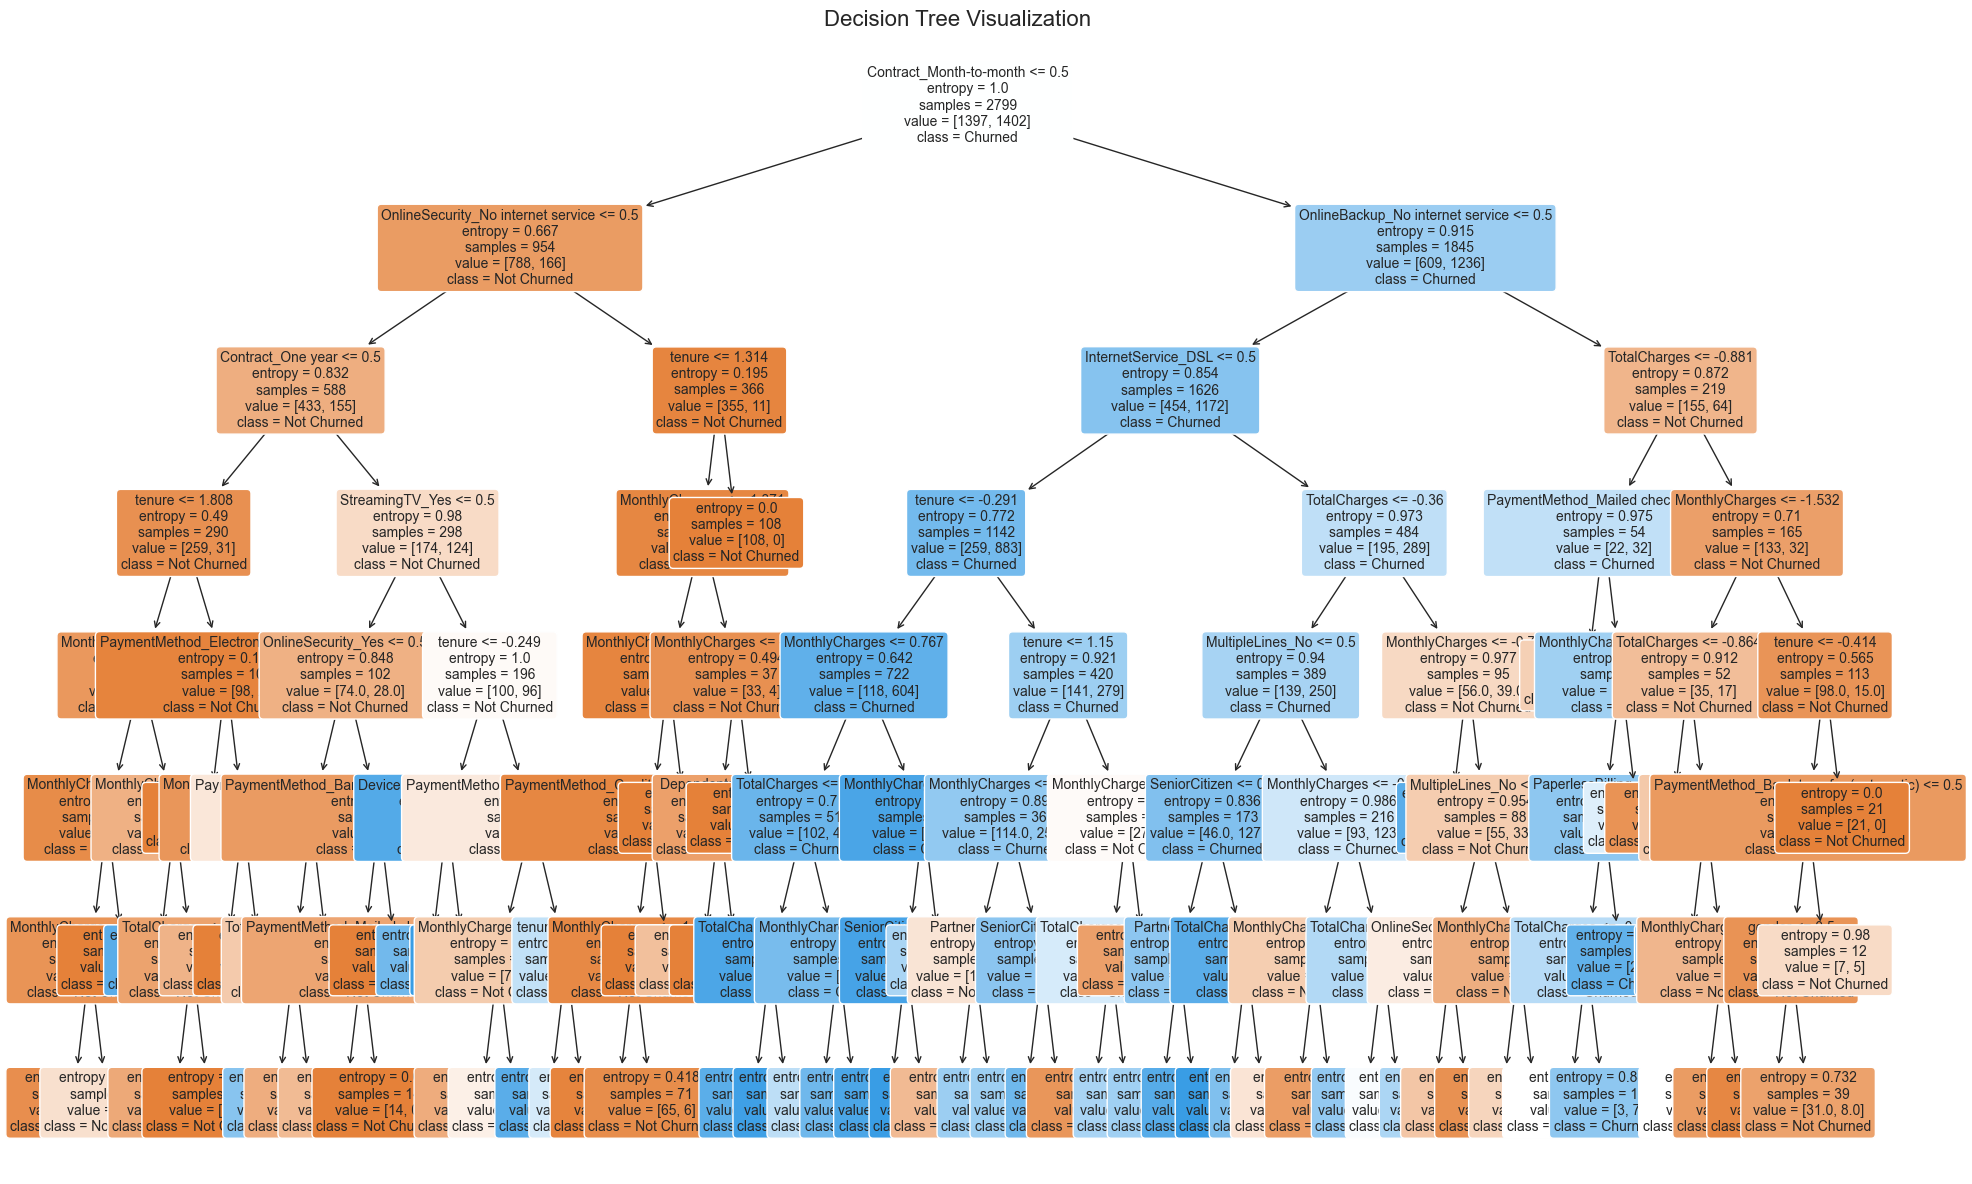


Text Representation of the Tree:
|--- Contract_Month-to-month <= 0.50
|   |--- OnlineSecurity_No internet service <= 0.50
|   |   |--- Contract_One year <= 0.50
|   |   |   |--- tenure <= 1.81
|   |   |   |   |--- MonthlyCharges <= 0.91
|   |   |   |   |   |--- MonthlyCharges <= 0.48
|   |   |   |   |   |   |--- MonthlyCharges <= 0.44
|   |   |   |   |   |   |   |--- weights: [57.00, 6.00] class: 0.0
|   |   |   |   |   |   |--- MonthlyCharges >  0.44
|   |   |   |   |   |   |   |--- weights: [4.00, 3.00] class: 0.0
|   |   |   |   |   |--- MonthlyCharges >  0.48
|   |   |   |   |   |   |--- weights: [47.00, 0.00] class: 0.0
|   |   |   |   |--- MonthlyCharges >  0.91
|   |   |   |   |   |--- MonthlyCharges <= 1.02
|   |   |   |   |   |   |--- weights: [1.00, 6.00] class: 1.0
|   |   |   |   |   |--- MonthlyCharges >  1.02
|   |   |   |   |   |   |--- TotalCharges <= 2.67
|   |   |   |   |   |   |   |--- weights: [44.00, 14.00] class: 0.0
|   |   |   |   |   |   |--- TotalCharges >  2

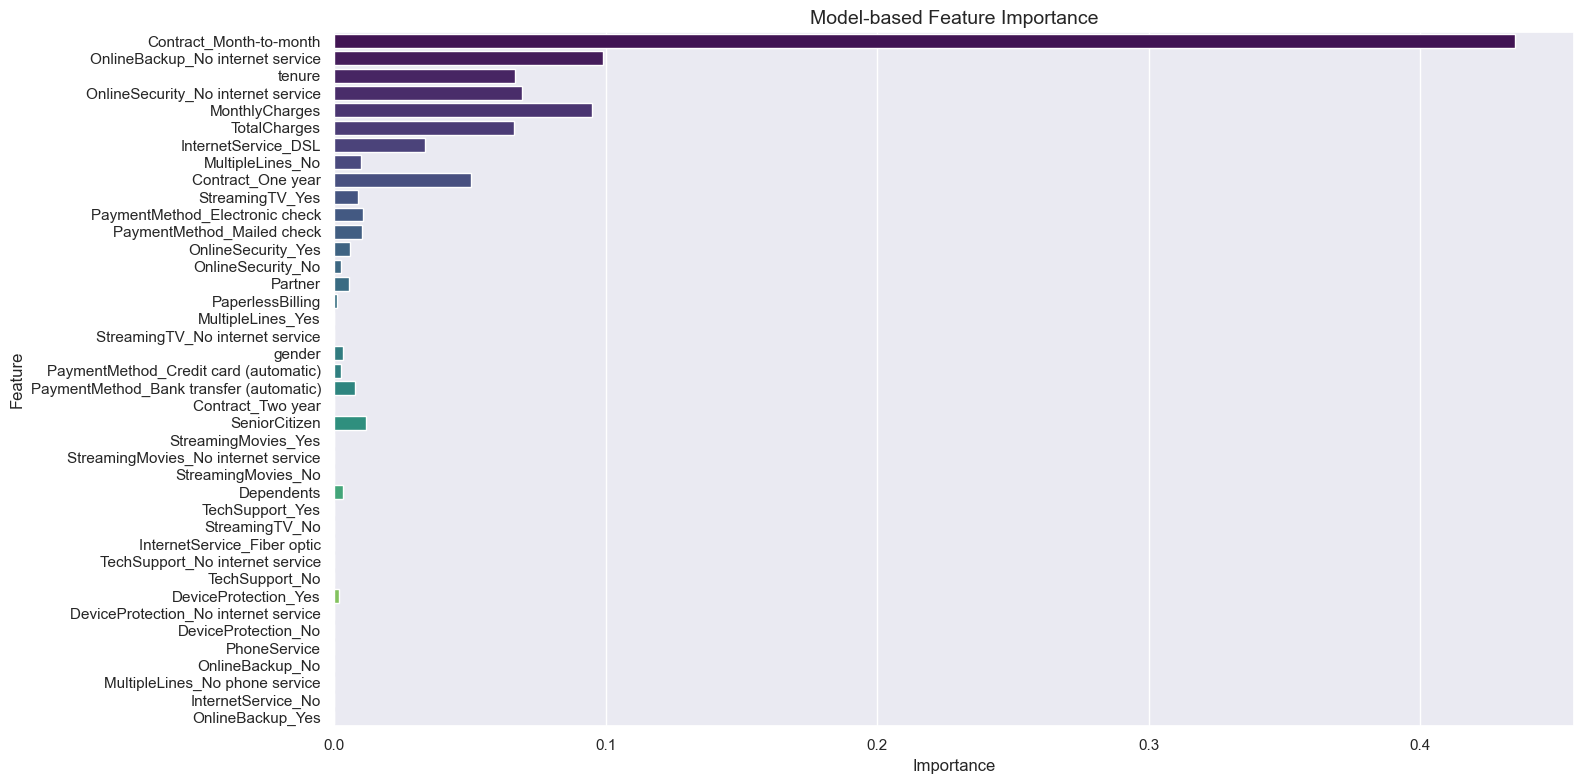


Top Features by Model Importance:
Contract_Month-to-month: 0.4349
OnlineBackup_No internet service: 0.0990
MonthlyCharges: 0.0951
OnlineSecurity_No internet service: 0.0692
tenure: 0.0667
TotalCharges: 0.0664
Contract_One year: 0.0505
InternetService_DSL: 0.0334
SeniorCitizen: 0.0117
PaymentMethod_Electronic check: 0.0107

Top Features by Permutation Importance:
Contract_Month-to-month: 0.1321
OnlineBackup_No internet service: 0.0860
tenure: 0.0660
OnlineSecurity_No internet service: 0.0350
MonthlyCharges: 0.0303
TotalCharges: 0.0275
InternetService_DSL: 0.0271
MultipleLines_No: 0.0137
Contract_One year: 0.0113
StreamingTV_Yes: 0.0073

Decision Path Analysis:
----------------------
Total number of leaves: 65
Top 5 most populated leaves:

Leaf 68: 109 samples
Example decision path to reach this leaf:
  Decision: Contract_Month-to-month > 0.5000
  Decision: OnlineBackup_No internet service <= 0.5000
  Decision: InternetService_DSL <= 0.5000
  Decision: tenure <= -0.2906
  Decision: Mont

In [148]:
dt_model, y_pred, y_pred_proba = implement_decision_tree(
    X_train, X_test, y_train, y_test, 
    feature_names=list(X_train.columns), 
    class_names=['Not Churned', 'Churned']
)

### XGBOOST

In [149]:
import joblib
from xgboost import XGBClassifier
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Save the Decision Tree model
joblib.dump(dt_model, 'decision_tree_model.joblib')
print("Decision Tree model saved successfully!")

# Handle data types for XGBoost
def prepare_data_for_xgboost(X):
    """Convert object dtypes to numeric for XGBoost"""
    X_processed = X.copy()
    
    # For each column with 'object' dtype
    for col in X_processed.select_dtypes(include=['object']).columns:
        # If the column contains categorical data, use label encoding
        if X_processed[col].nunique() < 10:  # Arbitrary threshold for categorical data
            le = LabelEncoder()
            X_processed[col] = le.fit_transform(X_processed[col])
        else:
            # For other object columns, try to convert to numeric
            X_processed[col] = pd.to_numeric(X_processed[col], errors='coerce')
            # Fill NA values that couldn't be converted
            X_processed[col] = X_processed[col].fillna(X_processed[col].mean() 
                             if not pd.isna(X_processed[col].mean()) else 0)
    
    return X_processed

# Process training and test data
X_train_xgb = prepare_data_for_xgboost(X_train)
X_test_xgb = prepare_data_for_xgboost(X_test)

# Verify data types
print("Data types after processing:")
print(X_train_xgb.dtypes.value_counts())

# XGBoost parameters
xgb_params = {
    'n_estimators': 147,
    'learning_rate': 0.01846764007865345,
    'max_depth': 8,
    'min_child_weight': 7,
    'subsample': 0.9476113520683636,
    'colsample_bytree': 0.8912727137664205,
    'gamma': 1.6551366222967723,
    'random_state': 42,  # For reproducibility
    'enable_categorical': True  # Enable categorical feature support
}

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(**xgb_params)
xgb_model.fit(X_train_xgb, y_train)

# Evaluate the XGBoost model
y_pred_xgb = xgb_model.predict(X_test_xgb)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_xgb)[:, 1]

print("\nXGBoost Model Performance:")
print("-----------------")
print(f"Accuracy: {xgb_model.score(X_test_xgb, y_test):.4f}")

# Print classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Save the XGBoost model
joblib.dump(xgb_model, 'xgboost_model.joblib')
print("XGBoost model saved successfully!")

# Optional: Compare the models
print("\nModel Comparison:")
print(f"Decision Tree Accuracy: {dt_model.score(X_test, y_test):.4f}")
print(f"XGBoost Accuracy: {xgb_model.score(X_test_xgb, y_test):.4f}")

Decision Tree model saved successfully!
Data types after processing:
int32      37
float64     3
Name: count, dtype: int64

XGBoost Model Performance:
-----------------
Accuracy: 0.7653

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.70      0.75       466
         1.0       0.73      0.84      0.78       467

    accuracy                           0.77       933
   macro avg       0.77      0.77      0.76       933
weighted avg       0.77      0.77      0.76       933

XGBoost model saved successfully!

Model Comparison:
Decision Tree Accuracy: 0.7503
XGBoost Accuracy: 0.7653


### Mixture Model

In [130]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


class ChurnEnsembleClassifier:
    """
    Ensemble classifier that combines multiple models with their optimized parameters.
    Creates a voting classifier with option for soft or hard voting.
    
    Parameters:
    -----------
    voting : str, default='soft'
        If 'hard', uses majority rule voting.
        If 'soft', predicts the class label based on the argmax of the sums of the predicted probabilities.
    weights : list or None, default=None
        Sequence of weights for each classifier in the ensemble. If None, uniform weights are used.
    preprocessor : ColumnTransformer or None, default=None
        The preprocessor used for scaling numeric features. If None, no preprocessing is applied.
    """
    
    def __init__(self, voting='soft', weights=None, preprocessor=None):
        self.voting = voting
        self.weights = weights
        self.preprocessor = preprocessor
        self.ensemble = None
        self.models = None
        self.individual_models = {}  # This will store fitted individual models
        self.feature_names = None
        
    def build(self):
        """
        Build the ensemble model with the optimized parameters.
        """
        # Create individual models with optimized parameters
        dt = DecisionTreeClassifier(
            max_depth=7, 
            min_samples_split=7, 
            min_samples_leaf=7, 
            criterion='entropy',
            random_state=42
        )
        
        ada = AdaBoostClassifier(
            n_estimators=283, 
            learning_rate=0.0626825674578868, 
            algorithm='SAMME.R',
            random_state=42
        )
        
        gnb = GaussianNB(
            var_smoothing=2.1665592871613477e-09
        )
        
        et = ExtraTreesClassifier(
            n_estimators=357, 
            max_depth=17, 
            min_samples_split=11, 
            min_samples_leaf=20, 
            max_features='sqrt',
            random_state=42
        )
        
        # Store model configurations for later
        self.models = {
            'decision_tree': dt,
            'adaboost': ada,
            'gaussian_nb': gnb,
            'extra_trees': et
        }
        
        # Create the voting classifier
        estimators = [
            ('decision_tree', dt),
            ('adaboost', ada),
            ('gaussian_nb', gnb),
            ('extra_trees', et)
        ]
        
        self.ensemble = VotingClassifier(
            estimators=estimators,
            voting=self.voting,
            weights=self.weights
        )
        
        return self
    
    def fit(self, X, y):
        """
        Fit the ensemble model to the training data.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Training features
        y : array-like of shape (n_samples,)
            Target values
        
        Returns:
        --------
        self : object
            Returns self.
        """
        # Store feature names if X is a DataFrame
        if isinstance(X, pd.DataFrame):
            self.feature_names = X.columns.tolist()
        
        # Prepare the data
        if self.preprocessor is not None:
            X_processed = self.preprocessor.transform(X)
            
            # If X_processed is a numpy array, convert it back to DataFrame
            if isinstance(X_processed, np.ndarray) and self.feature_names is not None:
                X_processed = pd.DataFrame(X_processed, columns=self.feature_names, index=X.index)
        else:
            X_processed = X
        
        # Fit the ensemble
        self.ensemble.fit(X_processed, y)
        
        # ALSO fit each individual model separately 
        # (this is what was missing in the original code)
        for name, model in self.models.items():
            # Create a copy of the model to fit individually
            model_copy = type(model)(**model.get_params())
            model_copy.fit(X_processed, y)
            self.individual_models[name] = model_copy
        
        return self
    
    def predict(self, X):
        """
        Predict class labels for X.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Samples
            
        Returns:
        --------
        array-like of shape (n_samples,)
            Predicted class labels
        """
        if self.preprocessor is not None:
            X_processed = self.preprocessor.transform(X)
            
            # If X_processed is a numpy array, convert it back to DataFrame
            if isinstance(X_processed, np.ndarray) and self.feature_names is not None:
                X_processed = pd.DataFrame(X_processed, columns=self.feature_names, index=X.index)
        else:
            X_processed = X
            
        return self.ensemble.predict(X_processed)
    
    def predict_proba(self, X):
        """
        Predict class probabilities for X.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Samples
            
        Returns:
        --------
        array-like of shape (n_samples, n_classes)
            Predicted class probabilities
        """
        if self.preprocessor is not None:
            X_processed = self.preprocessor.transform(X)
            
            # If X_processed is a numpy array, convert it back to DataFrame
            if isinstance(X_processed, np.ndarray) and self.feature_names is not None:
                X_processed = pd.DataFrame(X_processed, columns=self.feature_names, index=X.index)
        else:
            X_processed = X
            
        return self.ensemble.predict_proba(X_processed)
    
    def evaluate(self, X, y):
        """
        Evaluate the ensemble model on test data.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Test features
        y : array-like of shape (n_samples,)
            True labels
            
        Returns:
        --------
        dict
            Dictionary with evaluation metrics
        """
        # Make predictions
        y_pred = self.predict(X)
        
        # Calculate probabilities for ROC AUC (if soft voting)
        try:
            y_pred_proba = self.predict_proba(X)[:, 1]
            roc_auc = roc_auc_score(y, y_pred_proba)
        except:
            roc_auc = None
        
        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y, y_pred),
            'precision': precision_score(y, y_pred),
            'recall': recall_score(y, y_pred),
            'f1': f1_score(y, y_pred),
            'roc_auc': roc_auc
        }
        
        return metrics
    
    def get_individual_model_predictions(self, X):
        """
        Get predictions from each individual model in the ensemble.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Features
            
        Returns:
        --------
        dict
            Dictionary with model names as keys and their predictions as values
        """
        predictions = {}
        
        # Preprocess data if preprocessor is provided
        if self.preprocessor is not None:
            X_processed = self.preprocessor.transform(X)
            
            # If X_processed is a numpy array, convert it back to DataFrame
            if isinstance(X_processed, np.ndarray) and self.feature_names is not None:
                X_processed = pd.DataFrame(X_processed, columns=self.feature_names, index=X.index)
        else:
            X_processed = X
        
        # Get predictions from each fitted individual model
        for name, model in self.individual_models.items():
            predictions[name] = model.predict(X_processed)
            
        return predictions
    
    def compare_individual_models(self, X, y):
        """
        Compare the performance of individual models with the ensemble.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Test features
        y : array-like of shape (n_samples,)
            True labels
            
        Returns:
        --------
        pandas.DataFrame
            DataFrame with performance metrics for each model
        """
        # Preprocess data if preprocessor is provided
        if self.preprocessor is not None:
            X_processed = self.preprocessor.transform(X)
            
            # If X_processed is a numpy array, convert it back to DataFrame
            if isinstance(X_processed, np.ndarray) and self.feature_names is not None:
                X_processed = pd.DataFrame(X_processed, columns=self.feature_names, index=X.index)
        else:
            X_processed = X
        
        # Get ensemble metrics
        ensemble_metrics = self.evaluate(X, y)
        
        # Initialize results dictionary
        results = {
            'Ensemble': {
                'Accuracy': ensemble_metrics['accuracy'],
                'Precision': ensemble_metrics['precision'],
                'Recall': ensemble_metrics['recall'],
                'F1 Score': ensemble_metrics['f1'],
                'ROC AUC': ensemble_metrics['roc_auc']
            }
        }
        
        # Evaluate each individual model
        for name, model in self.individual_models.items():
            # Make predictions
            y_pred = model.predict(X_processed)
            
            # Calculate probabilities for ROC AUC
            try:
                y_pred_proba = model.predict_proba(X_processed)[:, 1]
                roc_auc = roc_auc_score(y, y_pred_proba)
            except:
                roc_auc = None
            
            # Store metrics
            results[name] = {
                'Accuracy': accuracy_score(y, y_pred),
                'Precision': precision_score(y, y_pred),
                'Recall': recall_score(y, y_pred),
                'F1 Score': f1_score(y, y_pred),
                'ROC AUC': roc_auc
            }
        
        # Convert to DataFrame
        return pd.DataFrame(results).T


# Example usage:
def run_ensemble_model(X_train, X_test, y_train, y_test, preprocessor=None, voting='soft', weights=None):
    """
    Train and evaluate the ensemble model.
    
    Parameters:
    -----------
    X_train, X_test : array-like
        Training and test features
    y_train, y_test : array-like
        Training and test labels
    preprocessor : ColumnTransformer, optional
        Preprocessor for scaling numeric features
    voting : str, default='soft'
        Voting strategy for ensemble
    weights : list, optional
        Weights for each model in the ensemble
        
    Returns:
    --------
    tuple
        (ensemble_model, evaluation_metrics, comparison_df)
    """
    # Create and build the ensemble model
    ensemble = ChurnEnsembleClassifier(
        voting=voting, 
        weights=weights,
        preprocessor=preprocessor
    ).build()
    
    # Fit the model
    ensemble.fit(X_train, y_train)
    
    # Evaluate on test data
    metrics = ensemble.evaluate(X_test, y_test)
    
    # Compare with individual models
    comparison = ensemble.compare_individual_models(X_test, y_test)
    
    print("Ensemble Model Evaluation:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    if metrics['roc_auc']:
        print(f"ROC AUC: {metrics['roc_auc']:.4f}")
    
    print("\nModel Comparison:")
    print(comparison)
    
    return ensemble, metrics, comparison

In [131]:
# Create the ensemble model
ensemble_model, metrics, comparison = run_ensemble_model(
    X_train, X_test, y_train, y_test,
    preprocessor=preprocessor,  # Pass your preprocessor here
    voting='soft',  # Use 'soft' for probability-based voting, 'hard' for majority voting
    weights=[1, 1, 1, 2]  # Optional: Assign higher weight to better models (e.g., Extra Trees)
)

# If you want to experiment with different weights:
# Try giving more weight to the best model (Extra Trees)
ensemble_weighted, metrics_weighted, comparison_weighted = run_ensemble_model(
    X_train, X_test, y_train, y_test,
    preprocessor=preprocessor,
    voting='soft',
    weights=[1, 1, 1, 3]  # Giving Extra Trees 3x weight
)

# Compare results
print("\nStandard Ensemble F1 Score:", metrics['f1'])
print("Weighted Ensemble F1 Score:", metrics_weighted['f1'])

Ensemble Model Evaluation:
Accuracy: 0.7430
Precision: 0.7096
Recall: 0.8248
F1 Score: 0.7628
ROC AUC: 0.8401

Model Comparison:
               Accuracy  Precision    Recall  F1 Score   ROC AUC
Ensemble       0.743041   0.709559  0.824786  0.762846  0.840074
decision_tree  0.761242   0.751540  0.782051  0.766492  0.829376
adaboost       0.762313   0.737452  0.816239  0.774848  0.849338
gaussian_nb    0.729122   0.685665  0.848291  0.758357  0.810074
extra_trees    0.743041   0.728916  0.775641  0.751553  0.836969
Ensemble Model Evaluation:
Accuracy: 0.7441
Precision: 0.7132
Recall: 0.8184
F1 Score: 0.7622
ROC AUC: 0.8403

Model Comparison:
               Accuracy  Precision    Recall  F1 Score   ROC AUC
Ensemble       0.744111   0.713222  0.818376  0.762189  0.840335
decision_tree  0.761242   0.751540  0.782051  0.766492  0.829376
adaboost       0.762313   0.737452  0.816239  0.774848  0.849338
gaussian_nb    0.729122   0.685665  0.848291  0.758357  0.810074
extra_trees    0.743041   0

In [150]:
df_su.to_csv('churn_df_su.csv', index=False)
raw_data.to_csv('churn_raw_data.csv', index=False)

print("Dataframes saved successfully!")

Dataframes saved successfully!


### END